In [ ]:
!pip install arch tqdm ta scikeras tensorflow

In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from matplotlib.lines import Line2D
import numpy as np
import ta
from arch import arch_model
import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,classification_report, accuracy_score,precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import collections
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
from itertools import groupby
import pandas_datareader.data as web
import os
import re


In [8]:
stock_code = 'GLD'
benchmark = 'GC=F'
train_start = '2004-01-01'
train_end = '2019-12-30'
test_start = '2020-01-01'
test_end = '2024-12-30'
interval = '1d'

train_filename = f'train_data_with_garch_{stock_code}.csv'
test_filename = f'test_data_with_garch_{stock_code}.csv'

stock_data = yf.download(
    tickers = stock_code,
    start=train_start,
    end=test_end,
    auto_adjust=False)

benchmark = yf.download(
    tickers = benchmark,
    start=test_start,
    end=test_end,
    auto_adjust=False)

# Risk-free rate
start_date = test_start
end_date = test_end

rf = web.DataReader('DTB3', 'fred', start_date, end_date)
# Convert annualized rate in % to daily decimal returns approx.
rf['rf_daily'] = rf['DTB3'] / 100 / 252
rf_daily_returns = rf['rf_daily'].ffill()


stock_data
benchmark

print('')
na = stock_data.isna().any(axis=1).sum()
print(f'number of N/A:{na}')
print('')

if stock_data.columns.nlevels > 1:
  stock_data.columns = stock_data.columns.get_level_values(0)
  stock_data = stock_data.dropna()

stock_data['log_return'] = np.log(stock_data['Adj Close']) - np.log(stock_data['Adj Close'].shift(1))
stock_data['scale_log_return'] = 100 * np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
stock_data.dropna(subset=['log_return'], inplace=True)

if benchmark.columns.nlevels > 1:
  benchmark.columns = benchmark.columns.get_level_values(0)
  benchmark = benchmark.dropna()

benchmark['log_return'] = np.log(benchmark['Adj Close']) - np.log(benchmark['Adj Close'].shift(1))
benchmark.dropna(subset=['log_return'], inplace=True)


print('')
na = stock_data.isna().any(axis=1).sum()
print(f'number of N/A:{na}')
print('')
print(stock_data.columns)
print('')
print(f'Dataframe after removing multi-index:')
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



number of N/A:0


number of N/A:0

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'log_return',
       'scale_log_return'],
      dtype='object', name='Price')

Dataframe after removing multi-index:
Price       Adj Close      Close       High        Low       Open    Volume  \
Date                                                                          
2004-11-19  44.779999  44.779999  44.919998  44.470001  44.490002  11655300   
2004-11-22  44.950001  44.950001  44.970001  44.740002  44.750000  11996000   
2004-11-23  44.750000  44.750000  44.919998  44.720001  44.880001   3169200   
2004-11-24  45.049999  45.049999  45.049999  44.790001  44.930000   6105100   
2004-11-26  45.290001  45.290001  45.599998  45.060001  45.250000   3097700   

Price       log_return  scale_log_return  
Date                                      
2004-11-19    0.008973          0.897264  
2004-11-22    0.003789          0.378919  
2004-11-23   -0.004459         -0.445933  
2004-11-24    0.

## Train/Test Split

In [9]:
split_idx = int(len(stock_data) * 0.8)
train_data = stock_data.iloc[:split_idx].copy()
test_data = stock_data.iloc[split_idx:].copy()

## Data Exploration

Data info for the stock:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5060 entries, 2004-11-19 to 2024-12-27
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Adj Close         5060 non-null   float64
 1   Close             5060 non-null   float64
 2   High              5060 non-null   float64
 3   Low               5060 non-null   float64
 4   Open              5060 non-null   float64
 5   Volume            5060 non-null   int64  
 6   log_return        5060 non-null   float64
 7   scale_log_return  5060 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 355.8 KB
None

First 5 rows:
Price       Adj Close      Close       High        Low       Open    Volume  \
Date                                                                          
2004-11-19  44.779999  44.779999  44.919998  44.470001  44.490002  11655300   
2004-11-22  44.950001  44.950001  44.970001  44.740002  44.750000  11996

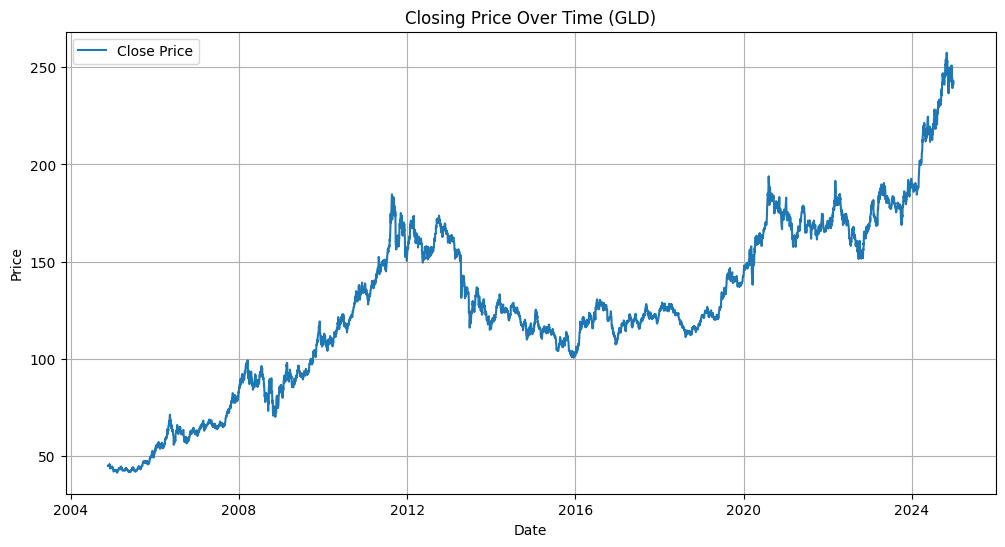

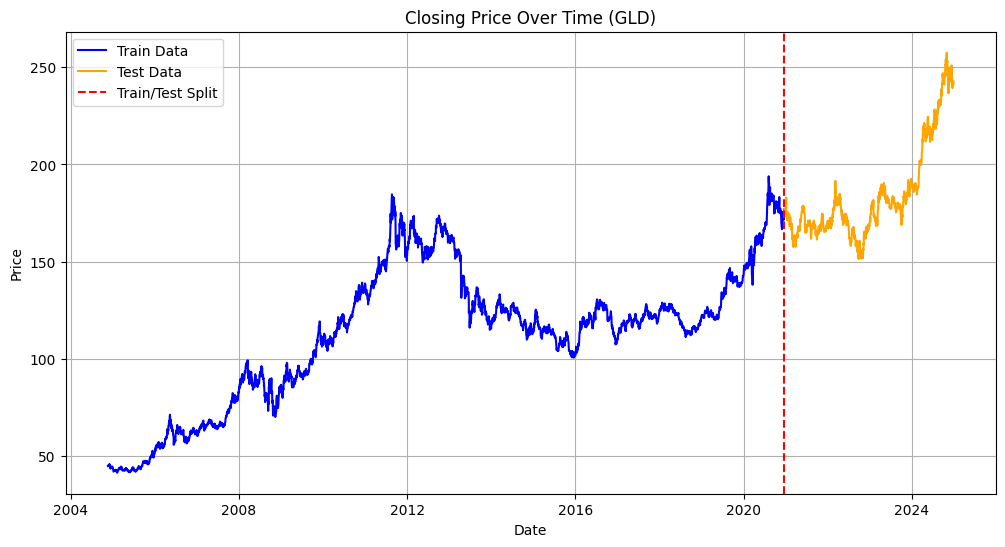

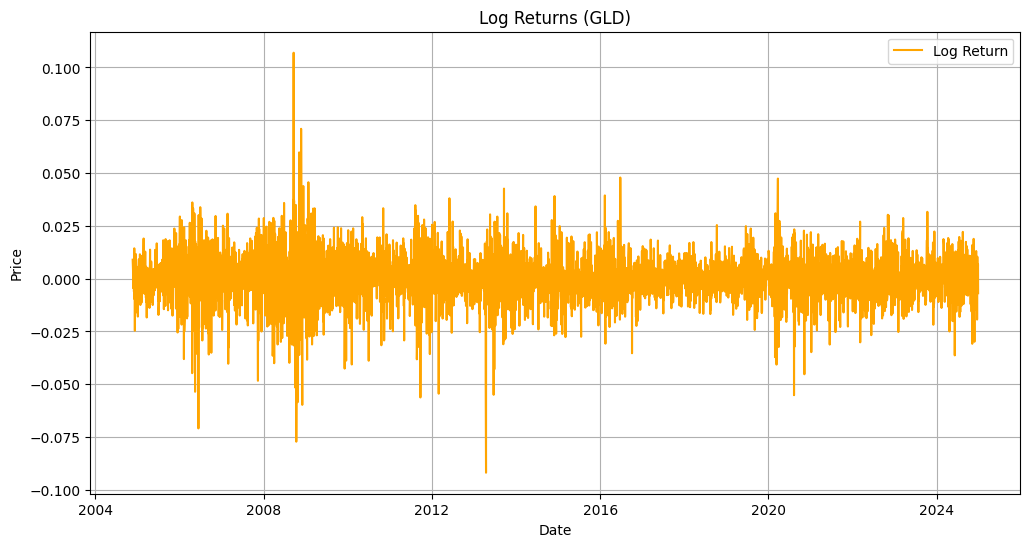


Augmented Dickey-Fuller Test (GLD):
ADF Statistic: -71.92323
p-value: 0.00000
Critical Values:
   1%: -3.43164
   5%: -2.86211
   10%: -2.56707


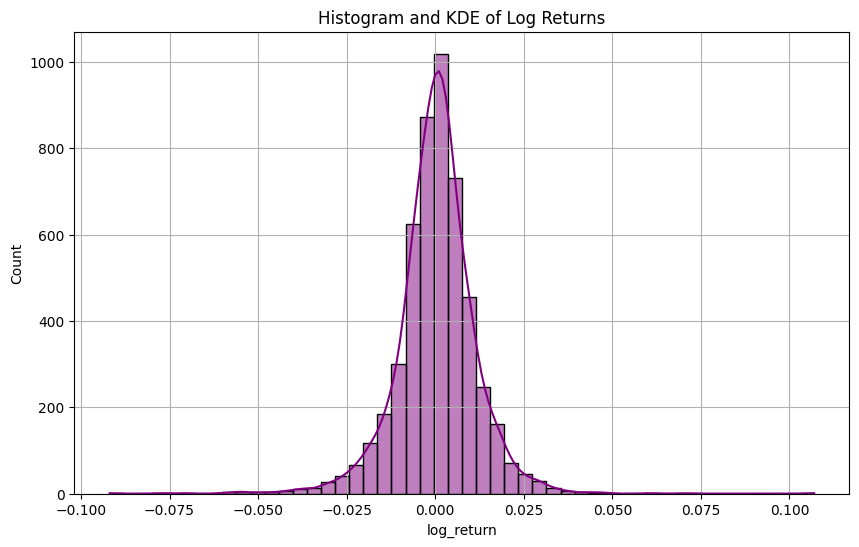

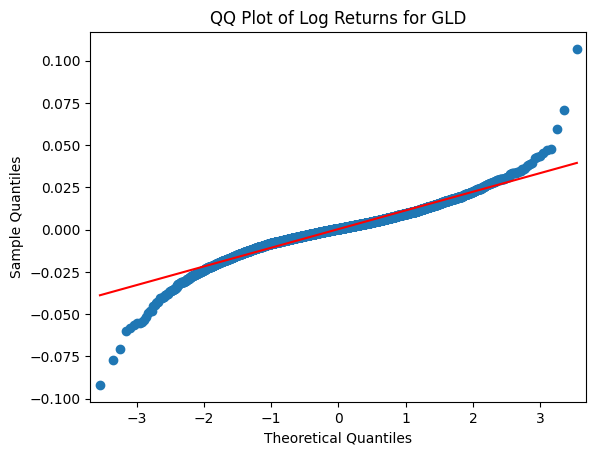

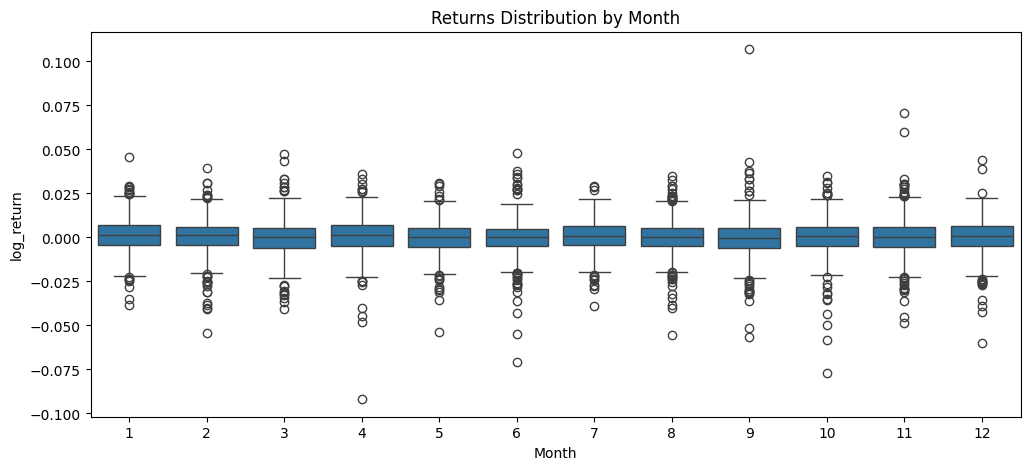

In [10]:
print(f"Data info for the stock:")
print(stock_data.info())
print("\nFirst 5 rows:")
print(stock_data.head())

print("\nMissing values per column:")
print(stock_data.isnull().sum())

print("\nSummary statistics:")
print(stock_data.describe())

plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
plt.title(f'Closing Price Over Time ({stock_code})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label='Train Data', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test Data', color='orange')
split_date = stock_data.index[split_idx]
plt.axvline(split_date, color='red', linestyle='--', label='Train/Test Split')
plt.title(f'Closing Price Over Time ({stock_code})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['log_return'], label='Log Return',color='orange')
plt.title(f'Log Returns ({stock_code})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# Step 4: Stationarity test (ADF)
adf_result = adfuller(stock_data['log_return'])
print(f"\nAugmented Dickey-Fuller Test ({stock_code}):")
print(f"ADF Statistic: {adf_result[0]:.5f}")
print(f"p-value: {adf_result[1]:.5f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.5f}")

# Step 5: Histogram + KDE plot for return distribution
plt.figure(figsize=(10, 6))
sns.histplot(stock_data['log_return'], bins=50, kde=True, color='purple')
plt.title('Histogram and KDE of Log Returns')
plt.grid(True)
plt.show()

# Step 6: QQ plot for normality check
sm.qqplot(stock_data['log_return'], line='s')
plt.title(f'QQ Plot of Log Returns for {stock_code}')
plt.show()

stock_data['Month'] = stock_data.index.month
stock_data['Weekday'] = stock_data.index.weekday

# Boxplot of returns by month
plt.figure(figsize=(12, 5))
sns.boxplot(x='Month', y='log_return', data=stock_data)
plt.title('Returns Distribution by Month')
plt.show()

## GARCH Modelling

- Generate rolling 1-step ahead volatility forecasts using a GARCH(1,1) model.
- For each date, fit the model on all past log returns up to the previous day (no lookahead).
- Forecast the next day’s volatility and store it aligned with the corresponding date.
- Apply this procedure separately to training and test datasets to get time-varying volatility estimates.

- Rolling forecast on the **training set**:
  - For each date in the training period (starting after day 20):
    - e.g.
        - On day 21, you fit using the first 20 days.
        - On day 22, you fit using days 1–21.
        - On day 23, days 1–22.

    - Use all log return data available *up to the previous day* (no lookahead).
    - Fit a GARCH(1,1) model on this subset of data.
    - Forecast the next day’s volatility (the current date).

- Rolling forecast on the **test set** *(Expanding window)*:
  - For each date in the test set:
    - Fit the GARCH(1,1) model using *all data up to the previous day* (combining train and test) --> Expanding the data every day by including more and more of the past (from 2004 up to the current date minus one)
    - Forecast 1-step ahead volatility for the current date.
    - Store the forecasted volatility.

In [11]:
# Step 1: Prepare to store volatility forecasts
garch_train_forecasts = []

# Step 2: Get training dates (start from a minimum window size for model stability)
train_dates = train_data.index[20:]  # skip first 20 days for minimum sample size

print("Generating rolling 1-step ahead GARCH volatility forecasts for training set...")

# Step 3: Rolling forecast for each date in the training set
for current_date in tqdm.tqdm(train_dates):
    # Use only data before current date
    train_until = current_date - pd.Timedelta(days=1)
    train_slice = train_data.loc[:train_until]['scale_log_return']

    # Fit GARCH(1,1)
    model = arch_model(train_slice, vol='Garch', p=1, q=1, rescale=False)
    res = model.fit(disp='off')

    # Forecast next day's volatility (for current_date)
    forecast = res.forecast(horizon=1, reindex=False)
    vol = np.sqrt(forecast.variance.values[-1, 0])/100

    garch_train_forecasts.append(vol)

# Step 4: Create aligned GARCH column in training data
# Pad with NaNs for the skipped initial 20 rows
garch_vol_padded = [np.nan]*20 + garch_train_forecasts
train_data['garch_volatility'] = garch_vol_padded

# Step 5: Rolling forecast
# Fit on train_data, then expand window day-by-day to forecast volatility for each test day

# Prepare an array to hold forecasts
garch_vol_forecasts = []

# Combine train and test indexes for iteration
all_dates = test_data.index

print("Generating rolling 1-step ahead GARCH volatility forecasts...")

for current_date in tqdm.tqdm(all_dates):
    # Define data up to the day before current_date (no lookahead)
    train_until = current_date - pd.Timedelta(days=1)

    # Extract returns up to train_until
    train_slice = stock_data.loc[:train_until]['scale_log_return']

    # Fit GARCH(1,1)
    model = arch_model(train_slice, vol='Garch', p=1, q=1, rescale=False)
    res = model.fit(disp='off')

    # Forecast volatility 1-step ahead (for current_date)
    forecast = res.forecast(horizon=1, reindex=False)

    # Extract forecast variance and convert to volatility and append to list
    vol = np.sqrt(forecast.variance.values[-1, 0])/100  # last row, horizon 1
    garch_vol_forecasts.append(vol)

# Step 6: Store forecasts in test_data
test_data['garch_volatility'] = garch_vol_forecasts

# Result
print("Train data GARCH vol:")
print(train_data[['Adj Close', 'log_return', 'garch_volatility']].head(25))
print('')
print("Test data GARCH vol:")
print(test_data[['Adj Close', 'log_return', 'garch_volatility']].head(10))

Generating rolling 1-step ahead GARCH volatility forecasts for training set...


100%|██████████| 4028/4028 [02:39<00:00, 25.32it/s]


Generating rolling 1-step ahead GARCH volatility forecasts...


100%|██████████| 1012/1012 [00:43<00:00, 23.09it/s]

Train data GARCH vol:
Price       Adj Close  log_return  garch_volatility
Date                                               
2004-11-19  44.779999    0.008973               NaN
2004-11-22  44.950001    0.003789               NaN
2004-11-23  44.750000   -0.004459               NaN
2004-11-24  45.049999    0.006682               NaN
2004-11-26  45.290001    0.005313               NaN
2004-11-29  45.400002    0.002426               NaN
2004-11-30  45.119999   -0.006187               NaN
2004-12-01  45.380001    0.005746               NaN
2004-12-02  44.950001   -0.009521               NaN
2004-12-03  45.599998    0.014357               NaN
2004-12-06  45.169998   -0.009475               NaN
2004-12-07  45.110001   -0.001329               NaN
2004-12-08  44.009998   -0.024687               NaN
2004-12-09  43.779999   -0.005240               NaN
2004-12-10  43.439999   -0.007796               NaN
2004-12-13  43.910000    0.010761               NaN
2004-12-14  43.549999   -0.008232         

In [12]:
train_data.to_csv(train_filename)
test_data.to_csv(test_filename)

In [13]:
train_data = pd.read_csv(train_filename, index_col=0, parse_dates=True)
test_data = pd.read_csv(test_filename, index_col=0, parse_dates=True)

## Compare predicted vs actual (Close-to-close vs GARCH)

- Realized volatility is computed as the rolling **standard deviation of log returns** over a specified window (5 days), representing actual historical price fluctuations.
- Calculates realized volatility then evaluates how well the GARCH model’s volatility forecasts match the realized volatility using error metrics (MSE, MAE), correlation, and R².

**Result**
- The GARCH model **performs well**, with a low MSE and MAE indicating **small forecast errors**.
- High correlation and R² show that the forecasts capture a substantial portion of the realized volatility’s variation.

- Overall, these metrics suggest that the **GARCH(1,1) model** provides **reliable and informative volatility forecasts** for the asset.



--- Evaluation on TEST SET ---
MSE: 0.000004
MAE: 0.001554
Correlation: 0.8077
R²: 0.4977

--- Evaluation on FULL DATASET (Train + Test) ---
Full MSE: 0.000007
Full MAE: 0.001958
Full Correlation: 0.8729
Full R²: 0.7296


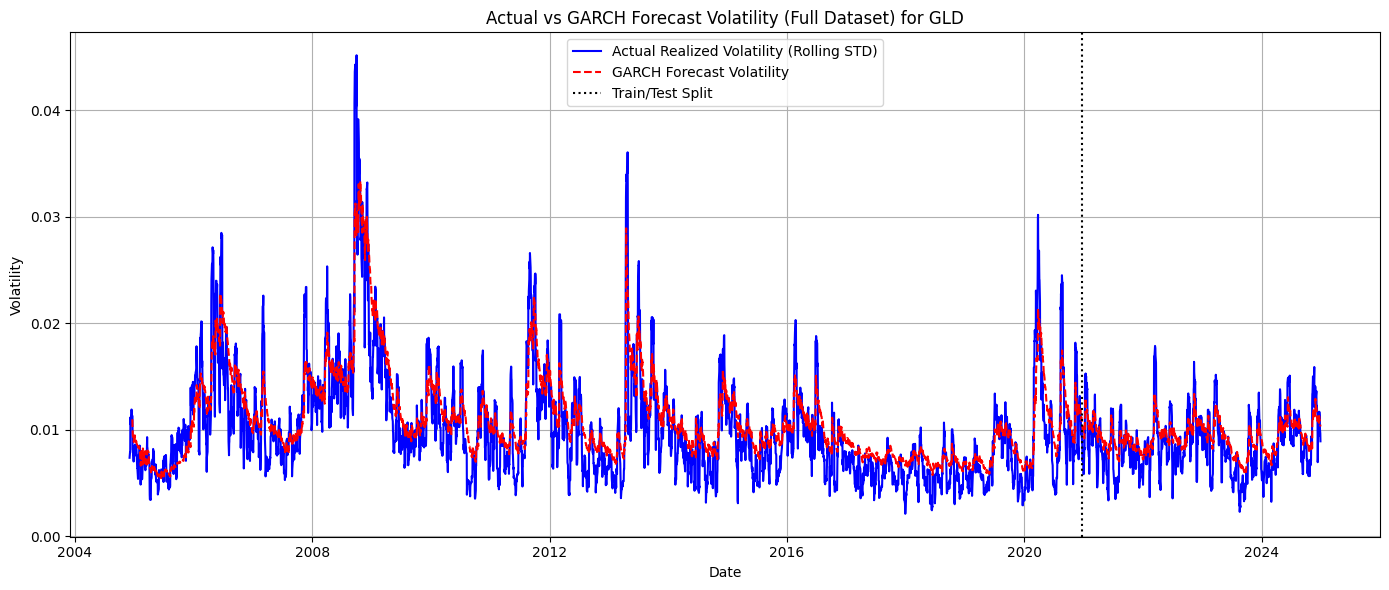

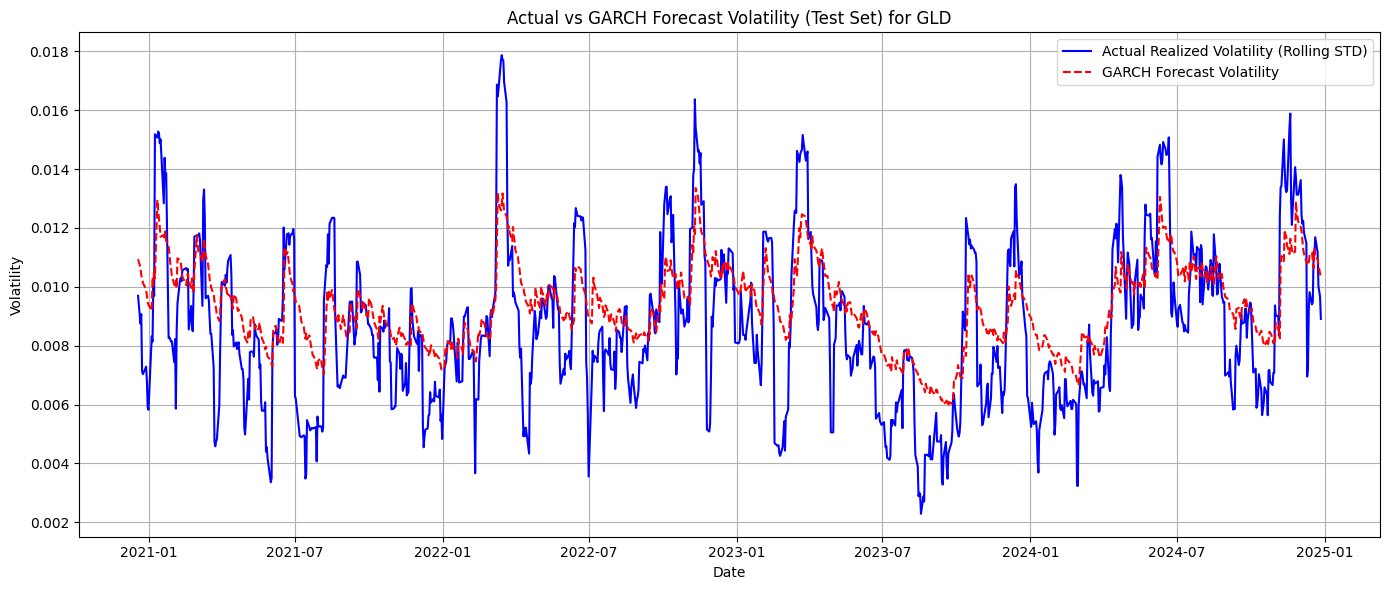

In [14]:
# --- 1. Define function to compute close-to-close realized volatility ---
def compute_realized_volatility(df, window=10):
    return df['log_return'].rolling(window=window).std()

# --- 2. Compute realized volatility on full dataset ---
stock_data['realized_volatility'] = compute_realized_volatility(stock_data)

# --- 3. Add realized volatility to train/test sets ---
train_data['realized_volatility'] = stock_data.loc[train_data.index, 'realized_volatility']
test_data['realized_volatility'] = stock_data.loc[test_data.index, 'realized_volatility']

# --- 4. Evaluate GARCH forecasts vs realized volatility on TEST SET ---
mse = mean_squared_error(test_data['realized_volatility'], test_data['garch_volatility'])
mae = mean_absolute_error(test_data['realized_volatility'], test_data['garch_volatility'])
corr = np.corrcoef(test_data['realized_volatility'], test_data['garch_volatility'])[0, 1]
r2 = r2_score(test_data['realized_volatility'], test_data['garch_volatility'])

print("\n--- Evaluation on TEST SET ---")
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Correlation: {corr:.4f}")
print(f"R²: {r2:.4f}")

# --- 5. Combine train and test data ---
combined_data = pd.concat([train_data, test_data]).sort_index()

# --- 6. Evaluate GARCH forecasts vs realized volatility on FULL DATA ---
combined_eval = combined_data[['realized_volatility', 'garch_volatility']].dropna()

mse_full = mean_squared_error(combined_eval['realized_volatility'], combined_eval['garch_volatility'])
mae_full = mean_absolute_error(combined_eval['realized_volatility'], combined_eval['garch_volatility'])
corr_full = np.corrcoef(combined_eval['realized_volatility'], combined_eval['garch_volatility'])[0, 1]
r2_full = r2_score(combined_eval['realized_volatility'], combined_eval['garch_volatility'])

print("\n--- Evaluation on FULL DATASET (Train + Test) ---")
print(f"Full MSE: {mse_full:.6f}")
print(f"Full MAE: {mae_full:.6f}")
print(f"Full Correlation: {corr_full:.4f}")
print(f"Full R²: {r2_full:.4f}")

# --- 7. Plot actual vs GARCH forecast volatility (full data) ---
plt.figure(figsize=(14, 6))
plt.plot(combined_data['realized_volatility'], label='Actual Realized Volatility (Rolling STD)', color='blue')

if 'garch_volatility' in combined_data.columns:
    plt.plot(combined_data['garch_volatility'], label='GARCH Forecast Volatility', color='red', linestyle='--')

# Mark the train/test split
plt.axvline(x=test_data.index[0], color='black', linestyle=':', label='Train/Test Split')

plt.title(f'Actual vs GARCH Forecast Volatility (Full Dataset) for {stock_code}')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(test_data['realized_volatility'], label='Actual Realized Volatility (Rolling STD)', color='blue')
plt.plot(test_data['garch_volatility'], label='GARCH Forecast Volatility', color='red', linestyle='--')
plt.title(f'Actual vs GARCH Forecast Volatility (Test Set) for {stock_code}')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Spike flag

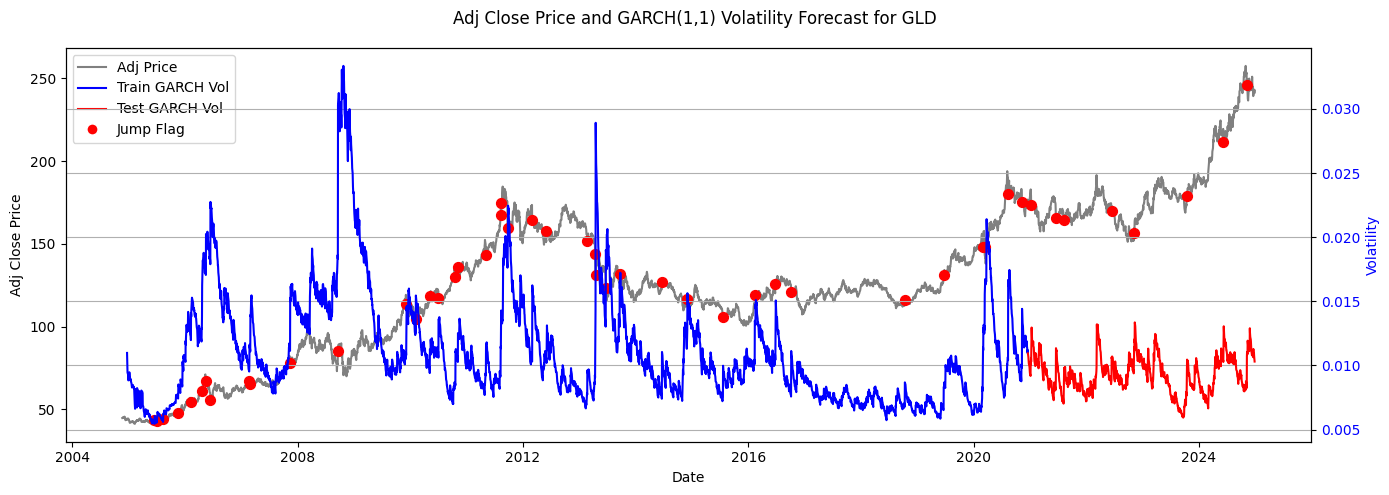

In [15]:
# Then concatenate the two DataFrames along the index (date)

garch_vol_combined = pd.concat([
    train_data['garch_volatility'],
    test_data['garch_volatility']
]).sort_index()

# Assign the combined series back to stock_data, aligning by index
stock_data['garch_volatility'] = garch_vol_combined

# Now create jump_flag using GARCH volatility in stock_data
threshold = 3
stock_data['jump_flag'] = (stock_data['log_return'].abs() > threshold * stock_data['garch_volatility']).astype(int)

# If you want to update train_data and test_data with jump_flag again:
train_data['jump_flag'] = stock_data.loc[train_data.index, 'jump_flag']
test_data['jump_flag'] = stock_data.loc[test_data.index, 'jump_flag']

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('Adj Close Price', color='black')
line1, = ax1.plot(stock_data['Adj Close'], label='Adj Price', color='grey')
ax1.tick_params(axis='y', labelcolor='black')

# Mark jump days on price chart (you can choose where to place markers)
jump_dates = stock_data.index[stock_data['jump_flag'] == 1]
jump_prices = stock_data.loc[jump_dates, 'Adj Close']
ax1.scatter(jump_dates, jump_prices, color='red', marker='o', label='Jump Flag', s=50, zorder=5)

ax2 = ax1.twinx()
ax2.set_ylabel('Volatility', color='blue')
line2, = ax2.plot(train_data['garch_volatility'], label='Train GARCH Vol', color='blue')
line3, = ax2.plot(test_data['garch_volatility'], label='Test GARCH Vol', color='red')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle(f"Adj Close Price and GARCH(1,1) Volatility Forecast for {stock_code}")
fig.tight_layout()
plt.grid()

# Combine handles and labels from all plots for legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]

# Add jump_flag scatter legend entry
jump_legend = Line2D([0], [0], marker='o', color='w', label='Jump Flag',
                      markerfacecolor='red', markersize=8)
lines.append(jump_legend)
labels.append('Jump Flag')

ax1.legend(lines, labels, loc='upper left')

plt.show()



# Technical Indicator

## Bollinger Band

In [16]:
def generate_bollinger_signals_with_risk_filter(
    df,
    n=20,
    k=2,
    garch_col='garch_volatility',
    risk_window=50,
    risk_percentile=0.75,
    train_df=None,
    max_position=1,
    post_jump_delay=3
):
    df = df.copy()

    # === Step 1: Bollinger Bands ===
    df['bb_middle'] = df['Adj Close'].rolling(window=n).mean()
    df['bb_std'] = df['Adj Close'].rolling(window=n).std()
    df['bb_upper'] = df['bb_middle'] + k * df['bb_std']
    df['bb_lower'] = df['bb_middle'] - k * df['bb_std']

    # === Step 2: Raw Signal ===
    df['bb_raw_signal'] = 0
    df.loc[df['Adj Close'] < df['bb_lower'], 'bb_raw_signal'] = 1
    df.loc[df['Adj Close'] > df['bb_upper'], 'bb_raw_signal'] = -1

    # === Step 3: GARCH Volatility Threshold ===
    threshold_col_name = f"bb_vol_threshold_{int(risk_percentile*100)}"
    if train_df is None:
        df[threshold_col_name] = (
            df[garch_col].shift(1)
            .rolling(window=risk_window)
            .quantile(risk_percentile)
        )
    else:
        combined_vol = pd.concat([
            train_df[garch_col].iloc[-risk_window:],
            df[garch_col]
        ])
        threshold = (
            combined_vol
            .rolling(window=risk_window)
            .quantile(risk_percentile)
            .shift(1)
        )
        df[threshold_col_name] = threshold.iloc[risk_window:]

    # === Step 4: Apply GARCH Risk Filter ===
    filtered_col_name = f"bb_filtered_signal_{int(risk_percentile*100)}"
    df[filtered_col_name] = df['bb_raw_signal']
    df.loc[df[garch_col] >= df[threshold_col_name], filtered_col_name] = 0

    # === Step 5: Post-Jump Delay Filter (Buys Only) ===
    if 'jump_flag' in df.columns:
        df['recent_jump'] = (
            df['jump_flag']
            .rolling(window=post_jump_delay, min_periods=1)
            .max()
            .shift(1)
            .fillna(0)
        )
        # Cancel only buy signals if recent jump
        df.loc[
            (df[filtered_col_name] == 1) & (df['recent_jump'] == 1),
            filtered_col_name
        ] = 0
    else:
        df['recent_jump'] = 0

    return df


In [17]:
def backtest_trading_strategy(df, signal_col,
                             value_col_prefix='bb_',
                             initial_capital=100000,
                             transaction_cost=0.001,
                             slippage_pct=0.001,
                             stop_loss_pct=0.03,
                             take_profit_pct=0.05,
                             max_position=1):
    df = df.copy()

    # Append SL/TP to prefix for unique column names
    value_col_prefix = f"{value_col_prefix}{int(stop_loss_pct*100)}_{int(take_profit_pct*100)}_"

    capital = initial_capital
    position = 0
    position_entries = []  # list of dicts: {'price', 'shares', 'index'}
    trade_log = []
    strategy_value = []
    position_history = []
    cash_history = []
    signal_history = []

    total_cost_pct = transaction_cost + slippage_pct

    for i in range(len(df)):
        date = df.index[i]
        price = df.iloc[i]['Adj Close']
        signal = df.iloc[i][signal_col]
        exited_entries = []
        net_signal = 0

        # === Buy logic ===
        if signal == 1 and len(position_entries) < max_position:
            shares = int(capital / (price * (1 + total_cost_pct)))
            if shares > 0:
                cost = shares * price * (1 + total_cost_pct)
                capital -= cost
                position_entries.append({'price': price, 'shares': shares, 'index': i})
                position += shares
                trade_log.append((date, 'BUY', shares, price, cost))
                net_signal += shares

        # === Check SL/TP on each open entry ===
        for entry in position_entries:
            entry_price = entry['price']
            shares_held = entry['shares']
            sl_triggered = stop_loss_pct is not None and price <= entry_price * (1 - stop_loss_pct)
            tp_triggered = take_profit_pct is not None and price >= entry_price * (1 + take_profit_pct)

            if sl_triggered:
                exited_entries.append((entry, 'stop_loss'))
            elif tp_triggered:
                exited_entries.append((entry, 'take_profit'))

        # === Exit entries via SL/TP ===
        for exit_entry, reason in exited_entries:
            shares_to_sell = exit_entry['shares']
            proceeds = shares_to_sell * price * (1 - total_cost_pct)
            capital += proceeds
            position -= shares_to_sell
            trade_log.append((date, 'SELL', shares_to_sell, price, proceeds, reason))
            position_entries.remove(exit_entry)
            net_signal -= shares_to_sell

        # === Sell signal: exit all ===
        if signal == -1 and position > 0:
            total_shares = sum(e['shares'] for e in position_entries)
            proceeds = total_shares * price * (1 - total_cost_pct)
            capital += proceeds
            trade_log.append((date, 'SELL', total_shares, price, proceeds, 'sell_signal'))
            position_entries.clear()
            position = 0
            net_signal -= total_shares

        # === Track performance ===
        strategy_value.append(capital + position * price)
        position_history.append(position)
        cash_history.append(capital)
        signal_history.append(net_signal)

    # === Build result DataFrame ===
    result_df = pd.DataFrame(index=df.index)
    result_df['Adj Close'] = df['Adj Close']
    result_df[f'{value_col_prefix}position'] = position_history
    result_df[f'{value_col_prefix}cash'] = cash_history
    result_df[f'{value_col_prefix}strategy_value'] = strategy_value
    result_df[f'{value_col_prefix}signal'] = signal_history
    result_df[f'{value_col_prefix}log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    result_df[f'{value_col_prefix}strategy_return'] = np.log(result_df[f'{value_col_prefix}strategy_value'] /
                                                              result_df[f'{value_col_prefix}strategy_value'].shift(1))

    return result_df, trade_log


In [18]:
def evaluate_strategy(df,
                      value_col='bb_strategy_value',
                      return_col='bb_strategy_return',
                      benchmark_returns=None,  # Series of benchmark returns (e.g., market)
                      asset_returns=None,      # Series of asset returns (e.g., GLD)
                      rf_series=None,          # Series of daily risk-free returns (e.g. T-bill rate)
                      position_col='bb_position',
                      verbose=True):

    if benchmark_returns is None:
        raise ValueError("Please provide benchmark_returns as a Series.")
    if asset_returns is None:
        raise ValueError("Please provide asset_returns as a Series.")

    df = df.copy()
    df = df[[value_col, return_col, position_col]].dropna()

    # Align all inputs to strategy df index
    benchmark_returns = benchmark_returns.reindex(df.index).dropna()
    asset_returns = asset_returns.reindex(df.index).dropna()
    df = df.loc[benchmark_returns.index.intersection(asset_returns.index)]

    if rf_series is not None:
        # Align risk-free rate and forward-fill missing values if any
        rf_series = rf_series.reindex(df.index).ffill()
    else:
        # If no risk-free series provided, assume zero risk-free rate
        rf_series = pd.Series(0, index=df.index)

    strategy_returns = df[return_col]

    # === Calculate Jensen's Alpha ===
    excess_strategy_returns = strategy_returns - rf_series
    excess_benchmark_returns = benchmark_returns - rf_series
    excess_asset_returns = asset_returns - rf_series

    X_bench = sm.add_constant(excess_benchmark_returns)
    X_asset = sm.add_constant(excess_asset_returns)

    model_bench = sm.OLS(excess_strategy_returns.loc[X_bench.index], X_bench).fit()
    alpha_bench_daily = model_bench.params['const']

    model_asset = sm.OLS(excess_strategy_returns.loc[X_asset.index], X_asset).fit()
    alpha_asset_daily = model_asset.params['const']

    alpha_annualized_bench = (1 + alpha_bench_daily) ** 252 - 1
    alpha_annualized_asset = (1 + alpha_asset_daily) ** 252 - 1

    # === Base metrics ===
    total_return = df[value_col].iloc[-1] / df[value_col].iloc[0] - 1
    annualized_return = (1 + total_return) ** (252 / len(strategy_returns)) - 1
    annualized_vol = strategy_returns.std() * np.sqrt(252)

    # Calculate daily excess returns (strategy returns - risk-free rate)
    excess_returns = strategy_returns - rf_series
    # Annualized mean of excess returns
    mean_excess_return = excess_returns.mean() * 252
    # Annualized std dev of excess returns
    std_excess_return = excess_returns.std() * np.sqrt(252)
    # Sharpe ratio: mean excess return divided by std dev
    sharpe = mean_excess_return / std_excess_return if std_excess_return != 0 else np.nan


    win_rate = (strategy_returns > 0).sum() / len(strategy_returns) * 100
    avg_gain = strategy_returns[strategy_returns > 0].mean()
    avg_loss = strategy_returns[strategy_returns < 0].mean()
    total_gain = strategy_returns[strategy_returns > 0].sum()
    total_loss = -strategy_returns[strategy_returns < 0].sum()
    profit_factor = total_gain / total_loss if total_loss != 0 else np.nan

    # === Drawdown ===
    cum_val = df[value_col]
    drawdown = cum_val / cum_val.cummax() - 1
    max_drawdown = drawdown.min()

    # === Drawdown duration ===
    in_drawdown = drawdown < 0
    drawdown_durations = []
    duration = 0
    for d in in_drawdown:
        if d:
            duration += 1
        elif duration > 0:
            drawdown_durations.append(duration)
            duration = 0
    max_drawdown_duration = max(drawdown_durations) if drawdown_durations else 0

    # === Holding periods ===
    holding_periods = []
    current_holding = None
    start_date = None
    for i in range(len(df)):
        pos = df[position_col].iloc[i]
        date = df.index[i]

        if current_holding is None and pos != 0:
            current_holding = pos
            start_date = date
        elif current_holding is not None:
            if pos != current_holding:
                end_date = df.index[i - 1]
                holding_length = (end_date - start_date).days
                holding_periods.append((holding_length, start_date, end_date))
                if pos != 0:
                    current_holding = pos
                    start_date = date
                else:
                    current_holding = None
                    start_date = None
    if current_holding is not None:
        end_date = df.index[-1]
        holding_length = (end_date - start_date).days
        holding_periods.append((holding_length, start_date, end_date))

    holding_days = [h[0] for h in holding_periods]
    avg_holding = np.mean(holding_days) if holding_days else np.nan
    longest = max(holding_periods, key=lambda x: x[0]) if holding_periods else (np.nan, None, None)
    shortest = min(holding_periods, key=lambda x: x[0]) if holding_periods else (np.nan, None, None)

    # === Ratios ===
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan
    downside_vol = strategy_returns[strategy_returns < 0].std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_vol if downside_vol != 0 else np.nan

    # === Exposure, trades, turnover ===
    exposure = (df[position_col] != 0).sum() / len(df) * 100
    trades = (df[position_col] != df[position_col].shift()).sum()
    turnover = trades / len(df)

    # === Streaks ===
    signs = np.sign(strategy_returns.values)
    win_streaks = [sum(1 for _ in g) for k, g in groupby(signs) if k == 1]
    loss_streaks = [sum(1 for _ in g) for k, g in groupby(signs) if k == -1]
    max_win_streak = max(win_streaks, default=0)
    max_loss_streak = max(loss_streaks, default=0)

    # === VaR and CVaR ===
    var_95 = np.percentile(strategy_returns, 5)
    cvar_95 = strategy_returns[strategy_returns <= var_95].mean()

    # === Cumulative returns ===
    df['strategy_cum_return'] = (1 + strategy_returns).cumprod() - 1
    df['benchmark_cum_return'] = (1 + benchmark_returns).cumprod() - 1

    # === Print ===
    if verbose:
        print(f"\nStrategy Performance Summary for {value_col}:")
        print(f"Total return:            {total_return:.2%}")
        print(f"Annualized return:       {annualized_return:.2%}")
        print(f"Annualized volatility:   {annualized_vol:.2%}")
        print(f"Sharpe ratio:            {sharpe:.2f}")
        print(f"Jensen's alpha (market benchmark): {alpha_annualized_bench:.2%}")
        print(f"Jensen's alpha (asset benchmark):  {alpha_annualized_asset:.2%}")
        print(f"Sortino ratio:           {sortino_ratio:.2f}")
        print(f"Calmar ratio:            {calmar_ratio:.2f}")
        print(f"Max drawdown:            {max_drawdown:.2%}")
        print(f"Max drawdown duration:   {max_drawdown_duration} days")
        print(f"Win rate:                {win_rate:.2f}%")
        print(f"Max win streak:          {max_win_streak} trades")
        print(f"Max loss streak:         {max_loss_streak} trades")
        print(f"Average gain:            {avg_gain:.4f}")
        print(f"Average loss:            {avg_loss:.4f}")
        print(f"Profit factor:           {profit_factor:.2f}")
        print(f"Exposure time:           {exposure:.2f}%")
        print(f"Trade count:             {trades}")
        print(f"Turnover:                {turnover:.2%}")
        print(f"VaR (95%):               {var_95:.4f}")
        print(f"CVaR (95%):              {cvar_95:.4f}")
        print(f"Average holding period:  {avg_holding:.2f} days")
        print(f"Longest holding:         {longest[0]} days ({longest[1]} to {longest[2]})")
        print(f"Shortest holding:        {shortest[0]} days ({shortest[1]} to {shortest[2]})")

    # === Return dict ===
    return {
        "total_return": total_return,
        "annualized_return": annualized_return,
        "annualized_volatility": annualized_vol,
        "sharpe_ratio": sharpe,
        "alpha_annualized_market_benchmark": alpha_annualized_bench,
        "alpha_annualized_asset_benchmark": alpha_annualized_asset,
        "sortino_ratio": sortino_ratio,
        "calmar_ratio": calmar_ratio,
        "max_drawdown": max_drawdown,
        "max_drawdown_duration": max_drawdown_duration,
        "win_rate": win_rate,
        "max_win_streak": max_win_streak,
        "max_loss_streak": max_loss_streak,
        "average_gain": avg_gain,
        "average_loss": avg_loss,
        "profit_factor": profit_factor,
        "exposure": exposure,
        "trade_count": trades,
        "turnover": turnover,
        "VaR_95": var_95,
        "CVaR_95": cvar_95,
        "average_holding_days": avg_holding,
        "longest_holding_days": longest[0],
        "longest_holding_start": longest[1],
        "longest_holding_end": longest[2],
        "shortest_holding_days": shortest[0],
        "shortest_holding_start": shortest[1],
        "shortest_holding_end": shortest[2],
    }


In [ ]:
risk_percentiles = [0.5, 0.75, 0.9]

# Generate Bollinger signals with GARCH-based risk filtering
for rp in risk_percentiles:
    train_data = generate_bollinger_signals_with_risk_filter(train_data, risk_percentile=rp)
    test_data = generate_bollinger_signals_with_risk_filter(test_data, train_df=train_data, risk_percentile=rp)

# Drop threshold columns if not needed
threshold_cols = [f"bb_vol_threshold_{int(rp*100)}" for rp in risk_percentiles]
train_data.drop(columns=threshold_cols, inplace=True, errors='ignore')
test_data.drop(columns=threshold_cols, inplace=True, errors='ignore')


# Define strategies and parameter grids
bb_strategies = [
    ('bb_pure', 'bb_raw_signal'),
    ('bb_garch_50', 'bb_filtered_signal_50'),
    ('bb_garch_75', 'bb_filtered_signal_75'),
    ('bb_garch_90', 'bb_filtered_signal_90')
]

stop_loss_values = [0.03, 0.05, 0.08, 0.5]
take_profit_values = [0.05, 0.1, 0.2, 0.5]
logs = {}
backtests = {}

# Run backtests with clean prefix naming
for strategy_prefix, signal_col in bb_strategies:
    for stop_loss in stop_loss_values:
        for take_profit in take_profit_values:
            # Clean prefix: no trailing underscore
            prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

            bt, log = backtest_trading_strategy(
                test_data,
                signal_col=signal_col,
                value_col_prefix=f"{strategy_prefix}_",  # backtest function will append _strategy_value etc.
                stop_loss_pct=stop_loss,
                take_profit_pct=take_profit
            )

            backtests[prefix] = bt
            logs[prefix] = log

# Dictionary to store performance results
performance_results = {}

# Loop through all backtests stored in `backtests`
for prefix, bt in backtests.items():
    # Define value and return column names based on your prefix
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    # Evaluate strategy
    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    # Store performance
    performance_results[f'{prefix}_perf'] = perf

# Optional: print a summary for each
#for prefix, perf in performance_results.items():
#    print(f"Performance for {prefix}:")
#    print(perf)
#    print('#################################################################')



In [ ]:
def plot_all_bollinger_combinations(backtests, stop_loss_values, take_profit_values, stock_code='Stock'):
    """
    Loop through all SL/TP combinations and plot BB Pure vs GARCH-filtered strategies.

    Parameters:
        backtests: dict of backtest DataFrames (keys = prefixes, e.g., 'bb_pure_3_5')
        stop_loss_values: list of stop-loss percentages (e.g., [0.03, 0.05])
        take_profit_values: list of take-profit percentages (e.g., [0.05, 0.1])
        stock_code: str
    """

    for sl in stop_loss_values:
        for tp in take_profit_values:
            sl_int = int(sl * 100)
            tp_int = int(tp * 100)

            # Construct strategy prefixes (no trailing underscore)
            prefixes = [
                f'bb_pure_{sl_int}_{tp_int}',
                f'bb_garch_50_{sl_int}_{tp_int}',
                f'bb_garch_75_{sl_int}_{tp_int}',
                f'bb_garch_90_{sl_int}_{tp_int}'
            ]

            labels = ['BB Pure', 'BB GARCH 50', 'BB GARCH 75', 'BB GARCH 90']
            colors = ['orange', 'green', 'blue', 'purple']

            # --- Normalized Strategy Value ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, labels, colors):
                if prefix not in backtests:
                    print(f"Warning: {prefix} not found in backtests. Skipping.")
                    continue
                df = backtests[prefix]
                value_col = f"{prefix}_strategy_value"
                norm_val = df[value_col] / df[value_col].iloc[0]
                plt.plot(df.index, norm_val, label=label, color=color)
            plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Normalized Strategy Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # --- Cumulative Returns ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, labels, colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                return_col = f"{prefix}_strategy_return"
                cumret = (1 + df[return_col]).cumprod() - 1
                plt.plot(df.index, cumret, label=label, color=color)
            plt.title(f'Cumulative Returns for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # --- Positions ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, labels, colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                position_col = f"{prefix}_position"
                plt.step(df.index, df[position_col], label=label, where='post', color=color)
            plt.title(f'Position Size Over Time for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Position')
            plt.xlabel('Date')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


plot_all_bollinger_combinations(
    backtests,
    stop_loss_values=[0.03, 0.05, 0.08,0.5],
    take_profit_values=[0.05, 0.1, 0.2,0.5],
    stock_code=f'{stock_code}'
)


## MACD

In [21]:
def generate_macd_signals_with_risk_filter(
    df,
    garch_col='garch_volatility',
    risk_window=50,
    risk_percentile=0.75,
    train_df=None,
    max_position=1,
    post_jump_delay=3
):
    df = df.copy()

    # === Step 1: MACD and Signal Line ===
    ema12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['macd_line'] = ema12 - ema26
    df['macd_signal_line'] = df['macd_line'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd_line'] - df['macd_signal_line']

    # === Step 2: Raw Signal ===
    df['macd_raw_signal'] = 0
    df.loc[
        (df['macd_line'] > df['macd_signal_line']) &
        (df['macd_line'].shift(1) <= df['macd_signal_line'].shift(1)),
        'macd_raw_signal'
    ] = 1
    df.loc[
        (df['macd_line'] < df['macd_signal_line']) &
        (df['macd_line'].shift(1) >= df['macd_signal_line'].shift(1)),
        'macd_raw_signal'
    ] = -1

    # === Step 3: GARCH Volatility Threshold ===
    threshold_col_name = f"macd_vol_threshold_{int(risk_percentile*100)}"

    if train_df is None:
        df[threshold_col_name] = df[garch_col].shift(1).rolling(window=risk_window).quantile(risk_percentile)
    else:
        combined_vol = pd.concat([
            train_df[garch_col].iloc[-risk_window:],
            df[garch_col]
        ])
        threshold = (
            combined_vol
            .rolling(window=risk_window)
            .quantile(risk_percentile)
            .shift(1)
        )
        df[threshold_col_name] = threshold.iloc[risk_window:]

    # === Step 4: Risk Filter — GARCH only ===
    filtered_col_name = f"macd_filtered_signal_{int(risk_percentile*100)}"
    df[filtered_col_name] = df['macd_raw_signal']
    df.loc[df[garch_col] >= df[threshold_col_name], filtered_col_name] = 0

    # === Step 5: Post-Jump Delay Filter (Buys Only) ===
    if 'jump_flag' in df.columns:
        df['recent_jump'] = (
            df['jump_flag']
            .rolling(window=post_jump_delay, min_periods=1)
            .max()
            .shift(1)
            .fillna(0)
        )
        # Cancel only buy signals if recent jump
        df.loc[
            (df[filtered_col_name] == 1) & (df['recent_jump'] == 1),
            filtered_col_name
        ] = 0
    else:
        df['recent_jump'] = 0

    return df


In [ ]:
# Generate macd signals with GARCH-based risk filtering
for rp in risk_percentiles:
    train_data = generate_macd_signals_with_risk_filter(train_data, risk_percentile=rp)
    test_data = generate_macd_signals_with_risk_filter(test_data, train_df=train_data, risk_percentile=rp)

# Drop threshold columns if not needed
threshold_cols = [f"macd_vol_threshold_{int(rp*100)}" for rp in risk_percentiles]
train_data.drop(columns=threshold_cols, inplace=True, errors='ignore')
test_data.drop(columns=threshold_cols, inplace=True, errors='ignore')


# Define strategies and parameter grids
macd_strategies = [
    ('macd_pure', 'macd_raw_signal'),
    ('macd_garch_50', 'macd_filtered_signal_50'),
    ('macd_garch_75', 'macd_filtered_signal_75'),
    ('macd_garch_90', 'macd_filtered_signal_90')
]




# Run backtests with clean prefix naming
for strategy_prefix, signal_col in macd_strategies:
    for stop_loss in stop_loss_values:
        for take_profit in take_profit_values:
            # Clean prefix: no trailing underscore
            prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

            bt, log = backtest_trading_strategy(
                test_data,
                signal_col=signal_col,
                value_col_prefix=f"{strategy_prefix}_",  # backtest function will append _strategy_value etc.
                stop_loss_pct=stop_loss,
                take_profit_pct=take_profit
            )

            backtests[prefix] = bt
            logs[prefix] = log


# Loop through all backtests stored in `backtests`
for prefix, bt in backtests.items():
    # Define value and return column names based on your prefix
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    # Evaluate strategy
    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    # Store performance
    performance_results[f'{prefix}_perf'] = perf

# Optional: print a summary for each
#for prefix, perf in performance_results.items():
#    print(f"Performance for {prefix}:")
#    print(perf)
#    print('#################################################################')



In [ ]:
def plot_all_macd_combinations(backtests, stop_loss_values, take_profit_values, stock_code='Stock'):
    """
    Loop through all SL/TP combinations and plot MACD Pure vs GARCH-filtered strategies.

    Parameters:
        backtests: dict of backtest DataFrames (keys = prefixes, e.g., 'macd_pure_3_5')
        stop_loss_values: list of stop-loss percentages (e.g., [0.03, 0.05])
        take_profit_values: list of take-profit percentages (e.g., [0.05, 0.1])
        stock_code: str
    """
    macd_labels = ['MACD Pure', 'MACD GARCH 50', 'MACD GARCH 75', 'MACD GARCH 90']
    macd_colors = ['orange', 'green', 'blue', 'purple']

    for sl in stop_loss_values:
        for tp in take_profit_values:
            sl_int = int(sl * 100)
            tp_int = int(tp * 100)

            prefixes = [
                f'macd_pure_{sl_int}_{tp_int}',
                f'macd_garch_50_{sl_int}_{tp_int}',
                f'macd_garch_75_{sl_int}_{tp_int}',
                f'macd_garch_90_{sl_int}_{tp_int}'
            ]

            # --- Normalized Strategy Value ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, macd_labels, macd_colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                value_col = f"{prefix}_strategy_value"
                norm_val = df[value_col] / df[value_col].iloc[0]
                plt.plot(df.index, norm_val, label=label, color=color)
            plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Normalized Strategy Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # --- Cumulative Returns ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, macd_labels, macd_colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                return_col = f"{prefix}_strategy_return"
                cumret = (1 + df[return_col]).cumprod() - 1
                plt.plot(df.index, cumret, label=label, color=color)
            plt.title(f'Cumulative Returns for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # --- Positions ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, macd_labels, macd_colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                position_col = f"{prefix}_position"
                plt.step(df.index, df[position_col], label=label, where='post', color=color)
            plt.title(f'Position Size Over Time for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Position')
            plt.xlabel('Date')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

plot_all_macd_combinations(
    backtests,
    stop_loss_values=[0.03, 0.05, 0.08, 0.5],
    take_profit_values=[0.05, 0.1, 0.2, 0.5],
    stock_code=f'{stock_code}'
)


## RSI

In [24]:
def generate_rsi_signals_with_risk_filter(
    df,
    rsi_period=14,
    rsi_lower=40,
    rsi_upper=60,
    garch_col='garch_volatility',
    risk_window=50,
    risk_percentile=0.75,
    train_df=None,
    max_position=1,
    post_jump_delay=3
):
    df = df.copy()

    # === Step 1: RSI Calculation ===
    delta = df['Adj Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # === Step 2: Raw RSI Signal ===
    df['rsi_raw_signal'] = 0
    df.loc[(df['rsi'] > rsi_lower) & (df['rsi'].shift(1) <= rsi_lower), 'rsi_raw_signal'] = 1
    df.loc[(df['rsi'] < rsi_upper) & (df['rsi'].shift(1) >= rsi_upper), 'rsi_raw_signal'] = -1

    # === Step 3: GARCH Volatility Threshold ===
    threshold_col_name = f"rsi_vol_threshold_{int(risk_percentile*100)}"

    if train_df is None:
        df[threshold_col_name] = df[garch_col].shift(1).rolling(window=risk_window).quantile(risk_percentile)
    else:
        combined_vol = pd.concat([
            train_df[garch_col].iloc[-risk_window:],
            df[garch_col]
        ])
        threshold = (
            combined_vol
            .rolling(window=risk_window)
            .quantile(risk_percentile)
            .shift(1)
        )
        df[threshold_col_name] = threshold.iloc[risk_window:].reset_index(drop=True).values

    # === Step 4: Risk-Filtered Signal ===
    filtered_col_name = f"rsi_filtered_signal_{int(risk_percentile*100)}"
    df[filtered_col_name] = df['rsi_raw_signal']
    df.loc[df[garch_col] >= df[threshold_col_name], filtered_col_name] = 0

    # === Step 5: Post-Jump Delay Filter (Buys Only) ===
    if 'jump_flag' in df.columns:
        df['recent_jump'] = (
            df['jump_flag']
            .rolling(window=post_jump_delay, min_periods=1)
            .max()
            .shift(1)
            .fillna(0)
        )
        # Cancel only buy signals if recent jump
        df.loc[
            (df[filtered_col_name] == 1) & (df['recent_jump'] == 1),
            filtered_col_name
        ] = 0
    else:
        df['recent_jump'] = 0

    return df


In [ ]:

# Generate rsi signals with GARCH-based risk filtering
for rp in risk_percentiles:
    train_data = generate_rsi_signals_with_risk_filter(train_data, risk_percentile=rp)
    test_data = generate_rsi_signals_with_risk_filter(test_data, train_df=train_data, risk_percentile=rp)

# Drop threshold columns if not needed
threshold_cols = [f"rsi_vol_threshold_{int(rp*100)}" for rp in risk_percentiles]
train_data.drop(columns=threshold_cols, inplace=True, errors='ignore')
test_data.drop(columns=threshold_cols, inplace=True, errors='ignore')


# Define strategies and parameter grids
rsi_strategies = [
    ('rsi_pure', 'rsi_raw_signal'),
    ('rsi_garch_50', 'rsi_filtered_signal_50'),
    ('rsi_garch_75', 'rsi_filtered_signal_75'),
    ('rsi_garch_90', 'rsi_filtered_signal_90')
]


# Run backtests with clean prefix naming
for strategy_prefix, signal_col in rsi_strategies:
    for stop_loss in stop_loss_values:
        for take_profit in take_profit_values:
            # Clean prefix: no trailing underscore
            prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

            bt, log = backtest_trading_strategy(
                test_data,
                signal_col=signal_col,
                value_col_prefix=f"{strategy_prefix}_",  # backtest function will append _strategy_value etc.
                stop_loss_pct=stop_loss,
                take_profit_pct=take_profit
            )

            backtests[prefix] = bt
            logs[prefix] = log


# Loop through all backtests stored in `backtests`
for prefix, bt in backtests.items():
    # Define value and return column names based on your prefix
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    # Evaluate strategy
    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    # Store performance
    performance_results[f'{prefix}_perf'] = perf

# Optional: print a summary for each
#for prefix, perf in performance_results.items():
#    print(f"Performance for {prefix}:")
#    print(perf)
#    print('#################################################################')



In [ ]:
def plot_all_rsi_combinations(backtests, stop_loss_values, take_profit_values, stock_code='Stock'):
    """
    Loop through all SL/TP combinations and plot RSI Pure vs GARCH-filtered strategies.

    Parameters:
        backtests: dict of backtest DataFrames (keys = prefixes, e.g., 'rsi_pure_3_5')
        stop_loss_values: list of stop-loss percentages (e.g., [0.03, 0.05])
        take_profit_values: list of take-profit percentages (e.g., [0.05, 0.1])
        stock_code: str
    """
    rsi_labels = ['RSI Pure', 'RSI GARCH 50', 'RSI GARCH 75', 'RSI GARCH 90']
    rsi_colors = ['orange', 'green', 'blue', 'purple']

    for sl in stop_loss_values:
        for tp in take_profit_values:
            sl_int = int(sl * 100)
            tp_int = int(tp * 100)

            prefixes = [
                f'rsi_pure_{sl_int}_{tp_int}',
                f'rsi_garch_50_{sl_int}_{tp_int}',
                f'rsi_garch_75_{sl_int}_{tp_int}',
                f'rsi_garch_90_{sl_int}_{tp_int}'
            ]

            # --- Normalized Strategy Value ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, rsi_labels, rsi_colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                value_col = f"{prefix}_strategy_value"
                norm_val = df[value_col] / df[value_col].iloc[0]
                plt.plot(df.index, norm_val, label=label, color=color)
            plt.title(f'RSI Strategy Values (Normalized) for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Normalized Strategy Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # --- Cumulative Returns ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, rsi_labels, rsi_colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                return_col = f"{prefix}_strategy_return"
                cumret = (1 + df[return_col]).cumprod() - 1
                plt.plot(df.index, cumret, label=label, color=color)
            plt.title(f'RSI Cumulative Returns for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # --- Positions ---
            plt.figure(figsize=(16,5))
            for prefix, label, color in zip(prefixes, rsi_labels, rsi_colors):
                if prefix not in backtests:
                    continue
                df = backtests[prefix]
                position_col = f"{prefix}_position"
                plt.step(df.index, df[position_col], label=label, where='post', color=color)
            plt.title(f'RSI Position Sizes for {stock_code}\nSL={sl}, TP={tp}')
            plt.ylabel('Position')
            plt.xlabel('Date')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


plot_all_rsi_combinations(
    backtests,
    stop_loss_values=[0.03, 0.05, 0.08, 0.5],
    take_profit_values=[0.05, 0.1, 0.2, 0.5],
    stock_code=f'{stock_code}'
)

## Baseline

In [27]:
bb_pure_bt, bb_pure_log = backtest_trading_strategy(test_data, signal_col='bb_raw_signal', value_col_prefix='bb_pure_',stop_loss_pct=0.05,take_profit_pct=0.2)
bb_garch_bt, bb_garch_log = backtest_trading_strategy(test_data, signal_col='bb_filtered_signal_75', value_col_prefix='bb_garch_', stop_loss_pct=0.05,take_profit_pct=0.2)



bb_pure_perf = evaluate_strategy(
    bb_pure_bt,
    value_col='bb_pure_5_20_strategy_value',
    return_col='bb_pure_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='bb_pure_5_20_position',
    verbose=False
)


bb_garch_perf = evaluate_strategy(
    bb_garch_bt,
    value_col='bb_garch_5_20_strategy_value',
    return_col='bb_garch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='bb_garch_5_20_position',
    verbose=False
)


macd_pure_bt, macd_pure_log = backtest_trading_strategy(test_data, signal_col='macd_raw_signal', value_col_prefix='macd_pure_',stop_loss_pct=0.05,take_profit_pct=0.2)
macd_garch_bt, macd_garch_log = backtest_trading_strategy(test_data, signal_col='macd_filtered_signal_75', value_col_prefix='macd_garch_', stop_loss_pct=0.05,take_profit_pct=0.2)



macd_pure_perf = evaluate_strategy(
    macd_pure_bt,
    value_col='macd_pure_5_20_strategy_value',
    return_col='macd_pure_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='macd_pure_5_20_position',
    verbose=False
)


macd_garch_perf = evaluate_strategy(
    macd_garch_bt,
    value_col='macd_garch_5_20_strategy_value',
    return_col='macd_garch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='macd_garch_5_20_position',
    verbose=False
)

rsi_pure_bt, rsi_pure_log = backtest_trading_strategy(test_data, signal_col='rsi_raw_signal', value_col_prefix='rsi_pure_',stop_loss_pct=0.05,take_profit_pct=0.2)
rsi_garch_bt, rsi_garch_log = backtest_trading_strategy(test_data, signal_col='rsi_filtered_signal_75', value_col_prefix='rsi_garch_', stop_loss_pct=0.05,take_profit_pct=0.2)



rsi_pure_perf = evaluate_strategy(
    rsi_pure_bt,
    value_col='rsi_pure_5_20_strategy_value',
    return_col='rsi_pure_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rsi_pure_5_20_position',
    verbose=False
)


rsi_garch_perf = evaluate_strategy(
    rsi_garch_bt,
    value_col='rsi_garch_5_20_strategy_value',
    return_col='rsi_garch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rsi_garch_5_20_position',
    verbose=False
)


performance_table = pd.DataFrame.from_dict({
    'BB Pure': bb_pure_perf,
    'BB GARCH': bb_garch_perf,
    'MACD Pure': macd_pure_perf,
    'MACD GARCH': macd_garch_perf,
    'RSI Pure': rsi_pure_perf,
    'RSI GARCH': rsi_garch_perf
})

performance_table




BB Pure             BB GARCH  \
total_return                                 -0.088667            -0.090472   
annualized_return                            -0.022877             -0.02336   
annualized_volatility                         0.077464             0.068642   
sharpe_ratio                                 -0.686495            -0.782091   
alpha_annualized_market_benchmark            -0.065282            -0.062963   
alpha_annualized_asset_benchmark             -0.065207            -0.062861   
sortino_ratio                                -0.232537             -0.25075   
calmar_ratio                                  -0.11866            -0.114527   
max_drawdown                                 -0.192796            -0.203969   
max_drawdown_duration                                1                    1   
win_rate                                     17.804154            14.836795   
max_win_streak                                       6                    6   
max_loss_streak                                      9                    9   
average_gain                                  0.005832             0.005686   
average_loss                                 -0.006278            -0.005923   
profit_factor                                 0.918738             0.899937   
exposure                                     34.718101            29.574679   
trade_count                                         26                   26   
turnover                                      0.025717             0.025717   
VaR_95                                       -0.008185            -0.007076   
CVaR_95                                      -0.014274            -0.012789   
average_holding_days                         37.769231            32.076923   
longest_holding_days                                65                   65   
longest_holding_start              2022-04-27 00:00:00  2022-04-27 00:00:00   
longest_holding_end                2022-07-01 00:00:00  2022-07-01 00:00:00   
shortest_holding_days                               14                    9   
shortest_holding_start             2024-01-17 00:00:00  2024-12-18 00:00:00   
shortest_holding_end               2024-01-31 00:00:00  2024-12-27 00:00:00   

                                             MACD Pure           MACD GARCH  \
total_return                                 -0.066537             0.116166   
annualized_return                            -0.017016             0.027772   
annualized_volatility                         0.109156             0.109187   
sharpe_ratio                                 -0.432279            -0.024054   
alpha_annualized_market_benchmark            -0.070195            -0.027782   
alpha_annualized_asset_benchmark             -0.071261            -0.029288   
sortino_ratio                                -0.172014             0.281198   
calmar_ratio                                  -0.10474             0.195014   
max_drawdown                                  -0.16246             -0.14241   
max_drawdown_duration                              294                  551   
win_rate                                     25.816024            28.090999   
max_win_streak                                       9                    9   
max_loss_streak                                      5                    9   
average_gain                                  0.007226             0.007164   
average_loss                                 -0.006473            -0.006614   
profit_factor                                 0.964777             1.057103   
exposure                                     51.335312            53.709199   
trade_count                                         89                   65   
turnover                                      0.088032             0.064293   
VaR_95                                       -0.011298            -0.011177   
CVaR_95                                      -0.017934            -0.017691   
average_holding_d

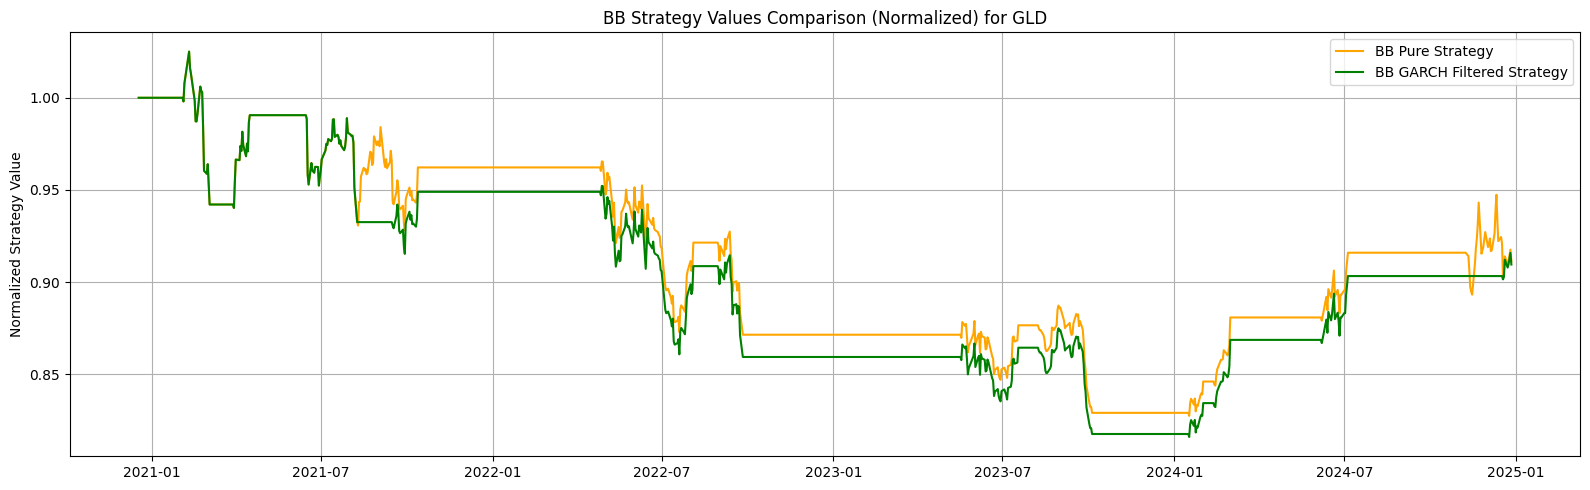

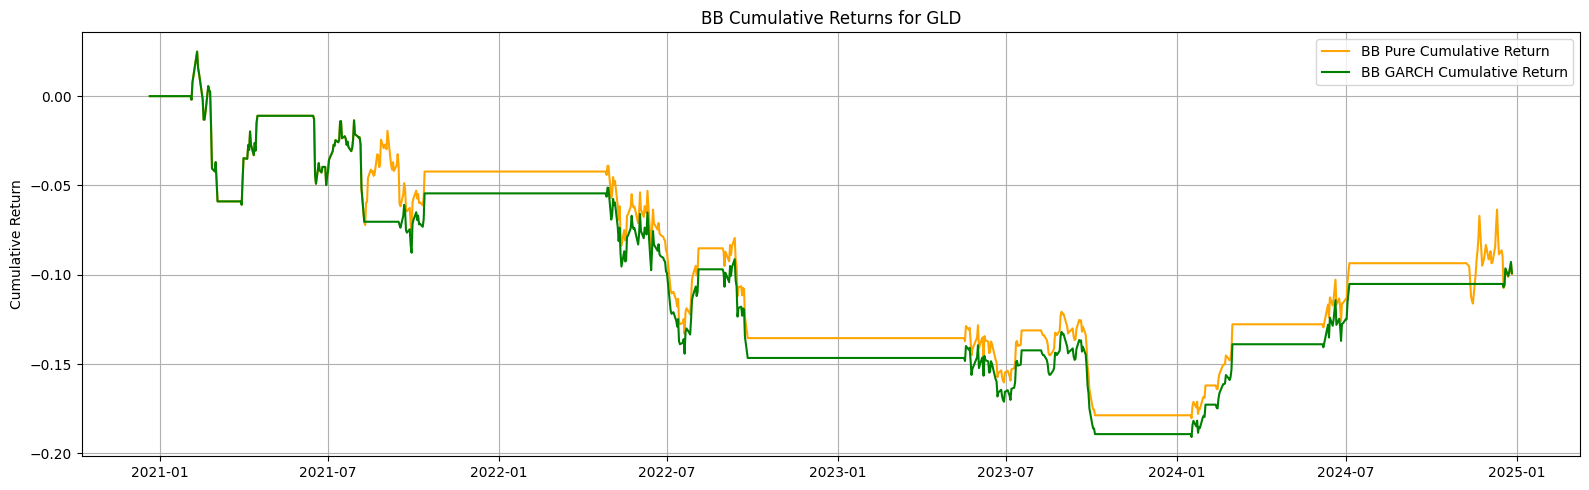

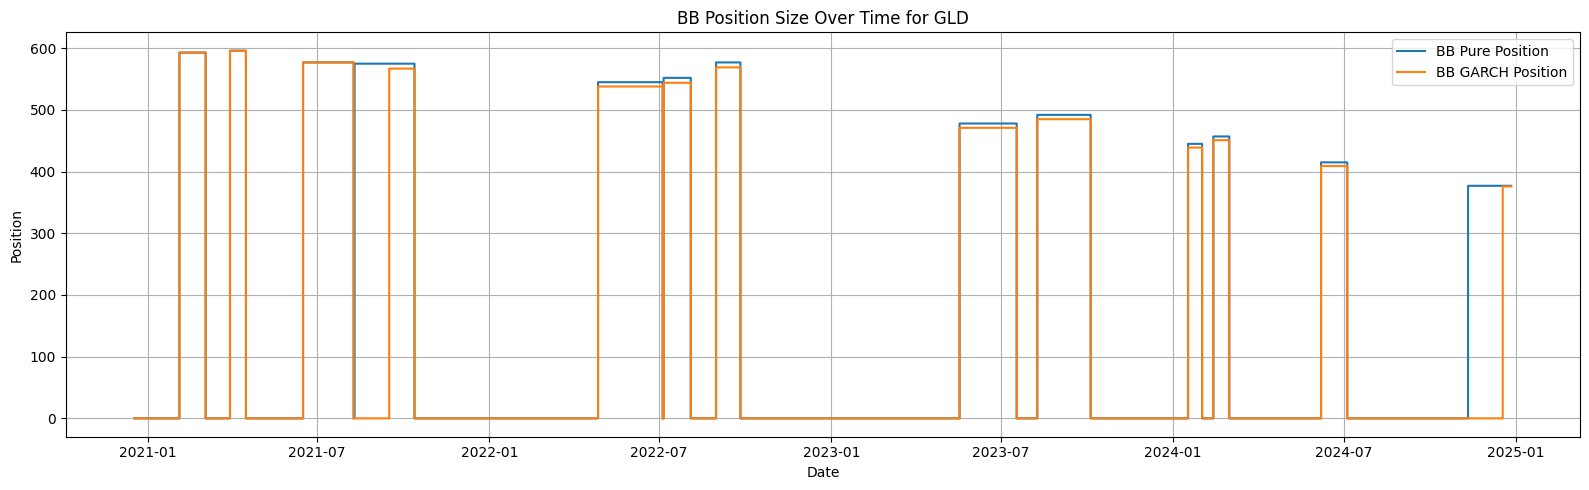

In [28]:
def plot_bollinger_compare_strategies(test_df, bb_pure_bt, bb_garch_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = bb_pure_bt['bb_pure_5_20_strategy_value'] / bb_pure_bt['bb_pure_5_20_strategy_value'].iloc[0]
    norm_garch = bb_garch_bt['bb_garch_5_20_strategy_value'] / bb_garch_bt['bb_garch_5_20_strategy_value'].iloc[0]
    plt.plot(bb_pure_bt.index, norm_pure, label='BB Pure Strategy', color='orange')
    plt.plot(bb_garch_bt.index, norm_garch, label='BB GARCH Filtered Strategy', color='green')
    plt.title(f'BB Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + bb_pure_bt['bb_pure_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + bb_garch_bt['bb_garch_5_20_strategy_return']).cumprod() - 1
    plt.plot(bb_pure_bt.index, cumret_pure, label='BB Pure Cumulative Return', color='orange')
    plt.plot(bb_garch_bt.index, cumret_garch, label='BB GARCH Cumulative Return', color='green')
    plt.title(f'BB Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(bb_pure_bt.index, bb_pure_bt['bb_pure_5_20_position'], label='BB Pure Position', where='post')
    plt.step(bb_garch_bt.index, bb_garch_bt['bb_garch_5_20_position'], label='BB GARCH Position', where='post')
    plt.title(f'BB Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_bollinger_compare_strategies(test_data, bb_pure_bt, bb_garch_bt, stock_code=f'{stock_code}')


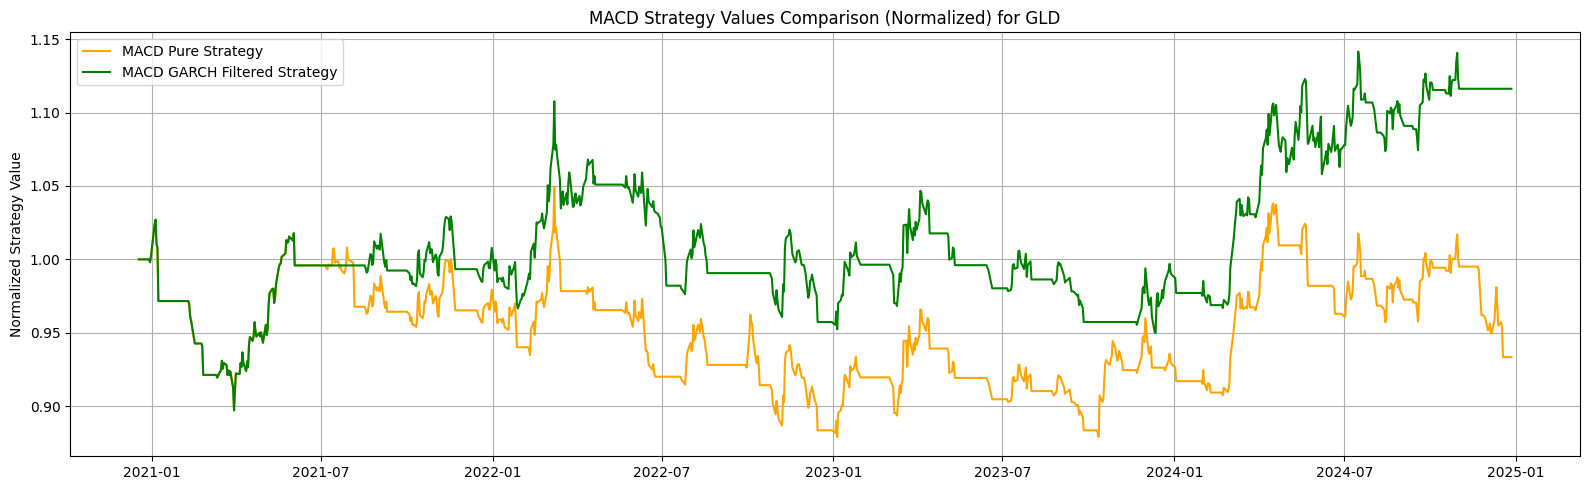

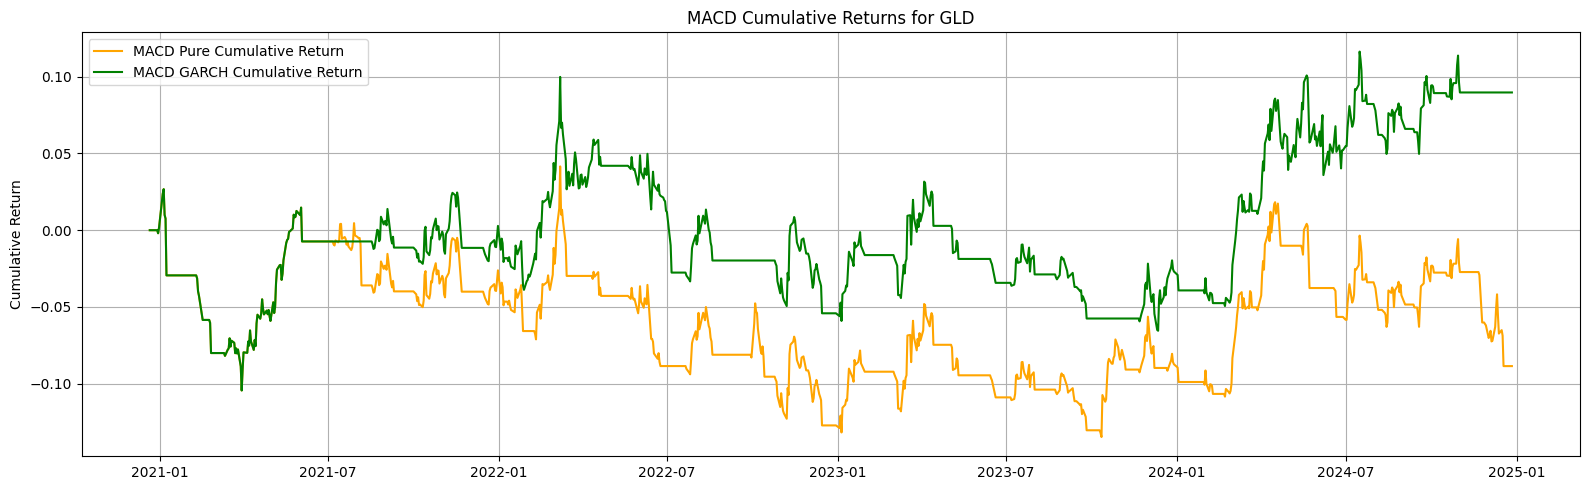

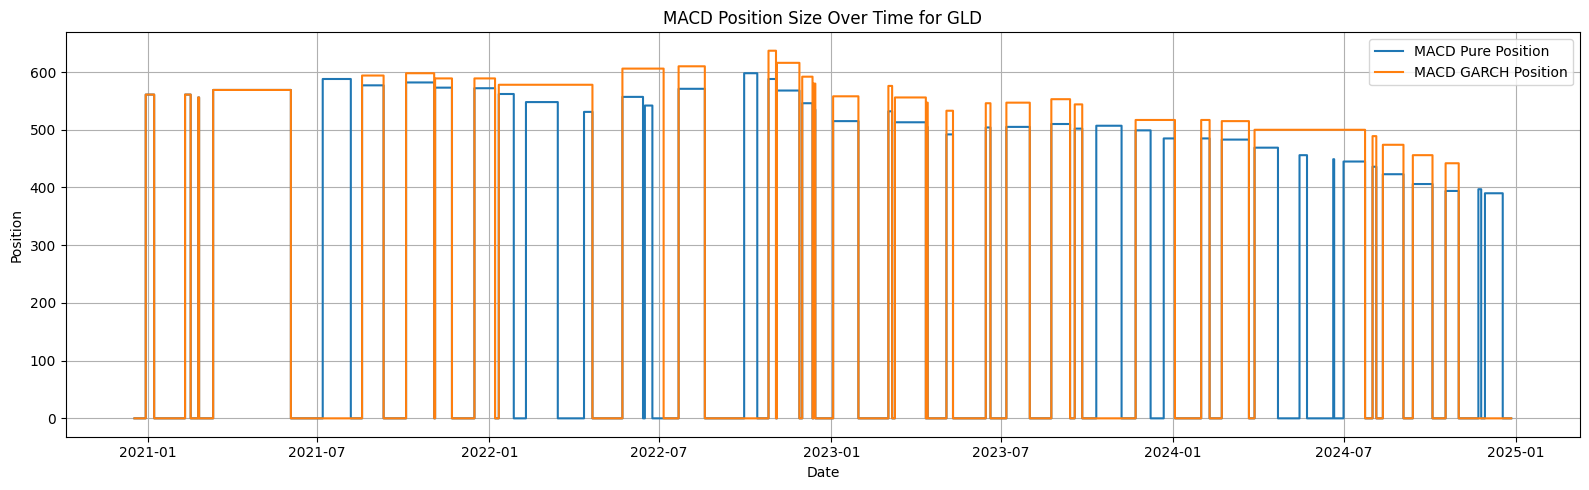

In [29]:
def plot_macd_compare_strategies(test_df, macd_pure_bt, macd_garch_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = macd_pure_bt['macd_pure_5_20_strategy_value'] / macd_pure_bt['macd_pure_5_20_strategy_value'].iloc[0]
    norm_garch = macd_garch_bt['macd_garch_5_20_strategy_value'] / macd_garch_bt['macd_garch_5_20_strategy_value'].iloc[0]
    plt.plot(macd_pure_bt.index, norm_pure, label='MACD Pure Strategy', color='orange')
    plt.plot(macd_garch_bt.index, norm_garch, label='MACD GARCH Filtered Strategy', color='green')
    plt.title(f'MACD Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + macd_pure_bt['macd_pure_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + macd_garch_bt['macd_garch_5_20_strategy_return']).cumprod() - 1
    plt.plot(macd_pure_bt.index, cumret_pure, label='MACD Pure Cumulative Return', color='orange')
    plt.plot(macd_garch_bt.index, cumret_garch, label='MACD GARCH Cumulative Return', color='green')
    plt.title(f'MACD Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(macd_pure_bt.index, macd_pure_bt['macd_pure_5_20_position'], label='MACD Pure Position', where='post')
    plt.step(macd_garch_bt.index, macd_garch_bt['macd_garch_5_20_position'], label='MACD GARCH Position', where='post')
    plt.title(f'MACD Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_macd_compare_strategies(test_data, macd_pure_bt, macd_garch_bt, stock_code=f'{stock_code}')


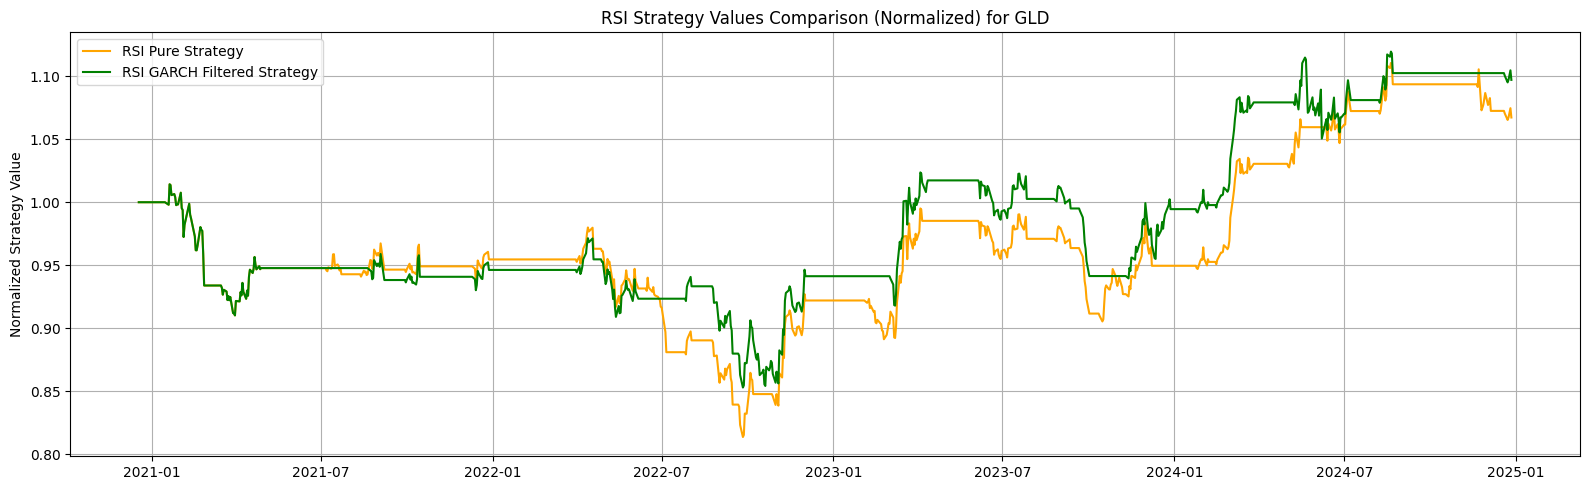

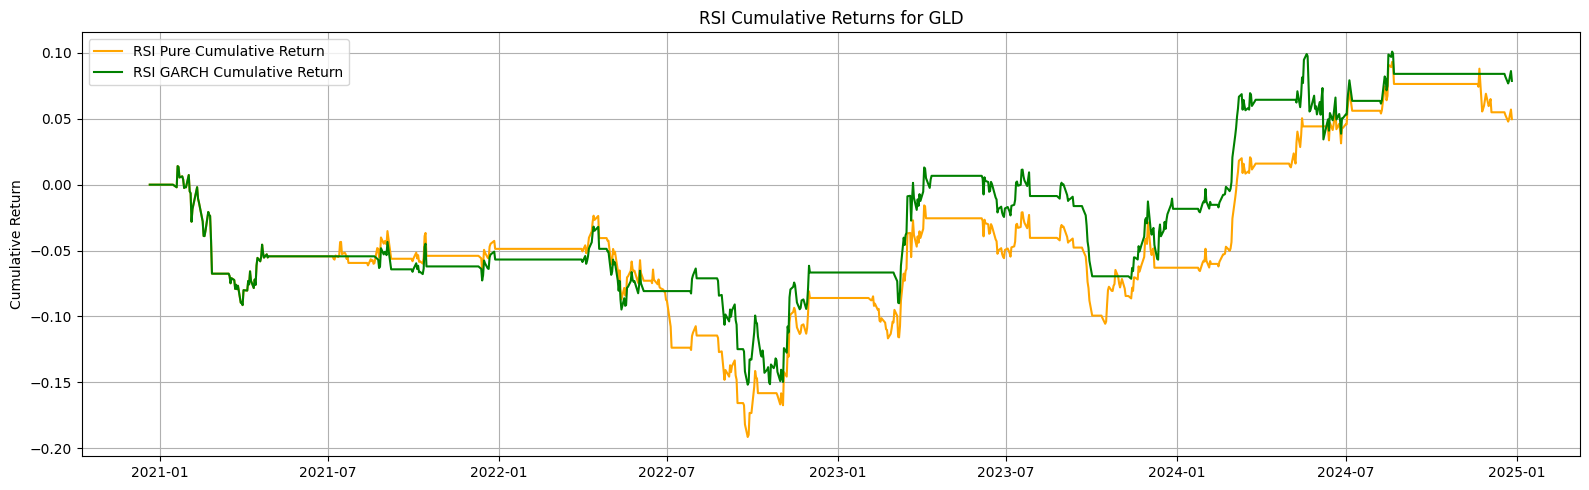

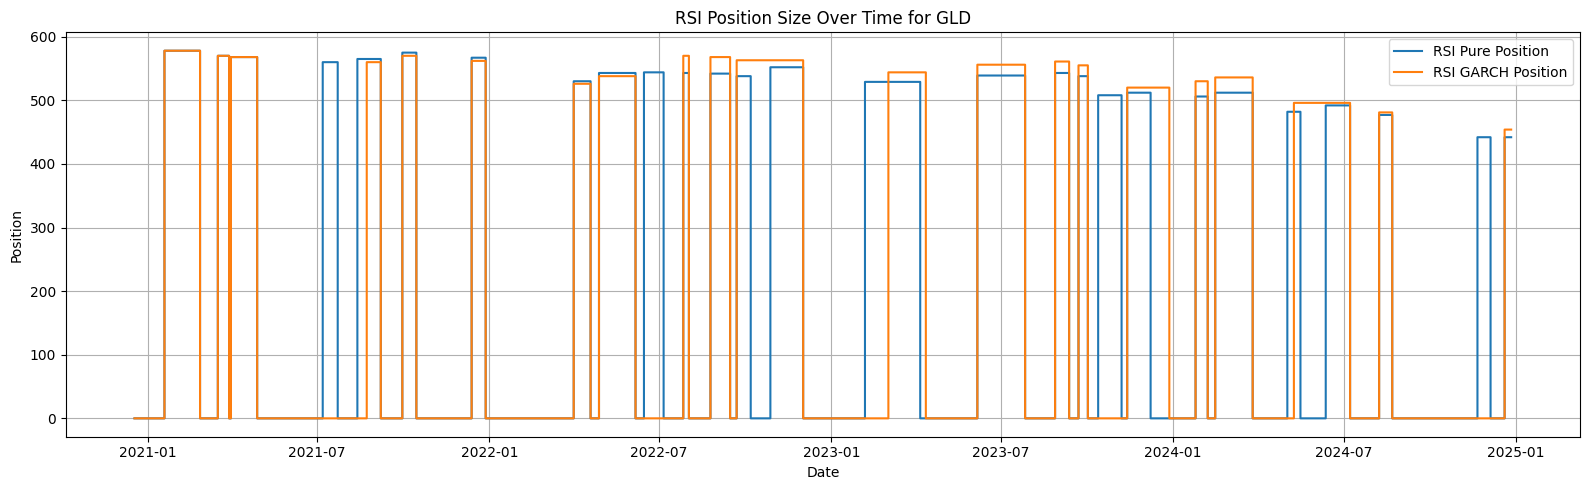

In [30]:
def plot_rsi_compare_strategies(test_df, rsi_pure_bt, rsi_garch_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = rsi_pure_bt['rsi_pure_5_20_strategy_value'] / rsi_pure_bt['rsi_pure_5_20_strategy_value'].iloc[0]
    norm_garch = rsi_garch_bt['rsi_garch_5_20_strategy_value'] / rsi_garch_bt['rsi_garch_5_20_strategy_value'].iloc[0]
    plt.plot(rsi_pure_bt.index, norm_pure, label='RSI Pure Strategy', color='orange')
    plt.plot(rsi_garch_bt.index, norm_garch, label='RSI GARCH Filtered Strategy', color='green')
    plt.title(f'RSI Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + rsi_pure_bt['rsi_pure_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + rsi_garch_bt['rsi_garch_5_20_strategy_return']).cumprod() - 1
    plt.plot(rsi_pure_bt.index, cumret_pure, label='RSI Pure Cumulative Return', color='orange')
    plt.plot(rsi_garch_bt.index, cumret_garch, label='RSI GARCH Cumulative Return', color='green')
    plt.title(f'RSI Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(rsi_pure_bt.index, rsi_pure_bt['rsi_pure_5_20_position'], label='RSI Pure Position', where='post')
    plt.step(rsi_garch_bt.index, rsi_garch_bt['rsi_garch_5_20_position'], label='RSI GARCH Position', where='post')
    plt.title(f'RSI Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage:
plot_rsi_compare_strategies(test_data, rsi_pure_bt, rsi_garch_bt, stock_code=f'{stock_code}')


## Performance

In [31]:
# Step 1: Prepare dictionary for SL/TP groups
performance_tables_by_sl_tp = {}

for prefix, perf_dict in performance_results.items():
    # Remove "_perf" suffix
    clean_prefix = prefix.replace('_perf', '')

    # Extract SL and TP from last two parts
    parts = clean_prefix.split('_')
    sl = parts[-2]  # second last part
    tp = parts[-1]  # last part
    sl_tp_key = f'SL{sl}_TP{tp}'

    # Strategy name without SL/TP
    strategy_name = '_'.join(parts[:-2])

    # Convert performance dict to DataFrame
    df_perf = pd.DataFrame([perf_dict])
    df_perf.insert(0, 'Strategy', strategy_name)

    # Append to the dictionary
    if sl_tp_key not in performance_tables_by_sl_tp:
        performance_tables_by_sl_tp[sl_tp_key] = df_perf
    else:
        performance_tables_by_sl_tp[sl_tp_key] = pd.concat(
            [performance_tables_by_sl_tp[sl_tp_key], df_perf],
            ignore_index=True
        )

# Step 2: Print all tables nicely
for key in sorted(performance_tables_by_sl_tp.keys()):
    print(f"\n=== Performance Table ({stock_code}): {key} ===\n")
    print(performance_tables_by_sl_tp[key].to_string(index=False))

# Save all SL/TP tables into one Excel file
output_path = f"performance_tables_{stock_code}_by_sl_tp_TI.xlsx"

with pd.ExcelWriter(output_path) as writer:
    for key, df in performance_tables_by_sl_tp.items():
        # Excel sheet names can't have special characters or be too long
        sheet_name = key.replace('/', '_')[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All performance tables saved to: {output_path}")



=== Performance Table (GLD): SL3_TP10 ===

     Strategy  total_return  annualized_return  annualized_volatility  sharpe_ratio  alpha_annualized_market_benchmark  alpha_annualized_asset_benchmark  sortino_ratio  calmar_ratio  max_drawdown  max_drawdown_duration  win_rate  max_win_streak  max_loss_streak  average_gain  average_loss  profit_factor  exposure  trade_count  turnover    VaR_95   CVaR_95  average_holding_days  longest_holding_days longest_holding_start longest_holding_end  shortest_holding_days shortest_holding_start shortest_holding_end
      bb_pure      0.043392           0.010644               0.085647     -0.227026                          -0.035961                         -0.036086       0.110201      0.066845     -0.159232                    840 19.683482               6               10      0.006383     -0.006138       1.034599 38.081108           32  0.031652 -0.008567 -0.014666             33.500000                   116            2021-06-18          2021-10-12  

# Machine Learning Model: RF, XGBoost, PCA + MLP

## Feature and Target Preparation

In [32]:

# -----------------------------------
# Feature and Target Preparation
# -----------------------------------
def prepare_features_targets_vol_threshold(df, multiplier=0.5):
    df = df.copy()
    ret_std = df['log_return'].std()
    threshold = multiplier * ret_std
    print(f"Volatility-based threshold set to: {threshold:.6f}")
    df['future_return'] = df['log_return'].shift(-1)
    target = pd.Series(0, index=df.index)
    target[df['future_return'] > threshold] = 1
    target[df['future_return'] < -threshold] = -1

    # Feature engineering
    df['macd_signal_change'] = df['macd_signal_line'] - df['macd_signal_line'].shift(1)
    df['macd_hist'] = df['macd_line'] - df['macd_signal_line']
    df['macd_hist_change'] = df['macd_hist'] - df['macd_hist'].shift(1)
    df['macd_hist_trend'] = (df['macd_hist_change'] > 0).astype(int)

    df['rsi_change'] = df['rsi'] - df['rsi'].shift(1)
    df['rsi_overbought'] = (df['rsi'] > 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] < 30).astype(int)

    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['momentum'] = df['log_return'] - df['log_return'].shift(1)
    df['garch_volatility_change'] = df['garch_volatility'] - df['garch_volatility'].shift(1)

    df['ema_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
    df['ema_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()
    df['ema_cross_up'] = ((df['ema_10'] > df['ema_50']) & (df['ema_10'].shift(1) <= df['ema_50'].shift(1))).astype(int)
    df['ema_cross_down'] = ((df['ema_10'] < df['ema_50']) & (df['ema_10'].shift(1) >= df['ema_50'].shift(1))).astype(int)

    df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Adj Close'], window=14)
    df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Adj Close'], window=14)

    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20)

    window = 10
    df['ret_roll_mean'] = df['log_return'].rolling(window).mean()
    df['ret_roll_std'] = df['log_return'].rolling(window).std()
    df['ret_roll_skew'] = df['log_return'].rolling(window).skew()
    df['ret_roll_kurt'] = df['log_return'].rolling(window).kurt()

    features = pd.DataFrame({
        'bb_middle': df['bb_middle'].shift(1),
        'bb_upper': df['bb_upper'].shift(1),
        'bb_lower': df['bb_lower'].shift(1),
        'bb_width': df['bb_width'].shift(1),
        'macd_line': df['macd_line'].shift(1),
        'macd_signal_line': df['macd_signal_line'].shift(1),
        'macd_signal_change': df['macd_signal_change'].shift(1),
        'macd_hist': df['macd_hist'].shift(1),
        'macd_hist_change': df['macd_hist_change'].shift(1),
        'macd_hist_trend': df['macd_hist_trend'].shift(1),
        'rsi': df['rsi'].shift(1),
        'rsi_change': df['rsi_change'].shift(1),
        'rsi_overbought': df['rsi_overbought'].shift(1),
        'rsi_oversold': df['rsi_oversold'].shift(1),
        'garch_volatility': df['garch_volatility'].shift(1),
        'garch_volatility_change': df['garch_volatility_change'].shift(1),
        'log_return': df['log_return'].shift(1),
        'momentum': df['momentum'].shift(1),
        'jump_flag': df['jump_flag'].shift(1),
        'ema_cross_up': df['ema_cross_up'].shift(1),
        'ema_cross_down': df['ema_cross_down'].shift(1),
        'adx': df['adx'].shift(1),
        'atr': df['atr'].shift(1),
        'stoch_k': df['stoch_k'].shift(1),
        'stoch_d': df['stoch_d'].shift(1),
        'cci': df['cci'].shift(1),
        'ret_roll_skew': df['ret_roll_skew'].shift(1),
        'ret_roll_kurt': df['ret_roll_kurt'].shift(1)
    })

    features = features.dropna()
    target = target.loc[features.index]

    return features, target, threshold


## Random Forest

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


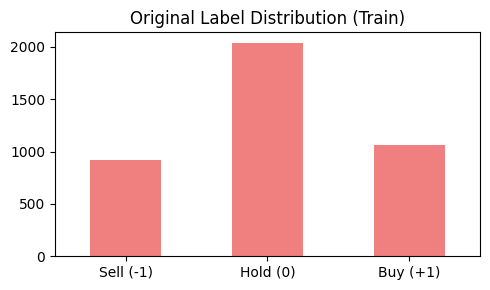

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best CV accuracy: 0.4879

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.39      0.04      0.08       256
           0       0.46      0.82      0.59       445
           1       0.30      0.18      0.22       291

    accuracy                           0.43       992
   macro avg       0.38      0.34      0.29       992
weighted avg       0.39      0.43      0.35       992

Performance Metrics:
{'accuracy': 0.4284274193548387, 'precision_macro': 0.38374535479034755, 'recall_macro': 0.34465227301247153, 'f1_macro': 0.29489593004497294}


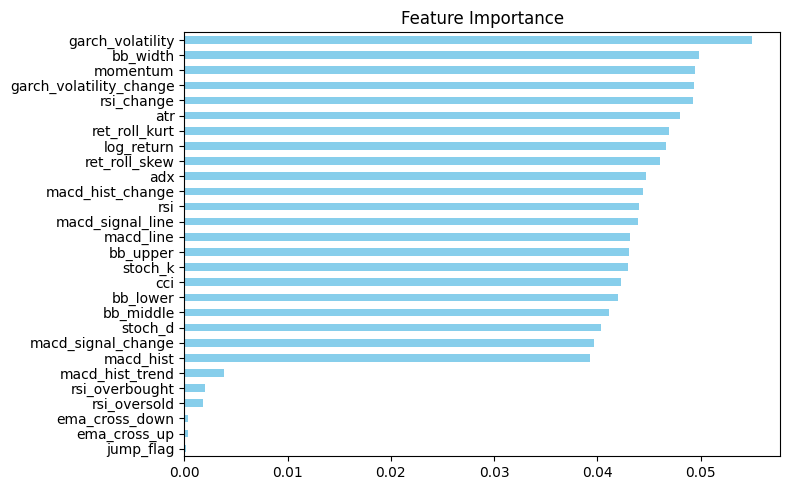

In [33]:
# -----------------------------------
# Main Pipeline
# -----------------------------------

# 1. Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold(test_data)

# 2. Map labels for classifier
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# 3. Plot original label distribution
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()


# 7. Random Forest + RandomizedSearchCV with TimeSeriesSplit
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 8, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
tscv = TimeSeriesSplit(n_splits=5)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,  #
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train_mapped)

# 8. Evaluate
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_rf = random_search.best_estimator_
rf_y_pred_mapped = best_rf.predict(X_test)
rf_y_pred = pd.Series(rf_y_pred_mapped).map(inverse_label_mapping)

# 9. Save metrics
metrics = {
    "accuracy": accuracy_score(y_test, rf_y_pred),
    "precision_macro": precision_score(y_test, rf_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, rf_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, rf_y_pred, average='macro')
}
print("\nClassification Report (Test Set):")
print(classification_report(y_test, rf_y_pred))
print("Performance Metrics:")
print(metrics)

# 10. Feature importance plot
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [34]:
def backtest_trading_strategy_ml(
    df,
    signal_col,
    value_col_prefix='ml',
    garch_col='garch_volatility',
    risk_window=50,
    risk_percentile=0.75,
    max_position=1,
    initial_capital=100000,
    transaction_cost=0.001,
    slippage_pct=0.001,
    stop_loss_pct=0.05,
    take_profit_pct=0.2,
    post_jump_delay=3
):
    df = df.copy()

    # Append SL/TP to prefix for unique column names
    value_col_prefix = f"{value_col_prefix}_{int(stop_loss_pct*100)}_{int(take_profit_pct*100)}_"

    # === Risk Filter using GARCH ===
    if garch_col:
        vol_threshold = df[garch_col].rolling(risk_window).quantile(risk_percentile).shift(1)
        df['filtered_signal'] = df[signal_col]
        df.loc[df[garch_col] >= vol_threshold, 'filtered_signal'] = 0
    else:
        df['filtered_signal'] = df[signal_col]

    cash = initial_capital
    position = 0
    position_entries = []  # list of dicts: {'price', 'shares', 'index'}
    trade_log = []
    strategy_value = []
    position_history = []
    cash_history = []
    signal_history = []

    total_cost_pct = transaction_cost + slippage_pct

    # Precompute rolling max jump flags shifted by 1 to avoid lookahead bias
    if 'jump_flag' in df.columns:
        df['recent_jump'] = df['jump_flag'].rolling(window=post_jump_delay, min_periods=1).max().shift(1).fillna(0)
    else:
        df['recent_jump'] = 0

    for i in range(len(df)):
        date = df.index[i]
        price = df.iloc[i]['Adj Close']
        raw_signal = df.iloc[i]['filtered_signal']
        recent_jump = df.iloc[i]['recent_jump']
        exited_entries = []
        net_signal = 0

        # === Buy logic with jump delay filter ===
        if raw_signal == 1 and len(position_entries) < max_position and recent_jump == 0:
            shares = int(cash / (price * (1 + total_cost_pct)))
            if shares > 0:
                cost = shares * price * (1 + total_cost_pct)
                cash -= cost
                position_entries.append({'price': price, 'shares': shares, 'index': i})
                position += shares
                trade_log.append((date, 'BUY', shares, price, cost))
                net_signal += shares

        # === Check SL/TP on each open entry ===
        for entry in position_entries:
            entry_price = entry['price']
            shares_held = entry['shares']
            sl_triggered = stop_loss_pct is not None and price <= entry_price * (1 - stop_loss_pct)
            tp_triggered = take_profit_pct is not None and price >= entry_price * (1 + take_profit_pct)

            if sl_triggered:
                exited_entries.append((entry, 'stop_loss'))
            elif tp_triggered:
                exited_entries.append((entry, 'take_profit'))

        # === Exit entries via SL/TP ===
        for exit_entry, reason in exited_entries:
            shares_to_sell = exit_entry['shares']
            proceeds = shares_to_sell * price * (1 - total_cost_pct)
            cash += proceeds
            position -= shares_to_sell
            trade_log.append((date, 'SELL', shares_to_sell, price, proceeds, reason))
            position_entries.remove(exit_entry)
            net_signal -= shares_to_sell

        # === Sell signal: exit all positions ===
        if raw_signal == -1 and position > 0:
            total_shares = sum(e['shares'] for e in position_entries)
            proceeds = total_shares * price * (1 - total_cost_pct)
            cash += proceeds
            trade_log.append((date, 'SELL', total_shares, price, proceeds, 'sell_signal'))
            position_entries.clear()
            position = 0
            net_signal -= total_shares

        # === Track performance ===
        strategy_value.append(cash + position * price)
        position_history.append(position)
        cash_history.append(cash)
        signal_history.append(net_signal)

    # === Build result DataFrame ===
    result_df = pd.DataFrame(index=df.index)
    result_df['Adj Close'] = df['Adj Close']
    result_df[f'{value_col_prefix}position'] = position_history
    result_df[f'{value_col_prefix}cash'] = cash_history
    result_df[f'{value_col_prefix}strategy_value'] = strategy_value
    result_df[f'{value_col_prefix}signal'] = signal_history
    result_df[f'{value_col_prefix}log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    result_df[f'{value_col_prefix}strategy_return'] = np.log(
        result_df[f'{value_col_prefix}strategy_value'] /
        result_df[f'{value_col_prefix}strategy_value'].shift(1)
    )

    return result_df, trade_log


In [35]:
# Create Series with correct index
rf_y_pred_mapped_series = pd.Series(rf_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
rf_y_pred_signals = rf_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['rf_nofs_predicted_ml_signal'] = rf_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['rf_nofs_predicted_ml_signal'] = test_data['rf_nofs_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['rf_nofs_predicted_ml_signal'].value_counts().sort_index())


rf_nofs_predicted_ml_signal
-1     28
 0    815
 1    169
Name: count, dtype: int64


In [36]:
rf_nofs_bt, rf_nofs_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_nofs_predicted_ml_signal',
                                                       value_col_prefix='rf_nofs')

rf_nofs_nogarch_bt, rf_nofs_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_nofs_predicted_ml_signal',
                                                       value_col_prefix='rf_nofs_nogarch',garch_col=None)


rf_nofs_perf = evaluate_strategy(
    rf_nofs_bt,
    value_col='rf_nofs_5_20_strategy_value',
    return_col='rf_nofs_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_nofs_5_20_position',
    verbose=True
)

rf_nofs_nogarch_perf = evaluate_strategy(
    rf_nofs_nogarch_bt,
    value_col='rf_nofs_nogarch_5_20_strategy_value',
    return_col='rf_nofs_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_nofs_nogarch_5_20_position',
    verbose=True
)



Strategy Performance Summary for rf_nofs_5_20_strategy_value:
Total return:            16.35%
Annualized return:       3.85%
Annualized volatility:   12.32%
Sharpe ratio:            0.06
Jensen's alpha (market benchmark): -2.57%
Jensen's alpha (asset benchmark):  -2.73%
Sortino ratio:           0.39
Calmar ratio:            0.24
Max drawdown:            -15.76%
Max drawdown duration:   280 days
Win rate:                38.97%
Max win streak:          9 trades
Max loss streak:         8 trades
Average gain:            0.0067
Average loss:            -0.0069
Profit factor:           1.06
Exposure time:           73.29%
Trade count:             26
Turnover:                2.57%
VaR (95%):               -0.0132
CVaR (95%):              -0.0193
Average holding period:  81.08 days
Longest holding:         428 days (2021-03-09 00:00:00 to 2022-05-11 00:00:00)
Shortest holding:        2 days (2022-05-17 00:00:00 to 2022-05-19 00:00:00)

Strategy Performance Summary for rf_nofs_nogarch_5_20_st

In [ ]:
# ML strategies: with GARCH and without
rf_strategies = [
    ('rf_nofs', 'rf_nofs_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('rf_nofs_nogarch', 'rf_nofs_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in rf_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## XGBoost

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


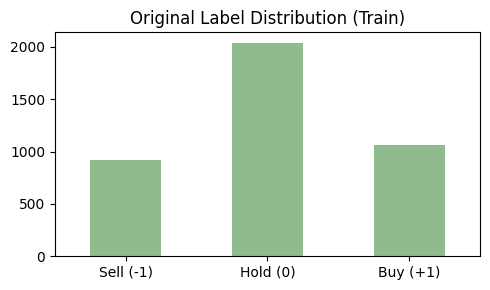

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:01:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV accuracy: 0.6919

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.23      0.04      0.07       256
           0       0.45      0.80      0.58       445
           1       0.29      0.15      0.20       291

    accuracy                           0.41       992
   macro avg       0.32      0.33      0.28       992
weighted avg       0.35      0.41      0.33       992

Performance Metrics:
{'accuracy': 0.41431451612903225, 'precision_macro': 0.32217447632571905, 'recall_macro': 0.33123389175257734, 'f1_macro': 0.28119385060205276}


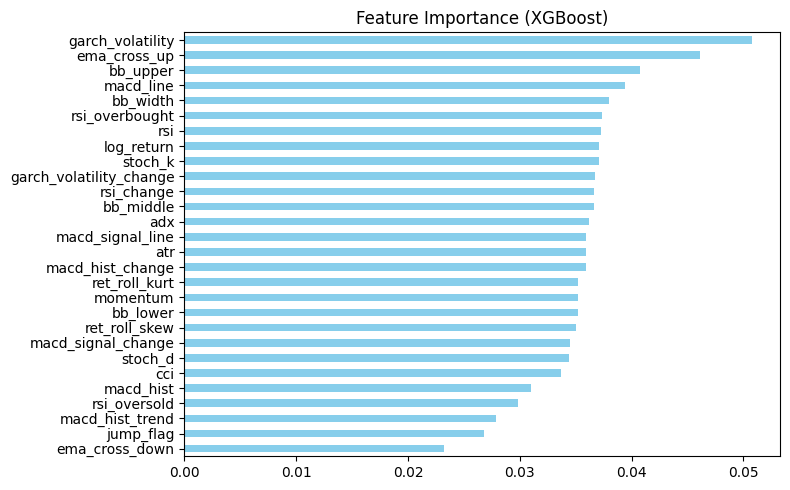

In [38]:
# -----------------------------------
# 1. Prepare features and targets
# -----------------------------------
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold(test_data)

# -----------------------------------
# 2. Map labels for classifier
# -----------------------------------
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# -----------------------------------
# 3. Plot label distribution
# -----------------------------------
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='darkseagreen')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()

# -----------------------------------
# 4. Oversample minority classes
# -----------------------------------
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train_mapped)


# -----------------------------------
# 6. XGBoost + RandomizedSearchCV
# -----------------------------------
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_os, y_train_os)

# -----------------------------------
# 7. Evaluate
# -----------------------------------
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_xgb = random_search.best_estimator_
xgb_y_pred_mapped = best_xgb.predict(X_test)
xgb_y_pred = pd.Series(xgb_y_pred_mapped).map(inverse_label_mapping)

# -----------------------------------
# 8. Save metrics
# -----------------------------------
xgb_metrics = {
    "accuracy": accuracy_score(y_test, xgb_y_pred),
    "precision_macro": precision_score(y_test, xgb_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, xgb_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, xgb_y_pred, average='macro')
}

print("\nClassification Report (Test Set):")
print(classification_report(y_test, xgb_y_pred))
print("Performance Metrics:")
print(xgb_metrics)

# -----------------------------------
# 9. Feature importance plot
# -----------------------------------
feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train_os.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


In [39]:
# Create Series with correct index
xgb_y_pred_mapped_series = pd.Series(xgb_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
xgb_y_pred_signals = xgb_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['xgb_nofs_predicted_ml_signal'] = xgb_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['xgb_nofs_predicted_ml_signal'] = test_data['xgb_nofs_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['xgb_nofs_predicted_ml_signal'].value_counts().sort_index())


xgb_nofs_predicted_ml_signal
-1     44
 0    813
 1    155
Name: count, dtype: int64


In [40]:
xgb_nofs_bt, xgb_nofs_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_nofs_predicted_ml_signal', value_col_prefix='xgb_nofs')

xgb_nofs_nogarch_bt, xgb_nofs_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_nofs_predicted_ml_signal', value_col_prefix='xgb_nofs_nogarch',garch_col=None)


xgb_nofs_perf = evaluate_strategy(
    xgb_nofs_bt,
    value_col='xgb_nofs_5_20_strategy_value',
    return_col='xgb_nofs_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_nofs_5_20_position',
    verbose=True
)


xgb_nofs_nogarch_perf = evaluate_strategy(
    xgb_nofs_nogarch_bt,
    value_col='xgb_nofs_nogarch_5_20_strategy_value',
    return_col='xgb_nofs_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_nofs_nogarch_5_20_position',
    verbose=True
)



Strategy Performance Summary for xgb_nofs_5_20_strategy_value:
Total return:            6.09%
Annualized return:       1.49%
Annualized volatility:   11.93%
Sharpe ratio:            -0.13
Jensen's alpha (market benchmark): -4.58%
Jensen's alpha (asset benchmark):  -4.72%
Sortino ratio:           0.15
Calmar ratio:            0.06
Max drawdown:            -25.25%
Max drawdown duration:   838 days
Win rate:                35.31%
Max win streak:          9 trades
Max loss streak:         10 trades
Average gain:            0.0069
Average loss:            -0.0065
Profit factor:           1.02
Exposure time:           69.93%
Trade count:             46
Turnover:                4.55%
VaR (95%):               -0.0124
CVaR (95%):              -0.0185
Average holding period:  43.26 days
Longest holding:         288 days (2023-02-16 00:00:00 to 2023-12-01 00:00:00)
Shortest holding:        1 days (2022-05-10 00:00:00 to 2022-05-11 00:00:00)

Strategy Performance Summary for xgb_nofs_nogarch_5_20

In [ ]:
# ML strategies: with GARCH and without
xgb_strategies = [
    ('xgb_nofs', 'xgb_nofs_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('xgb_nofs_nogarch', 'xgb_nofs_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in xgb_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## MLP

In [42]:
# Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold(test_data)

# Save original feature names (optional for later analysis)
feature_names = X_train.columns

# Label mapping
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# === Standard Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === SMOTE ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_mapped)

# === Hyperparameter Grid ===
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [1e-5, 0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

mlp_clf = MLPClassifier(
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42,
    verbose=False
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=mlp_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# === Fit Model ===
random_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

best_mlp = random_search.best_estimator_

# === Predict on Test Set ===
mlp_y_pred_mapped = best_mlp.predict(X_test_scaled)
mlp_y_pred = pd.Series(mlp_y_pred_mapped).map(inverse_label_mapping)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, mlp_y_pred, zero_division=0))
print("Test Accuracy:", accuracy_score(y_test, mlp_y_pred))

print("\nPrediction distribution:", collections.Counter(mlp_y_pred))


Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'solver': 'lbfgs', 'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 100), 'batch_size': 64, 'alpha': 0.001, 'activation': 'relu'}
Best CV Accuracy: 0.5947

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.24      0.16      0.19       256
           0       0.45      0.62      0.52       445
           1       0.25      0.18      0.21       291

    accuracy                           0.37       992
   macro avg       0.31      0.32      0.31       992
weighted avg       0.34      0.37      0.35       992

Test Accuracy: 0.3719758064516129

Prediction distribution: Counter({0: 611, 1: 208, -1: 173})


In [43]:
# Create Series with correct index
mlp_y_pred_mapped_series = pd.Series(mlp_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
mlp_y_pred_signals = mlp_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['mlp_predicted_ml_signal'] = mlp_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['mlp_predicted_ml_signal'] = test_data['mlp_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['mlp_predicted_ml_signal'].value_counts().sort_index())


mlp_predicted_ml_signal
-1    173
 0    631
 1    208
Name: count, dtype: int64


In [44]:
mlp_bt, mlp_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_predicted_ml_signal',
                                                       value_col_prefix='mlp')

mlp_nogarch_bt, mlp_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_predicted_ml_signal',
                                                       value_col_prefix='mlp_nogarch',garch_col=None)

mlp_perf = evaluate_strategy(
    mlp_bt,
    value_col='mlp_5_20_strategy_value',
    return_col='mlp_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_5_20_position',
    verbose=True
)

mlp_nogarch_perf = evaluate_strategy(
    mlp_nogarch_bt,
    value_col='mlp_nogarch_5_20_strategy_value',
    return_col='mlp_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_nogarch_5_20_position',
    verbose=True
)



Strategy Performance Summary for mlp_5_20_strategy_value:
Total return:            -11.51%
Annualized return:       -3.00%
Annualized volatility:   10.57%
Sharpe ratio:            -0.57
Jensen's alpha (market benchmark): -8.18%
Jensen's alpha (asset benchmark):  -8.28%
Sortino ratio:           -0.32
Calmar ratio:            -0.15
Max drawdown:            -19.79%
Max drawdown duration:   4 days
Win rate:                25.82%
Max win streak:          9 trades
Max loss streak:         8 trades
Average gain:            0.0069
Average loss:            -0.0062
Profit factor:           0.94
Exposure time:           51.14%
Trade count:             112
Turnover:                11.08%
VaR (95%):               -0.0119
CVaR (95%):              -0.0170
Average holding period:  12.02 days
Longest holding:         55 days (2022-02-02 00:00:00 to 2022-03-29 00:00:00)
Shortest holding:        0 days (2021-04-22 00:00:00 to 2021-04-22 00:00:00)

Strategy Performance Summary for mlp_nogarch_5_20_strate

In [ ]:
# ML strategies: with GARCH and without
mlp_strategies = [
    ('mlp', 'mlp_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('mlp_nogarch', 'mlp_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in mlp_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


# ML WIth Feature Selection

## RF with Feature Selection

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


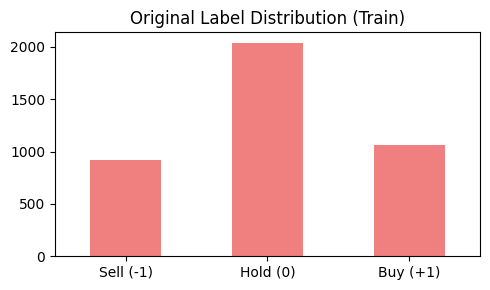


Selected 22 features above importance threshold 0.0100
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best CV accuracy: 0.4817

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.32      0.02      0.04       256
           0       0.45      0.83      0.59       445
           1       0.30      0.16      0.21       291

    accuracy                           0.43       992
   macro avg       0.36      0.34      0.28       992
weighted avg       0.37      0.43      0.34       992

Performance Metrics:
{'accuracy': 0.4264112903225806, 'precision_macro': 0.3558274084589874, 'recall_macro': 0.33840698884770326, 'f1_macro': 0.27913441770858927}


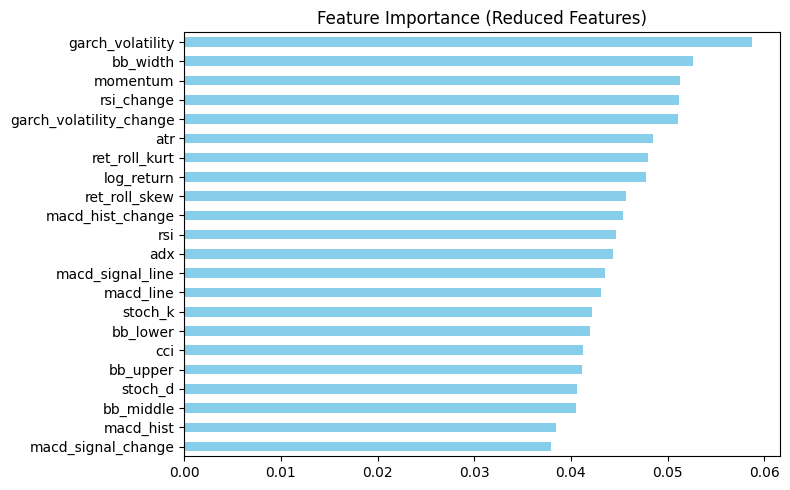

In [46]:
# -----------------------------------
# Feature Selection Function
# -----------------------------------
def select_important_features(X_train, y_train, X_test, threshold=0.01):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    important_features = importances[importances > threshold].index.tolist()
    print(f"\nSelected {len(important_features)} features above importance threshold {threshold:.4f}")
    return X_train[important_features], X_test[important_features], important_features

# -----------------------------------
# Main Pipeline
# -----------------------------------

# 1. Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold(test_data)

# 2. Map labels for classifier
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# 3. Plot original label distribution
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()


# 6. Feature selection based on RF importance
X_train_reduced, X_test_reduced, selected_features = select_important_features(
    X_train, y_train_mapped, X_test, threshold=0.01
)

# 7. Random Forest + RandomizedSearchCV with TimeSeriesSplit
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 8, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
tscv = TimeSeriesSplit(n_splits=5)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,  #
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_reduced, y_train_mapped)

# 8. Evaluate
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_rf = random_search.best_estimator_
rf_y_pred_mapped = best_rf.predict(X_test_reduced)
rf_y_pred = pd.Series(rf_y_pred_mapped).map(inverse_label_mapping)

# 9. Save metrics
metrics = {
    "accuracy": accuracy_score(y_test, rf_y_pred),
    "precision_macro": precision_score(y_test, rf_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, rf_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, rf_y_pred, average='macro')
}
print("\nClassification Report (Test Set):")
print(classification_report(y_test, rf_y_pred))
print("Performance Metrics:")
print(metrics)

# 10. Feature importance plot
feat_importances = pd.Series(best_rf.feature_importances_, index=selected_features)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (Reduced Features)")
plt.tight_layout()
plt.show()


In [47]:
# Create Series with correct index
rf_y_pred_mapped_series = pd.Series(rf_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
rf_y_pred_signals = rf_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['rf_predicted_ml_signal'] = rf_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['rf_predicted_ml_signal'] = test_data['rf_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['rf_predicted_ml_signal'].value_counts().sort_index())


rf_predicted_ml_signal
-1     19
 0    839
 1    154
Name: count, dtype: int64


In [48]:
rf_bt, rf_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_predicted_ml_signal', value_col_prefix='rf')

rf_nogarch_bt, rf_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_predicted_ml_signal', value_col_prefix='rf_nogarch',garch_col=None)


rf_perf = evaluate_strategy(
    rf_bt,
    value_col='rf_5_20_strategy_value',
    return_col='rf_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_5_20_position',
    verbose=True
)

rf_nogarch_perf = evaluate_strategy(
    rf_nogarch_bt,
    value_col='rf_nogarch_5_20_strategy_value',
    return_col='rf_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_nogarch_5_20_position',
    verbose=True
)



Strategy Performance Summary for rf_5_20_strategy_value:
Total return:            21.51%
Annualized return:       4.98%
Annualized volatility:   13.25%
Sharpe ratio:            0.14
Jensen's alpha (market benchmark): -2.06%
Jensen's alpha (asset benchmark):  -2.23%
Sortino ratio:           0.51
Calmar ratio:            0.24
Max drawdown:            -21.03%
Max drawdown duration:   519 days
Win rate:                47.48%
Max win streak:          9 trades
Max loss streak:         9 trades
Average gain:            0.0066
Average loss:            -0.0068
Profit factor:           1.07
Exposure time:           90.21%
Trade count:             14
Turnover:                1.38%
VaR (95%):               -0.0145
CVaR (95%):              -0.0200
Average holding period:  187.71 days
Longest holding:         570 days (2021-03-01 00:00:00 to 2022-09-22 00:00:00)
Shortest holding:        1 days (2024-08-22 00:00:00 to 2024-08-23 00:00:00)

Strategy Performance Summary for rf_nogarch_5_20_strategy_va

In [ ]:
# ML strategies: with GARCH and without
rf_fs_strategies = [
    ('rf', 'rf_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('rf_nogarch', 'rf_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in rf_fs_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## XGBoost With Feature Selection

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


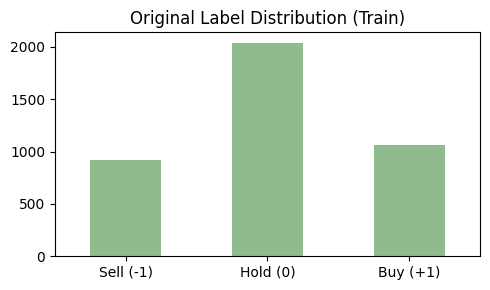


Selected 22 features above importance threshold 0.0100
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [23:35:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV accuracy: 0.6909

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.30      0.06      0.10       256
           0       0.46      0.82      0.59       445
           1       0.32      0.16      0.22       291

    accuracy                           0.43       992
   macro avg       0.36      0.35      0.30       992
weighted avg       0.38      0.43      0.35       992

Performance Metrics:
{'accuracy': 0.43044354838709675, 'precision_macro': 0.3598653198653199, 'recall_macro': 0.34717324389937837, 'f1_macro': 0.3014156349686196}


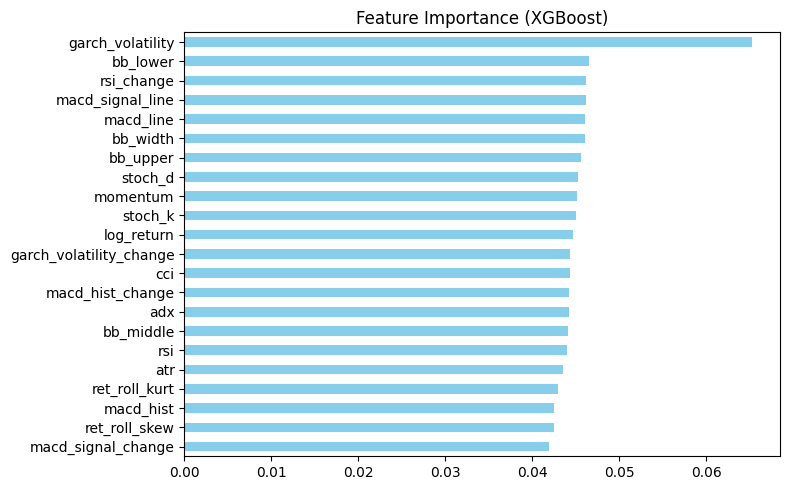

In [50]:
# -----------------------------------
# 1. Prepare features and targets
# -----------------------------------
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold(test_data)

# -----------------------------------
# 2. Map labels for classifier
# -----------------------------------
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# -----------------------------------
# 3. Plot label distribution
# -----------------------------------
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='darkseagreen')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()

# -----------------------------------
# 4. Oversample minority classes
# -----------------------------------
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train_mapped)

# -----------------------------------
# 5. Feature selection
# -----------------------------------
X_train_reduced, X_test_reduced, selected_features = select_important_features(
    X_train_os, y_train_os, X_test, threshold=0.01
)

# -----------------------------------
# 6. XGBoost + RandomizedSearchCV
# -----------------------------------
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_reduced, y_train_os)

# -----------------------------------
# 7. Evaluate
# -----------------------------------
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_xgb = random_search.best_estimator_
xgb_y_pred_mapped = best_xgb.predict(X_test_reduced)
xgb_y_pred = pd.Series(xgb_y_pred_mapped).map(inverse_label_mapping)

# -----------------------------------
# 8. Save metrics
# -----------------------------------
xgb_metrics = {
    "accuracy": accuracy_score(y_test, xgb_y_pred),
    "precision_macro": precision_score(y_test, xgb_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, xgb_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, xgb_y_pred, average='macro')
}

print("\nClassification Report (Test Set):")
print(classification_report(y_test, xgb_y_pred))
print("Performance Metrics:")
print(xgb_metrics)

# -----------------------------------
# 9. Feature importance plot
# -----------------------------------
feat_importances = pd.Series(best_xgb.feature_importances_, index=selected_features)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


In [51]:
# Create Series with correct index
xgb_y_pred_mapped_series = pd.Series(xgb_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
xgb_y_pred_signals = xgb_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['xgb_predicted_ml_signal'] = xgb_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['xgb_predicted_ml_signal'] = test_data['xgb_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['xgb_predicted_ml_signal'].value_counts().sort_index())


xgb_predicted_ml_signal
-1     50
 0    812
 1    150
Name: count, dtype: int64


In [52]:
xgb_bt, xgb_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_predicted_ml_signal', value_col_prefix='xgb')

xgb_nogarch_bt, xgb_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_predicted_ml_signal', value_col_prefix='xgb_nogarch',garch_col=None)


xgb_perf = evaluate_strategy(
    xgb_bt,
    value_col='xgb_5_20_strategy_value',
    return_col='xgb_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_5_20_position',
    verbose=True
)

xgb_nogarch_perf = evaluate_strategy(
    xgb_nogarch_bt,
    value_col='xgb_nogarch_5_20_strategy_value',
    return_col='xgb_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_nogarch_5_20_position',
    verbose=True
)




Strategy Performance Summary for xgb_5_20_strategy_value:
Total return:            4.15%
Annualized return:       1.02%
Annualized volatility:   11.77%
Sharpe ratio:            -0.17
Jensen's alpha (market benchmark): -4.87%
Jensen's alpha (asset benchmark):  -5.07%
Sortino ratio:           0.11
Calmar ratio:            0.05
Max drawdown:            -22.05%
Max drawdown duration:   521 days
Win rate:                32.84%
Max win streak:          9 trades
Max loss streak:         9 trades
Average gain:            0.0070
Average loss:            -0.0066
Profit factor:           1.02
Exposure time:           64.89%
Trade count:             55
Turnover:                5.44%
VaR (95%):               -0.0125
CVaR (95%):              -0.0184
Average holding period:  33.96 days
Longest holding:         295 days (2023-02-09 00:00:00 to 2023-12-01 00:00:00)
Shortest holding:        0 days (2022-07-28 00:00:00 to 2022-07-28 00:00:00)

Strategy Performance Summary for xgb_nogarch_5_20_strategy_v

In [ ]:
# ML strategies: with GARCH and without
xgb_fs_strategies = [
    ('xgb', 'xgb_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('xgb_nogarch', 'xgb_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in xgb_fs_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## MLP + PCA

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


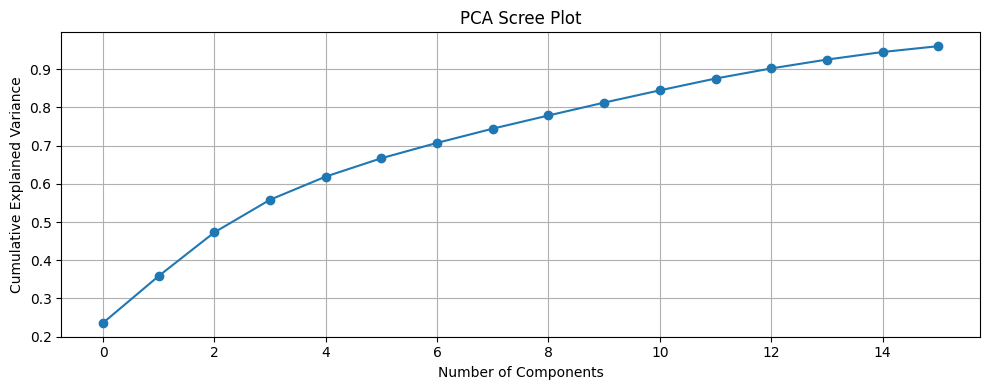


Explained Variance Ratio (first 10 components):
[0.2361 0.1227 0.1142 0.0854 0.0606 0.048  0.0401 0.0372 0.0345 0.0337]
Number of PCA components retained: 16


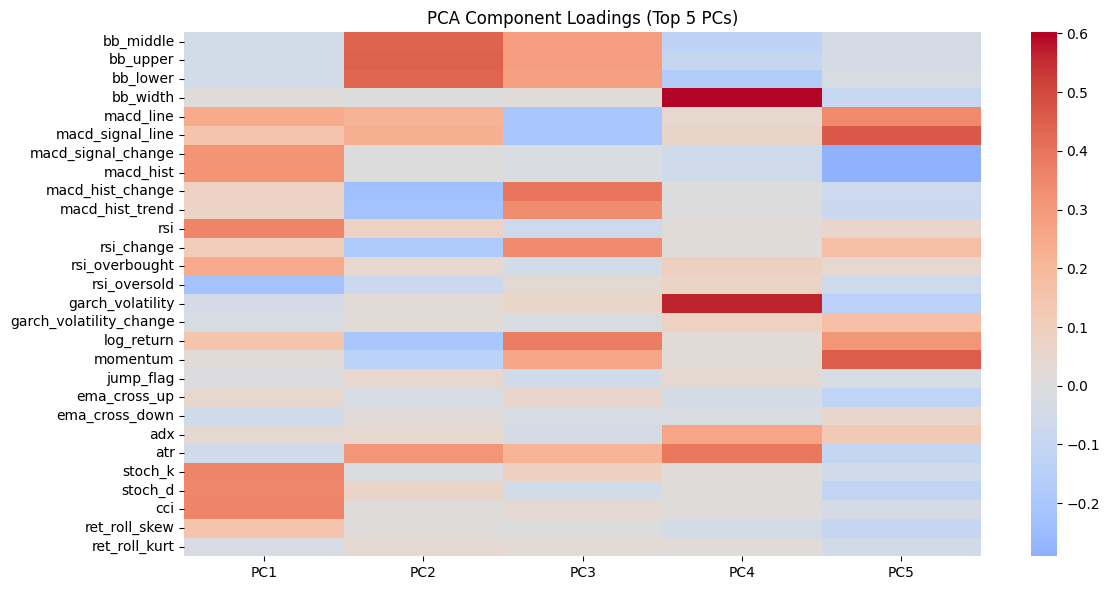

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'solver': 'lbfgs', 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
Best CV Accuracy: 0.5986

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.26      0.24      0.25       256
           0       0.45      0.53      0.49       445
           1       0.28      0.22      0.25       291

    accuracy                           0.37       992
   macro avg       0.33      0.33      0.33       992
weighted avg       0.35      0.37      0.36       992

Test Accuracy: 0.3659274193548387

Prediction distribution: Counter({0: 519, -1: 238, 1: 235})


In [54]:
# Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold(test_data)

# Save original feature names for PCA plotting
feature_names = X_train.columns

# Label mapping
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# === Standard Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === PCA ===
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

# print explained variance
print("\nExplained Variance Ratio (first 10 components):")
print(np.round(pca.explained_variance_ratio_[:10], 4))

#print number of component retained
print("Number of PCA components retained:", pca.n_components_)

# PCA Component Loadings Heatmap (first 5 components)
loading_matrix = pca.components_[:5]  # First 5 components
loading_df = pd.DataFrame(data=loading_matrix.T,
                          index=feature_names,
                          columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(12, 6))
sns.heatmap(loading_df, cmap='coolwarm', center=0, annot=False)
plt.title("PCA Component Loadings (Top 5 PCs)")
plt.tight_layout()
plt.show()

# === SMOTE ===
smote = SMOTE(random_state=42)
X_train_pca_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train_mapped)

# === Hyperparameter Grid ===
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [1e-5, 0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

mlp_pca_clf = MLPClassifier(
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42,
    verbose=False
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=mlp_pca_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# === Fit Model ===
random_search.fit(X_train_pca_resampled, y_train_resampled)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

best_mlp_pca = random_search.best_estimator_

# === Predict on Test Set ===
mlp_pca_y_pred_mapped = best_mlp_pca.predict(X_test_pca)
mlp_pca_y_pred = pd.Series(mlp_pca_y_pred_mapped).map(inverse_label_mapping)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, mlp_pca_y_pred, zero_division=0))
print("Test Accuracy:", accuracy_score(y_test, mlp_pca_y_pred))

print("\nPrediction distribution:", collections.Counter(mlp_pca_y_pred))


In [55]:
# Create Series with correct index
mlp_pca_y_pred_mapped_series = pd.Series(mlp_pca_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
mlp_pca_y_pred_signals = mlp_pca_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['mlp_pca_predicted_ml_signal'] = mlp_pca_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['mlp_pca_predicted_ml_signal'] = test_data['mlp_pca_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['mlp_pca_predicted_ml_signal'].value_counts().sort_index())


mlp_pca_predicted_ml_signal
-1    238
 0    539
 1    235
Name: count, dtype: int64


In [56]:
mlp_pca_bt, mlp_pca_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_pca_predicted_ml_signal',
                                                       value_col_prefix='mlp_pca')

mlp_pca_nogarch_bt, mlp_pca_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_pca_predicted_ml_signal',
                                                       value_col_prefix='mlp_pca_nogarch',garch_col=None)


mlp_pca_perf = evaluate_strategy(
    mlp_pca_bt,
    value_col='mlp_pca_5_20_strategy_value',
    return_col='mlp_pca_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_pca_5_20_position',
    verbose=True
)

mlp_pca_nogarch_perf = evaluate_strategy(
    mlp_pca_nogarch_bt,
    value_col='mlp_pca_nogarch_5_20_strategy_value',
    return_col='mlp_pca_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_pca_nogarch_5_20_position',
    verbose=True
)




Strategy Performance Summary for mlp_pca_5_20_strategy_value:
Total return:            -2.67%
Annualized return:       -0.67%
Annualized volatility:   10.30%
Sharpe ratio:            -0.36
Jensen's alpha (market benchmark): -5.77%
Jensen's alpha (asset benchmark):  -5.94%
Sortino ratio:           -0.07
Calmar ratio:            -0.04
Max drawdown:            -16.00%
Max drawdown duration:   669 days
Win rate:                25.32%
Max win streak:          7 trades
Max loss streak:         8 trades
Average gain:            0.0068
Average loss:            -0.0059
Profit factor:           0.98
Exposure time:           49.36%
Trade count:             122
Turnover:                12.07%
VaR (95%):               -0.0103
CVaR (95%):              -0.0166
Average holding period:  10.23 days
Longest holding:         66 days (2022-01-25 00:00:00 to 2022-04-01 00:00:00)
Shortest holding:        0 days (2021-05-04 00:00:00 to 2021-05-04 00:00:00)

Strategy Performance Summary for mlp_pca_nogarch_5_

In [ ]:
# ML strategies: with GARCH and without
mlp_pca_strategies = [
    ('mlp_pca', 'mlp_pca_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('mlp_pca_nogarch', 'mlp_pca_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in mlp_pca_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


# ML With adding signal

## Feature and Target Preparation adding signal

In [58]:

# -----------------------------------
# Feature and Target Preparation
# -----------------------------------
def prepare_features_targets_vol_threshold_with_signal(df, multiplier=0.5):
    df = df.copy()
    ret_std = df['log_return'].std()
    threshold = multiplier * ret_std
    print(f"Volatility-based threshold set to: {threshold:.6f}")
    df['future_return'] = df['log_return'].shift(-1)
    target = pd.Series(0, index=df.index)
    target[df['future_return'] > threshold] = 1
    target[df['future_return'] < -threshold] = -1

    # Feature engineering
    df['macd_signal_change'] = df['macd_signal_line'] - df['macd_signal_line'].shift(1)
    df['macd_hist'] = df['macd_line'] - df['macd_signal_line']
    df['macd_hist_change'] = df['macd_hist'] - df['macd_hist'].shift(1)
    df['macd_hist_trend'] = (df['macd_hist_change'] > 0).astype(int)

    df['rsi_change'] = df['rsi'] - df['rsi'].shift(1)
    df['rsi_overbought'] = (df['rsi'] > 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] < 30).astype(int)

    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['momentum'] = df['log_return'] - df['log_return'].shift(1)
    df['garch_volatility_change'] = df['garch_volatility'] - df['garch_volatility'].shift(1)

    df['ema_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
    df['ema_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()
    df['ema_cross_up'] = ((df['ema_10'] > df['ema_50']) & (df['ema_10'].shift(1) <= df['ema_50'].shift(1))).astype(int)
    df['ema_cross_down'] = ((df['ema_10'] < df['ema_50']) & (df['ema_10'].shift(1) >= df['ema_50'].shift(1))).astype(int)

    df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Adj Close'], window=14)
    df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Adj Close'], window=14)

    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Adj Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=20)

    window = 10
    df['ret_roll_mean'] = df['log_return'].rolling(window).mean()
    df['ret_roll_std'] = df['log_return'].rolling(window).std()
    df['ret_roll_skew'] = df['log_return'].rolling(window).skew()
    df['ret_roll_kurt'] = df['log_return'].rolling(window).kurt()

    features = pd.DataFrame({
        'bb_middle': df['bb_middle'].shift(1),
        'bb_upper': df['bb_upper'].shift(1),
        'bb_lower': df['bb_lower'].shift(1),
        'bb_width': df['bb_width'].shift(1),
        'macd_line': df['macd_line'].shift(1),
        'macd_signal_line': df['macd_signal_line'].shift(1),
        'macd_signal_change': df['macd_signal_change'].shift(1),
        'macd_hist': df['macd_hist'].shift(1),
        'macd_hist_change': df['macd_hist_change'].shift(1),
        'macd_hist_trend': df['macd_hist_trend'].shift(1),
        'rsi': df['rsi'].shift(1),
        'rsi_change': df['rsi_change'].shift(1),
        'rsi_overbought': df['rsi_overbought'].shift(1),
        'rsi_oversold': df['rsi_oversold'].shift(1),
        'garch_volatility': df['garch_volatility'].shift(1),
        'garch_volatility_change': df['garch_volatility_change'].shift(1),
        'log_return': df['log_return'].shift(1),
        'momentum': df['momentum'].shift(1),
        'jump_flag': df['jump_flag'].shift(1),
        'ema_cross_up': df['ema_cross_up'].shift(1),
        'ema_cross_down': df['ema_cross_down'].shift(1),
        'adx': df['adx'].shift(1),
        'atr': df['atr'].shift(1),
        'stoch_k': df['stoch_k'].shift(1),
        'stoch_d': df['stoch_d'].shift(1),
        'cci': df['cci'].shift(1),
        'ret_roll_skew': df['ret_roll_skew'].shift(1),
        'ret_roll_kurt': df['ret_roll_kurt'].shift(1),
        'bb_raw_signal': df['bb_raw_signal'].shift(1),
        'macd_raw_signal': df['macd_raw_signal'].shift(1),
        'rsi_raw_signal': df['rsi_raw_signal'].shift(1),

    })

    features = features.dropna()
    target = target.loc[features.index]

    return features, target, threshold


## RF + Sig

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


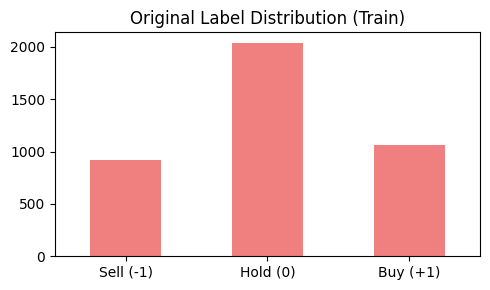

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best CV accuracy: 0.4861

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.32      0.02      0.04       256
           0       0.46      0.84      0.59       445
           1       0.30      0.16      0.21       291

    accuracy                           0.43       992
   macro avg       0.36      0.34      0.28       992
weighted avg       0.37      0.43      0.34       992

Performance Metrics:
{'accuracy': 0.4284274193548387, 'precision_macro': 0.35701162798340924, 'recall_macro': 0.34030152789039475, 'f1_macro': 0.28115524080730264}


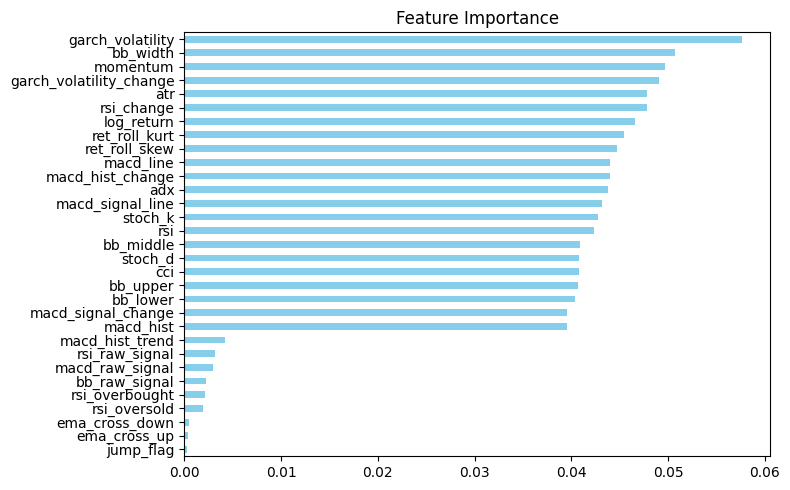

In [59]:
# -----------------------------------
# Main Pipeline
# -----------------------------------

# 1. Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold_with_signal(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold_with_signal(test_data)

# 2. Map labels for classifier
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# 3. Plot original label distribution
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()


# 7. Random Forest + RandomizedSearchCV with TimeSeriesSplit
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 8, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
tscv = TimeSeriesSplit(n_splits=5)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,  #
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train_mapped)

# 8. Evaluate
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_rf = random_search.best_estimator_
rf_y_pred_mapped = best_rf.predict(X_test)
rf_y_pred = pd.Series(rf_y_pred_mapped).map(inverse_label_mapping)

# 9. Save metrics
metrics = {
    "accuracy": accuracy_score(y_test, rf_y_pred),
    "precision_macro": precision_score(y_test, rf_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, rf_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, rf_y_pred, average='macro')
}
print("\nClassification Report (Test Set):")
print(classification_report(y_test, rf_y_pred))
print("Performance Metrics:")
print(metrics)

# 10. Feature importance plot
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [60]:
# Create Series with correct index
rf_y_pred_mapped_series = pd.Series(rf_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
rf_y_pred_signals = rf_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['rf_sig_predicted_ml_signal'] = rf_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['rf_sig_predicted_ml_signal'] = test_data['rf_sig_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['rf_sig_predicted_ml_signal'].value_counts().sort_index())


rf_sig_predicted_ml_signal
-1     19
 0    836
 1    157
Name: count, dtype: int64


In [61]:
rf_sig_bt, rf_sig_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_sig_predicted_ml_signal',
                                                     value_col_prefix='rf_sig')

rf_sig_nogarch_bt, rf_sig_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_sig_predicted_ml_signal',
                                                     value_col_prefix='rf_sig_nogarch',garch_col=None)


rf_sig_perf = evaluate_strategy(
    rf_sig_bt,
    value_col='rf_sig_5_20_strategy_value',
    return_col='rf_sig_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_sig_5_20_position',
    verbose=True
)

rf_sig_nogarch_perf = evaluate_strategy(
    rf_sig_nogarch_bt,
    value_col='rf_sig_nogarch_5_20_strategy_value',
    return_col='rf_sig_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_sig_nogarch_5_20_position',
    verbose=True
)





Strategy Performance Summary for rf_sig_5_20_strategy_value:
Total return:            21.31%
Annualized return:       4.93%
Annualized volatility:   13.25%
Sharpe ratio:            0.14
Jensen's alpha (market benchmark): -2.09%
Jensen's alpha (asset benchmark):  -2.26%
Sortino ratio:           0.51
Calmar ratio:            0.23
Max drawdown:            -21.03%
Max drawdown duration:   519 days
Win rate:                47.28%
Max win streak:          9 trades
Max loss streak:         9 trades
Average gain:            0.0066
Average loss:            -0.0068
Profit factor:           1.07
Exposure time:           89.81%
Trade count:             12
Turnover:                1.19%
VaR (95%):               -0.0145
CVaR (95%):              -0.0200
Average holding period:  218.33 days
Longest holding:         570 days (2021-03-01 00:00:00 to 2022-09-22 00:00:00)
Shortest holding:        2 days (2024-08-21 00:00:00 to 2024-08-23 00:00:00)

Strategy Performance Summary for rf_sig_nogarch_5_20_str

In [ ]:
# ML strategies: with GARCH and without
rf_sig_strategies = [
    ('rf_sig', 'rf_sig_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('rf_sig_nogarch', 'rf_sig_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in rf_sig_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## XGBoost + Sig

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


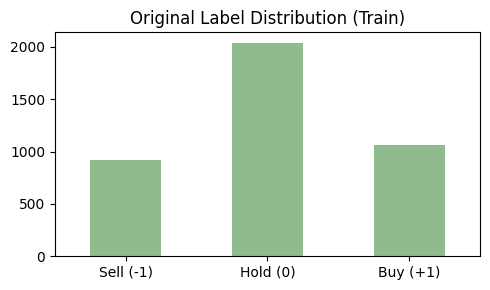

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:09:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best CV accuracy: 0.6901

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.27      0.07      0.12       256
           0       0.45      0.74      0.56       445
           1       0.30      0.20      0.24       291

    accuracy                           0.41       992
   macro avg       0.34      0.34      0.30       992
weighted avg       0.36      0.41      0.35       992

Performance Metrics:
{'accuracy': 0.40826612903225806, 'precision_macro': 0.34094964787468696, 'recall_macro': 0.33647362711880774, 'f1_macro': 0.3042201088767372}


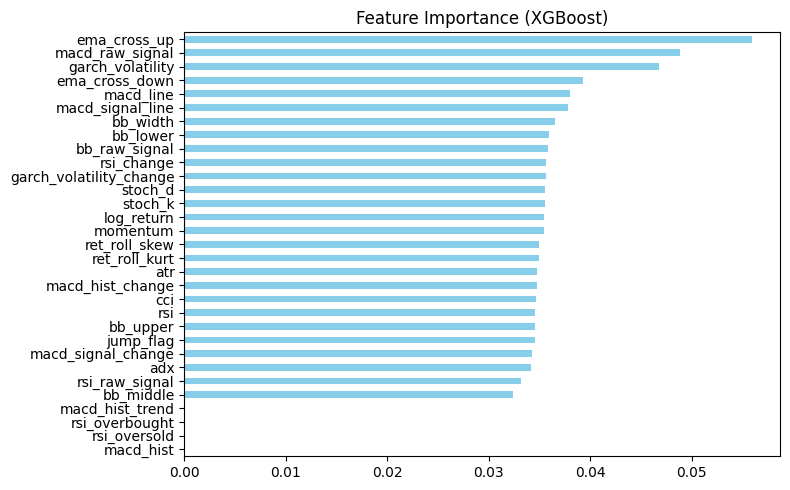

In [63]:
# -----------------------------------
# 1. Prepare features and targets
# -----------------------------------
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold_with_signal(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold_with_signal(test_data)

# -----------------------------------
# 2. Map labels for classifier
# -----------------------------------
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# -----------------------------------
# 3. Plot label distribution
# -----------------------------------
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='darkseagreen')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()

# -----------------------------------
# 4. Oversample minority classes
# -----------------------------------
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train_mapped)


# -----------------------------------
# 6. XGBoost + RandomizedSearchCV
# -----------------------------------
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_os, y_train_os)

# -----------------------------------
# 7. Evaluate
# -----------------------------------
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_xgb = random_search.best_estimator_
xgb_y_pred_mapped = best_xgb.predict(X_test)
xgb_y_pred = pd.Series(xgb_y_pred_mapped).map(inverse_label_mapping)

# -----------------------------------
# 8. Save metrics
# -----------------------------------
xgb_metrics = {
    "accuracy": accuracy_score(y_test, xgb_y_pred),
    "precision_macro": precision_score(y_test, xgb_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, xgb_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, xgb_y_pred, average='macro')
}

print("\nClassification Report (Test Set):")
print(classification_report(y_test, xgb_y_pred))
print("Performance Metrics:")
print(xgb_metrics)

# -----------------------------------
# 9. Feature importance plot
# -----------------------------------
feat_importances = pd.Series(best_xgb.feature_importances_, index=X_train_os.columns)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


In [64]:
# Create Series with correct index
xgb_y_pred_mapped_series = pd.Series(xgb_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
xgb_y_pred_signals = xgb_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['xgb_sig_predicted_ml_signal'] = xgb_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['xgb_sig_predicted_ml_signal'] = test_data['xgb_sig_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['xgb_sig_predicted_ml_signal'].value_counts().sort_index())


xgb_sig_predicted_ml_signal
-1     70
 0    754
 1    188
Name: count, dtype: int64


In [65]:
xgb_sig_bt, xgb_sig_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_sig_predicted_ml_signal', value_col_prefix='xgb_sig')

xgb_sig_nogarch_bt, xgb_sig_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_sig_predicted_ml_signal',
                                                                       value_col_prefix='xgb_sig_nogarch',garch_col=None)


xgb_sig_perf = evaluate_strategy(
    xgb_sig_bt,
    value_col='xgb_sig_5_20_strategy_value',
    return_col='xgb_sig_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_sig_5_20_position',
    verbose=True
)

xgb_sig_nogarch_perf = evaluate_strategy(
    xgb_sig_nogarch_bt,
    value_col='xgb_sig_nogarch_5_20_strategy_value',
    return_col='xgb_sig_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_sig_nogarch_5_20_position',
    verbose=True
)




Strategy Performance Summary for xgb_sig_5_20_strategy_value:
Total return:            14.88%
Annualized return:       3.52%
Annualized volatility:   11.24%
Sharpe ratio:            0.04
Jensen's alpha (market benchmark): -2.27%
Jensen's alpha (asset benchmark):  -2.45%
Sortino ratio:           0.37
Calmar ratio:            0.22
Max drawdown:            -15.69%
Max drawdown duration:   704 days
Win rate:                30.27%
Max win streak:          5 trades
Max loss streak:         7 trades
Average gain:            0.0071
Average loss:            -0.0065
Profit factor:           1.07
Exposure time:           57.96%
Trade count:             62
Turnover:                6.13%
VaR (95%):               -0.0115
CVaR (95%):              -0.0175
Average holding period:  25.94 days
Longest holding:         106 days (2024-04-01 00:00:00 to 2024-07-16 00:00:00)
Shortest holding:        0 days (2021-01-20 00:00:00 to 2021-01-20 00:00:00)

Strategy Performance Summary for xgb_sig_nogarch_5_20_st

In [ ]:
# ML strategies: with GARCH and without
xgb_sig_strategies = [
    ('xgb_sig', 'xgb_sig_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('xgb_sig_nogarch', 'xgb_sig_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in xgb_sig_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## MLP with signal

In [67]:
# Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold_with_signal(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold_with_signal(test_data)

# Save original feature names (optional for later analysis)
feature_names = X_train.columns

# Label mapping
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# === Standard Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === SMOTE ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_mapped)

# === Hyperparameter Grid ===
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [1e-5, 0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

mlp_clf = MLPClassifier(
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42,
    verbose=False
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=mlp_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# === Fit Model ===
random_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

best_mlp = random_search.best_estimator_

# === Predict on Test Set ===
mlp_y_pred_mapped = best_mlp.predict(X_test_scaled)
mlp_y_pred = pd.Series(mlp_y_pred_mapped).map(inverse_label_mapping)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, mlp_y_pred, zero_division=0))
print("Test Accuracy:", accuracy_score(y_test, mlp_y_pred))

print("\nPrediction distribution:", collections.Counter(mlp_y_pred))


Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'solver': 'lbfgs', 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 128, 'alpha': 0.01, 'activation': 'relu'}
Best CV Accuracy: 0.5945

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.28      0.16      0.20       256
           0       0.47      0.58      0.52       445
           1       0.32      0.33      0.32       291

    accuracy                           0.40       992
   macro avg       0.36      0.36      0.35       992
weighted avg       0.38      0.40      0.38       992

Test Accuracy: 0.3971774193548387

Prediction distribution: Counter({0: 548, 1: 302, -1: 142})


In [68]:
# Create Series with correct index
mlp_y_pred_mapped_series = pd.Series(mlp_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
mlp_y_pred_signals = mlp_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['mlp_sig_predicted_ml_signal'] = mlp_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['mlp_sig_predicted_ml_signal'] = test_data['mlp_sig_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['mlp_sig_predicted_ml_signal'].value_counts().sort_index())


mlp_sig_predicted_ml_signal
-1    142
 0    568
 1    302
Name: count, dtype: int64


In [69]:
mlp_sig_bt, mlp_sig_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_sig_predicted_ml_signal',
                                                       value_col_prefix='mlp_sig')


mlp_sig_nogarch_bt, mlp_sig_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_sig_predicted_ml_signal',
                                                       value_col_prefix='mlp_sig_nogarch',garch_col=None)



mlp_sig_perf = evaluate_strategy(
    mlp_sig_bt,
    value_col='mlp_sig_5_20_strategy_value',
    return_col='mlp_sig_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_sig_5_20_position',
    verbose=True
)

mlp_sig_nogarch_perf = evaluate_strategy(
    mlp_sig_nogarch_bt,
    value_col='mlp_sig_nogarch_5_20_strategy_value',
    return_col='mlp_sig_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_sig_nogarch_5_20_position',
    verbose=True
)



Strategy Performance Summary for mlp_sig_5_20_strategy_value:
Total return:            22.15%
Annualized return:       5.11%
Annualized volatility:   11.79%
Sharpe ratio:            0.17
Jensen's alpha (market benchmark): -1.09%
Jensen's alpha (asset benchmark):  -1.25%
Sortino ratio:           0.54
Calmar ratio:            0.34
Max drawdown:            -15.02%
Max drawdown duration:   525 days
Win rate:                35.51%
Max win streak:          8 trades
Max loss streak:         8 trades
Average gain:            0.0069
Average loss:            -0.0062
Profit factor:           1.09
Exposure time:           65.78%
Trade count:             120
Turnover:                11.87%
VaR (95%):               -0.0120
CVaR (95%):              -0.0182
Average holding period:  14.53 days
Longest holding:         81 days (2024-10-07 00:00:00 to 2024-12-27 00:00:00)
Shortest holding:        0 days (2021-07-20 00:00:00 to 2021-07-20 00:00:00)

Strategy Performance Summary for mlp_sig_nogarch_5_20_s

In [ ]:
# ML strategies: with GARCH and without
mlp_sig_strategies = [
    ('mlp_sig', 'mlp_sig_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('mlp_sig_nogarch', 'mlp_sig_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in mlp_sig_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


# ML With Feature Selection (Sig)

## RF with Feature Selection

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


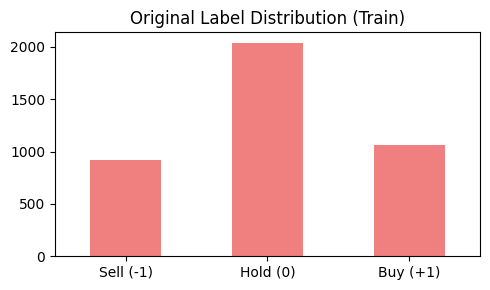


Selected 22 features above importance threshold 0.0100
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best CV accuracy: 0.4817

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.32      0.02      0.04       256
           0       0.45      0.83      0.59       445
           1       0.30      0.16      0.21       291

    accuracy                           0.43       992
   macro avg       0.36      0.34      0.28       992
weighted avg       0.37      0.43      0.34       992

Performance Metrics:
{'accuracy': 0.4264112903225806, 'precision_macro': 0.3558274084589874, 'recall_macro': 0.33840698884770326, 'f1_macro': 0.27913441770858927}


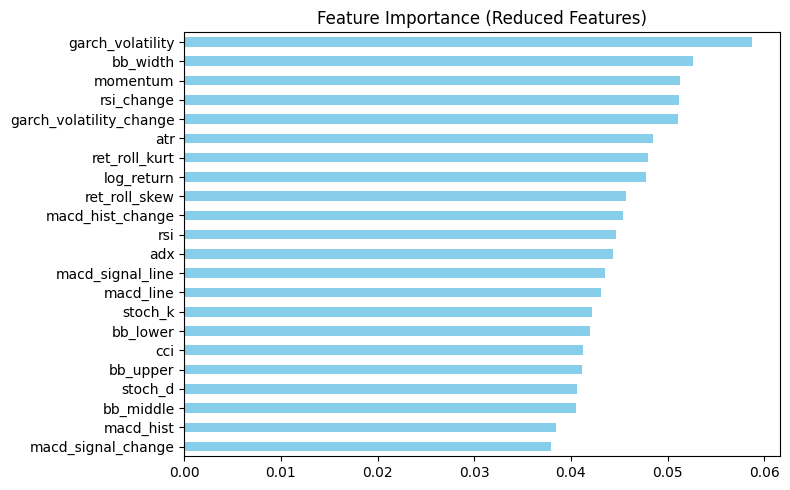

In [71]:
# -----------------------------------
# Feature Selection Function
# -----------------------------------
def select_important_features(X_train, y_train, X_test, threshold=0.01):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    important_features = importances[importances > threshold].index.tolist()
    print(f"\nSelected {len(important_features)} features above importance threshold {threshold:.4f}")
    return X_train[important_features], X_test[important_features], important_features

# -----------------------------------
# Main Pipeline
# -----------------------------------

# 1. Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold_with_signal(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold_with_signal(test_data)

# 2. Map labels for classifier
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# 3. Plot original label distribution
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()


# 6. Feature selection based on RF importance
X_train_reduced, X_test_reduced, selected_features = select_important_features(
    X_train, y_train_mapped, X_test, threshold=0.01
)

# 7. Random Forest + RandomizedSearchCV with TimeSeriesSplit
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [3, 5, 8, 12, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
tscv = TimeSeriesSplit(n_splits=5)

rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,  #
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_reduced, y_train_mapped)

# 8. Evaluate
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_rf = random_search.best_estimator_
rf_y_pred_mapped = best_rf.predict(X_test_reduced)
rf_y_pred = pd.Series(rf_y_pred_mapped).map(inverse_label_mapping)

# 9. Save metrics
metrics = {
    "accuracy": accuracy_score(y_test, rf_y_pred),
    "precision_macro": precision_score(y_test, rf_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, rf_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, rf_y_pred, average='macro')
}
print("\nClassification Report (Test Set):")
print(classification_report(y_test, rf_y_pred))
print("Performance Metrics:")
print(metrics)

# 10. Feature importance plot
feat_importances = pd.Series(best_rf.feature_importances_, index=selected_features)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (Reduced Features)")
plt.tight_layout()
plt.show()


In [72]:
# Create Series with correct index
rf_y_pred_mapped_series = pd.Series(rf_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
rf_y_pred_signals = rf_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['rf_sig_fs_predicted_ml_signal'] = rf_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['rf_sig_fs_predicted_ml_signal'] = test_data['rf_sig_fs_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['rf_sig_fs_predicted_ml_signal'].value_counts().sort_index())


rf_sig_fs_predicted_ml_signal
-1     19
 0    839
 1    154
Name: count, dtype: int64


In [73]:
rf_sig_fs_bt, rf_sig_fs_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_sig_fs_predicted_ml_signal', value_col_prefix='rf_sig_fs')

rf_sig_fs_nogarch_bt, rf_sig_fs_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'rf_sig_fs_predicted_ml_signal',
                                                                           value_col_prefix='rf_sig_fs_nogarch', garch_col = None)


rf_sig_fs_perf = evaluate_strategy(
    rf_sig_fs_bt,
    value_col='rf_sig_fs_5_20_strategy_value',
    return_col='rf_sig_fs_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_sig_fs_5_20_position',
    verbose=True
)

rf_sig_fs_nogarch_perf = evaluate_strategy(
    rf_sig_fs_nogarch_bt,
    value_col='rf_sig_fs_nogarch_5_20_strategy_value',
    return_col='rf_sig_fs_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='rf_sig_fs_nogarch_5_20_position',
    verbose=True
)



Strategy Performance Summary for rf_sig_fs_5_20_strategy_value:
Total return:            21.51%
Annualized return:       4.98%
Annualized volatility:   13.25%
Sharpe ratio:            0.14
Jensen's alpha (market benchmark): -2.06%
Jensen's alpha (asset benchmark):  -2.23%
Sortino ratio:           0.51
Calmar ratio:            0.24
Max drawdown:            -21.03%
Max drawdown duration:   519 days
Win rate:                47.48%
Max win streak:          9 trades
Max loss streak:         9 trades
Average gain:            0.0066
Average loss:            -0.0068
Profit factor:           1.07
Exposure time:           90.21%
Trade count:             14
Turnover:                1.38%
VaR (95%):               -0.0145
CVaR (95%):              -0.0200
Average holding period:  187.71 days
Longest holding:         570 days (2021-03-01 00:00:00 to 2022-09-22 00:00:00)
Shortest holding:        1 days (2024-08-22 00:00:00 to 2024-08-23 00:00:00)

Strategy Performance Summary for rf_sig_fs_nogarch_5_

In [ ]:
# ML strategies: with GARCH and without
rf_sig_fs_strategies = [
    ('rf_sig_fs', 'rf_sig_fs_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('rf_sig_fs_nogarch', 'rf_sig_fs_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in rf_sig_fs_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## XGBoost With Feature Selection

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


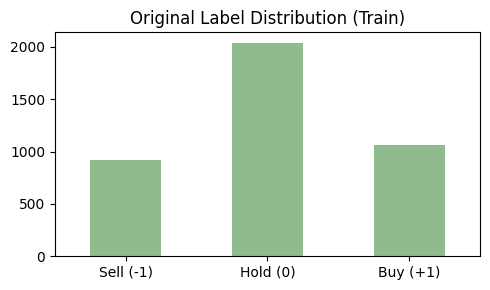


Selected 22 features above importance threshold 0.0100
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:42:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters found: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV accuracy: 0.6909

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.30      0.06      0.10       256
           0       0.46      0.82      0.59       445
           1       0.32      0.16      0.22       291

    accuracy                           0.43       992
   macro avg       0.36      0.35      0.30       992
weighted avg       0.38      0.43      0.35       992

Performance Metrics:
{'accuracy': 0.43044354838709675, 'precision_macro': 0.3598653198653199, 'recall_macro': 0.34717324389937837, 'f1_macro': 0.3014156349686196}


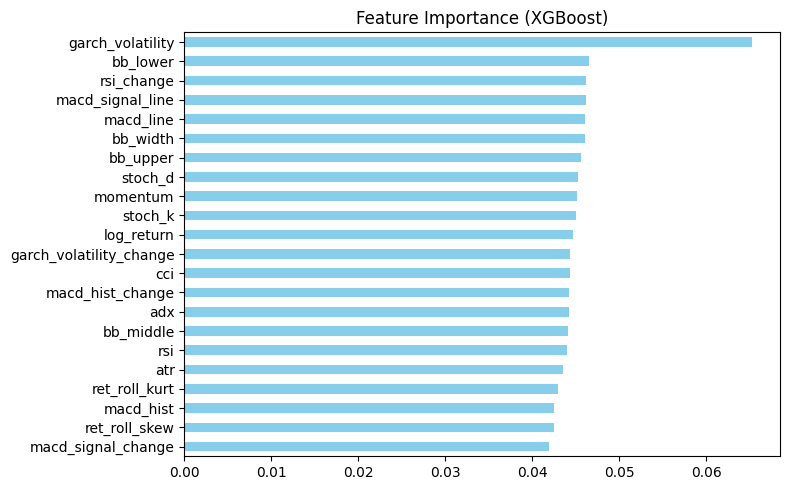

In [75]:
# -----------------------------------
# 1. Prepare features and targets
# -----------------------------------
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold_with_signal(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold_with_signal(test_data)

# -----------------------------------
# 2. Map labels for classifier
# -----------------------------------
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# -----------------------------------
# 3. Plot label distribution
# -----------------------------------
plt.figure(figsize=(5,3))
y_train_mapped.value_counts().sort_index().plot(kind='bar', color='darkseagreen')
plt.xticks(ticks=[0,1,2], labels=["Sell (-1)", "Hold (0)", "Buy (+1)"], rotation=0)
plt.title("Original Label Distribution (Train)")
plt.tight_layout()
plt.show()

# -----------------------------------
# 4. Oversample minority classes
# -----------------------------------
ros = RandomOverSampler(random_state=42)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train_mapped)

# -----------------------------------
# 5. Feature selection
# -----------------------------------
X_train_reduced, X_test_reduced, selected_features = select_important_features(
    X_train_os, y_train_os, X_test, threshold=0.01
)

# -----------------------------------
# 6. XGBoost + RandomizedSearchCV
# -----------------------------------
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_reduced, y_train_os)

# -----------------------------------
# 7. Evaluate
# -----------------------------------
print(f"\nBest parameters found: {random_search.best_params_}")
print(f"Best CV accuracy: {random_search.best_score_:.4f}")

best_xgb = random_search.best_estimator_
xgb_y_pred_mapped = best_xgb.predict(X_test_reduced)
xgb_y_pred = pd.Series(xgb_y_pred_mapped).map(inverse_label_mapping)

# -----------------------------------
# 8. Save metrics
# -----------------------------------
xgb_metrics = {
    "accuracy": accuracy_score(y_test, xgb_y_pred),
    "precision_macro": precision_score(y_test, xgb_y_pred, average='macro'),
    "recall_macro": recall_score(y_test, xgb_y_pred, average='macro'),
    "f1_macro": f1_score(y_test, xgb_y_pred, average='macro')
}

print("\nClassification Report (Test Set):")
print(classification_report(y_test, xgb_y_pred))
print("Performance Metrics:")
print(xgb_metrics)

# -----------------------------------
# 9. Feature importance plot
# -----------------------------------
feat_importances = pd.Series(best_xgb.feature_importances_, index=selected_features)
feat_importances.sort_values().plot(kind='barh', figsize=(8, 5), color='skyblue')
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


In [76]:
# Create Series with correct index
xgb_y_pred_mapped_series = pd.Series(xgb_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
xgb_y_pred_signals = xgb_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['xgb_sig_fs_predicted_ml_signal'] = xgb_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['xgb_sig_fs_predicted_ml_signal'] = test_data['xgb_sig_fs_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['xgb_sig_fs_predicted_ml_signal'].value_counts().sort_index())


xgb_sig_fs_predicted_ml_signal
-1     50
 0    812
 1    150
Name: count, dtype: int64


In [77]:
xgb_sig_fs_bt, xgb_sig_fs_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_sig_fs_predicted_ml_signal', value_col_prefix='xgb_sig_fs')

xgb_sig_fs_nogarch_bt, xgb_sig_fs_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'xgb_sig_fs_predicted_ml_signal',
                                                                             value_col_prefix='xgb_sig_fs_nogarch',garch_col=None)

xgb_sig_fs_perf = evaluate_strategy(
    xgb_sig_fs_bt,
    value_col='xgb_sig_fs_5_20_strategy_value',
    return_col='xgb_sig_fs_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_sig_fs_5_20_position',
    verbose=True
)


xgb_sig_fs_nogarch_perf = evaluate_strategy(
    xgb_sig_fs_nogarch_bt,
    value_col='xgb_sig_fs_nogarch_5_20_strategy_value',
    return_col='xgb_sig_fs_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='xgb_sig_fs_nogarch_5_20_position',
    verbose=True
)


Strategy Performance Summary for xgb_sig_fs_5_20_strategy_value:
Total return:            4.15%
Annualized return:       1.02%
Annualized volatility:   11.77%
Sharpe ratio:            -0.17
Jensen's alpha (market benchmark): -4.87%
Jensen's alpha (asset benchmark):  -5.07%
Sortino ratio:           0.11
Calmar ratio:            0.05
Max drawdown:            -22.05%
Max drawdown duration:   521 days
Win rate:                32.84%
Max win streak:          9 trades
Max loss streak:         9 trades
Average gain:            0.0070
Average loss:            -0.0066
Profit factor:           1.02
Exposure time:           64.89%
Trade count:             55
Turnover:                5.44%
VaR (95%):               -0.0125
CVaR (95%):              -0.0184
Average holding period:  33.96 days
Longest holding:         295 days (2023-02-09 00:00:00 to 2023-12-01 00:00:00)
Shortest holding:        0 days (2022-07-28 00:00:00 to 2022-07-28 00:00:00)

Strategy Performance Summary for xgb_sig_fs_nogarch_5

In [ ]:
# ML strategies: with GARCH and without
xgb_sig_fs_strategies = [
    ('xgb_sig_fs', 'xgb_sig_fs_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('xgb_sig_fs_nogarch', 'xgb_sig_fs_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in xgb_sig_fs_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


## MLP + PCA + Sig

Volatility-based threshold set to: 0.005754
Volatility-based threshold set to: 0.004515


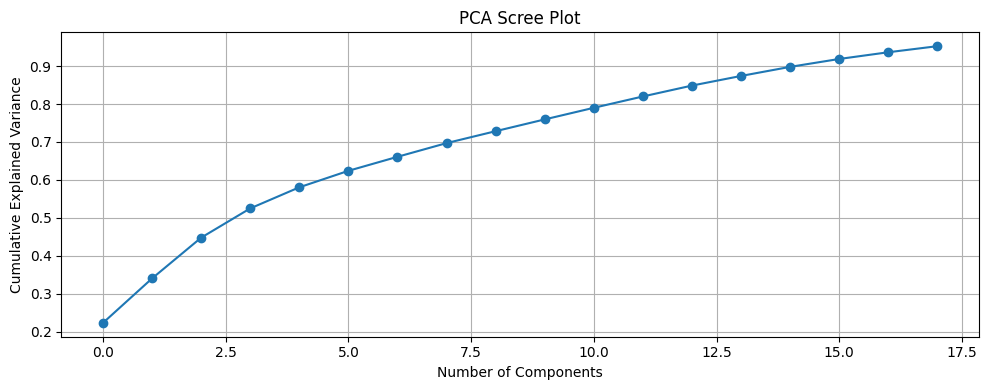


Explained Variance Ratio (first 10 components):
[0.2232 0.1172 0.1074 0.0772 0.0556 0.0434 0.037  0.0361 0.0314 0.0311]
Number of PCA components retained: 18


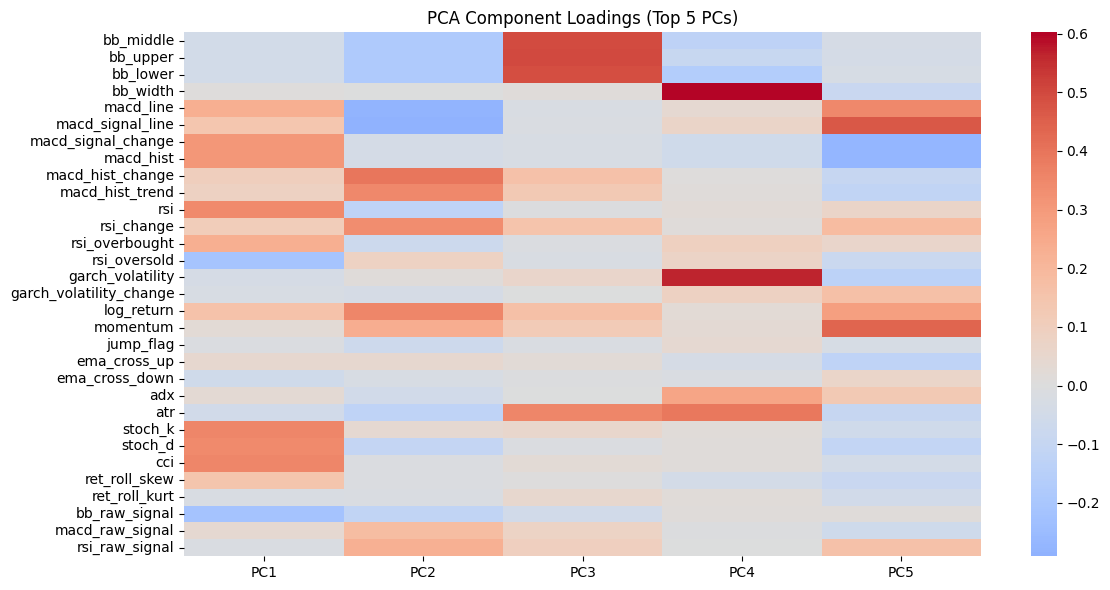

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'solver': 'lbfgs', 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'hidden_layer_sizes': (150, 100, 50), 'batch_size': 128, 'alpha': 0.01, 'activation': 'relu'}
Best CV Accuracy: 0.5988

Classification Report (Test Set):
              precision    recall  f1-score   support

          -1       0.26      0.24      0.25       256
           0       0.45      0.55      0.49       445
           1       0.30      0.21      0.25       291

    accuracy                           0.37       992
   macro avg       0.33      0.33      0.33       992
weighted avg       0.35      0.37      0.36       992

Test Accuracy: 0.3709677419354839

Prediction distribution: Counter({0: 547, -1: 235, 1: 210})


In [79]:
# Prepare features and targets
X_train, y_train, train_threshold = prepare_features_targets_vol_threshold_with_signal(train_data)
X_test, y_test, test_threshold = prepare_features_targets_vol_threshold_with_signal(test_data)

# Save original feature names for PCA plotting
feature_names = X_train.columns

# Label mapping
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

# === Standard Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === PCA ===
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Scree Plot
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

# print explained variance
print("\nExplained Variance Ratio (first 10 components):")
print(np.round(pca.explained_variance_ratio_[:10], 4))

#print number of component retained
print("Number of PCA components retained:", pca.n_components_)

# PCA Component Loadings Heatmap (first 5 components)
loading_matrix = pca.components_[:5]  # First 5 components
loading_df = pd.DataFrame(data=loading_matrix.T,
                          index=feature_names,
                          columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(12, 6))
sns.heatmap(loading_df, cmap='coolwarm', center=0, annot=False)
plt.title("PCA Component Loadings (Top 5 PCs)")
plt.tight_layout()
plt.show()

# === SMOTE ===
smote = SMOTE(random_state=42)
X_train_pca_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train_mapped)

# === Hyperparameter Grid ===
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [1e-5, 0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

mlp_pca_clf = MLPClassifier(
    max_iter=1000,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42,
    verbose=False
)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=mlp_pca_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# === Fit Model ===
random_search.fit(X_train_pca_resampled, y_train_resampled)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

best_mlp_pca = random_search.best_estimator_

# === Predict on Test Set ===
mlp_pca_y_pred_mapped = best_mlp_pca.predict(X_test_pca)
mlp_pca_y_pred = pd.Series(mlp_pca_y_pred_mapped).map(inverse_label_mapping)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, mlp_pca_y_pred, zero_division=0))
print("Test Accuracy:", accuracy_score(y_test, mlp_pca_y_pred))

print("\nPrediction distribution:", collections.Counter(mlp_pca_y_pred))


In [80]:
# Create Series with correct index
mlp_pca_y_pred_mapped_series = pd.Series(mlp_pca_y_pred_mapped, index=X_test.index)

# Map back to original labels (-1, 0, 1)
mlp_pca_y_pred_signals = mlp_pca_y_pred_mapped_series.map(inverse_label_mapping)

# Add predicted signals column to original test_data (aligned by index)
test_data['mlp_pca_sig_predicted_ml_signal'] = mlp_pca_y_pred_signals

# Fill NaNs (rows where no prediction due to shifting) with 0 (hold)
test_data['mlp_pca_sig_predicted_ml_signal'] = test_data['mlp_pca_sig_predicted_ml_signal'].fillna(0).astype(int)

# Now test_data has predicted signals for all rows, with 0 where prediction was not possible
print(test_data['mlp_pca_sig_predicted_ml_signal'].value_counts().sort_index())


mlp_pca_sig_predicted_ml_signal
-1    235
 0    567
 1    210
Name: count, dtype: int64


In [81]:
mlp_pca_sig_bt, mlp_pca_sig_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_pca_sig_predicted_ml_signal',
                                                       value_col_prefix='mlp_pca_sig')

mlp_pca_sig_nogarch_bt, mlp_pca_sig_nogarch_log = backtest_trading_strategy_ml(test_data, signal_col= 'mlp_pca_sig_predicted_ml_signal',
                                                       value_col_prefix='mlp_pca_sig_nogarch',garch_col = None)


mlp_pca_sig_perf = evaluate_strategy(
    mlp_pca_sig_bt,
    value_col='mlp_pca_sig_5_20_strategy_value',
    return_col='mlp_pca_sig_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_pca_sig_5_20_position',
    verbose=True
)



mlp_pca_sig_nogarch_perf = evaluate_strategy(
    mlp_pca_sig_nogarch_bt,
    value_col='mlp_pca_sig_nogarch_5_20_strategy_value',
    return_col='mlp_pca_sig_nogarch_5_20_strategy_return',
    benchmark_returns=benchmark['log_return'],
    asset_returns=stock_data['log_return'],
    rf_series=rf_daily_returns,
    position_col='mlp_pca_sig_nogarch_5_20_position',
    verbose=True
)


Strategy Performance Summary for mlp_pca_sig_5_20_strategy_value:
Total return:            -22.25%
Annualized return:       -6.08%
Annualized volatility:   8.81%
Sharpe ratio:            -1.05
Jensen's alpha (market benchmark): -10.43%
Jensen's alpha (asset benchmark):  -10.49%
Sortino ratio:           -0.70
Calmar ratio:            -0.23
Max drawdown:            -25.95%
Max drawdown duration:   0 days
Win rate:                20.77%
Max win streak:          7 trades
Max loss streak:         11 trades
Average gain:            0.0063
Average loss:            -0.0056
Profit factor:           0.84
Exposure time:           42.53%
Trade count:             126
Turnover:                12.46%
VaR (95%):               -0.0098
CVaR (95%):              -0.0150
Average holding period:  8.48 days
Longest holding:         44 days (2022-09-19 00:00:00 to 2022-11-02 00:00:00)
Shortest holding:        0 days (2021-02-04 00:00:00 to 2021-02-04 00:00:00)

Strategy Performance Summary for mlp_pca_sig_no

In [ ]:
# ML strategies: with GARCH and without
mlp_pca_sig_strategies = [
    ('mlp_pca_sig', 'mlp_pca_sig_predicted_ml_signal', 'garch_volatility'),  # with GARCH
    ('mlp_pca_sig_nogarch', 'mlp_pca_sig_predicted_ml_signal', None)         # without GARCH
]

for strategy_prefix, signal_col, garch_col in mlp_pca_sig_strategies:

    rp_loop = risk_percentiles if garch_col is not None else [None]

    for rp in rp_loop:
        for stop_loss in stop_loss_values:
            for take_profit in take_profit_values:

                # Construct dynamic prefix
                if garch_col is not None:
                    prefix = f"{strategy_prefix}_{int(rp*100)}_{int(stop_loss*100)}_{int(take_profit*100)}"
                else:
                    prefix = f"{strategy_prefix}_{int(stop_loss*100)}_{int(take_profit*100)}"

                if garch_col is not None:
                    # Backtest WITH GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}_{int(rp*100)}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )
                else:
                    # Backtest WITHOUT GARCH
                    bt, log = backtest_trading_strategy_ml(
                        test_data,
                        signal_col=signal_col,
                        value_col_prefix=f"{strategy_prefix}",
                        garch_col=garch_col,
                        risk_percentile=rp,
                        stop_loss_pct=stop_loss,
                        take_profit_pct=take_profit
                    )

                backtests[prefix] = bt
                logs[prefix] = log

# Evaluate all backtests dynamically
for prefix, bt in backtests.items():
    value_col = f"{prefix}_strategy_value"
    return_col = f"{prefix}_strategy_return"
    position_col = f"{prefix}_position"

    perf = evaluate_strategy(
        bt,
        value_col=value_col,
        return_col=return_col,
        benchmark_returns=benchmark['log_return'],
        asset_returns=stock_data['log_return'],
        rf_series=rf_daily_returns,
        position_col=position_col,
        verbose=True
    )

    performance_results[f'{prefix}_perf'] = perf


# Performance Evaluation

In [83]:
full_performance_table = pd.DataFrame.from_dict({
    'BB Pure': bb_pure_perf,
    'BB GARCH': bb_garch_perf,
    'MACD Pure': macd_pure_perf,
    'MACD GARCH': macd_garch_perf,
    'RSI Pure': rsi_pure_perf,
    'RSI GARCH': rsi_garch_perf,
    'RF': rf_nofs_perf,
    'RF-FS': rf_perf,
    'Pure RF': rf_nofs_nogarch_perf,
    'Pure RF-FS': rf_nogarch_perf,

    'XGB': xgb_nofs_perf,
    'XGB-FS': xgb_perf,
    'Pure XGB': xgb_nofs_nogarch_perf,
    'Pure XGB-FS': xgb_nogarch_perf,

    'MLP + PCA': mlp_pca_perf,
    'Pure MLP + PCA': mlp_pca_nogarch_perf,

    'RF with signal': rf_sig_perf,
    'XGB with signal': xgb_sig_perf,
    'MLP + PCA with signal': mlp_pca_sig_perf,

    'Pure RF with signal': rf_sig_nogarch_perf,
    'Pure XGB with signal': xgb_sig_nogarch_perf,
    'Pure MLP + PCA with signal': mlp_pca_sig_nogarch_perf,

    'RF with signal and fs': rf_sig_fs_perf,
    'XGB with signal and fs': xgb_sig_fs_perf,

    'Pure RF with signal and fs': rf_sig_fs_nogarch_perf,
    'Pure XGB with signal and fs': xgb_sig_fs_nogarch_perf,

    'MLP': mlp_perf,
    'MLP with signal': mlp_sig_perf,

    'Pure MLP': mlp_nogarch_perf,
    'Pure MLP with signal': mlp_sig_nogarch_perf,
}).T

full_performance_table.index.name = 'Strategy'
full_performance_table.to_csv(f'full_performance_table_{stock_code}.csv')


def format_perf_table(df):
    df_fmt = df.copy()

    df_fmt["total_return"] = df_fmt["total_return"].map("{:.2%}".format)
    df_fmt["annualized_return"] = df_fmt["annualized_return"].map("{:.2%}".format)
    df_fmt["annualized_volatility"] = df_fmt["annualized_volatility"].map("{:.2%}".format)
    df_fmt["sharpe_ratio"] = df_fmt["sharpe_ratio"].map("{:.2f}".format)
    df_fmt["alpha_annualized_market_benchmark"] = df_fmt["alpha_annualized_market_benchmark"].map("{:.2%}".format)
    df_fmt["alpha_annualized_asset_benchmark"] = df_fmt["alpha_annualized_asset_benchmark"].map("{:.2%}".format)
    df_fmt["sortino_ratio"] = df_fmt["sortino_ratio"].map("{:.2f}".format)
    df_fmt["calmar_ratio"] = df_fmt["calmar_ratio"].map("{:.2f}".format)
    df_fmt["max_drawdown"] = df_fmt["max_drawdown"].map("{:.2%}".format)
    df_fmt["max_drawdown_duration"] = df_fmt["max_drawdown_duration"].map("{:,.0f}".format)
    df_fmt["win_rate"] = df_fmt["win_rate"].map("{:.2f}%".format)
    df_fmt["max_win_streak"] = df_fmt["max_win_streak"].map("{:,.0f}".format)
    df_fmt["max_loss_streak"] = df_fmt["max_loss_streak"].map("{:,.0f}".format)
    df_fmt["average_gain"] = df_fmt["average_gain"].map("{:.4f}".format)
    df_fmt["average_loss"] = df_fmt["average_loss"].map("{:.4f}".format)
    df_fmt["profit_factor"] = df_fmt["profit_factor"].map("{:.2f}".format)
    df_fmt["exposure"] = df_fmt["exposure"].map("{:.2%}".format)
    df_fmt["trade_count"] = df_fmt["trade_count"].map("{:,.0f}".format)
    df_fmt["turnover"] = df_fmt["turnover"].map("{:.2%}".format)
    df_fmt["VaR_95"] = df_fmt["VaR_95"].map("{:.2%}".format)
    df_fmt["CVaR_95"] = df_fmt["CVaR_95"].map("{:.2%}".format)
    df_fmt["average_holding_days"] = df_fmt["average_holding_days"].map("{:.2f}".format)
    df_fmt["longest_holding_days"] = df_fmt["longest_holding_days"].map("{:.0f}".format)
    df_fmt["longest_holding_start"] = pd.to_datetime(df_fmt["longest_holding_start"]).dt.date
    df_fmt["longest_holding_end"] = pd.to_datetime(df_fmt["longest_holding_end"]).dt.date
    df_fmt["shortest_holding_days"] = df_fmt["shortest_holding_days"].map("{:.0f}".format)
    df_fmt["shortest_holding_start"] = pd.to_datetime(df_fmt["shortest_holding_start"]).dt.date
    df_fmt["shortest_holding_end"] = pd.to_datetime(df_fmt["shortest_holding_end"]).dt.date

    return df_fmt


full_performance_table = full_performance_table.sort_values(by='annualized_return', ascending=False)
full_performance_table = format_perf_table(full_performance_table)
print(f'\nPerformance Table for {stock_code}')
display(full_performance_table)



Performance Table for GLD


total_return annualized_return  \
Strategy                                                     
Pure MLP with signal              26.15%             5.96%   
Pure RF with signal and fs        23.93%             5.49%   
Pure RF-FS                        23.93%             5.49%   
Pure XGB with signal              23.75%             5.45%   
MLP with signal                   22.15%             5.11%   
RF-FS                             21.51%             4.98%   
RF with signal and fs             21.51%             4.98%   
RF with signal                    21.31%             4.93%   
Pure RF                           19.54%             4.55%   
Pure XGB                          19.42%             4.52%   
RF                                16.35%             3.85%   
XGB with signal                   14.88%             3.52%   
Pure RF with signal               14.02%             3.33%   
MACD GARCH                        11.62%             2.78%   
RSI GARCH                          9.71%             2.34%   
RSI Pure                           6.73%             1.64%   
Pure XGB-FS                        6.43%             1.56%   
Pure XGB with signal and fs        6.43%             1.56%   
XGB                                6.09%             1.49%   
XGB with signal and fs             4.15%             1.02%   
XGB-FS                             4.15%             1.02%   
MLP + PCA                         -2.67%            -0.67%   
MACD Pure                         -6.65%            -1.70%   
Pure MLP + PCA                    -8.48%            -2.18%   
BB Pure                           -8.87%            -2.29%   
BB GARCH                          -9.05%            -2.34%   
MLP                              -11.51%            -3.00%   
MLP + PCA with signal            -22.25%            -6.08%   
Pure MLP                         -22.62%            -6.19%   
Pure MLP + PCA with signal       -24.16%            -6.66%   

                            annualized_volatility sharpe_ratio  \
Strategy                                                         
Pure MLP with signal                       11.16%         0.25   
Pure RF with signal and fs                 12.41%         0.19   
Pure RF-FS                                 12.41%         0.19   
Pure XGB with signal                       11.54%         0.20   
MLP with signal                            11.79%         0.17   
RF-FS                                      13.25%         0.14   
RF with signal and fs                      13.25%         0.14   
RF with signal                             13.25%         0.14   
Pure RF                                    12.77%         0.11   
Pure XGB                                   12.14%         0.12   
RF                                         12.32%         0.06   
XGB with signal                            11.24%         0.04   
Pure RF with signal                        12.55%         0.02   
MACD GARCH                                 10.92%        -0.02   
RSI GARCH                                   9.18%        -0.08   
RSI Pure                                    9.10%        -0.15   
Pure XGB-FS                                11.65%        -0.12   
Pure XGB with signal and fs                11.65%        -0.12   
XGB                                        11.93%        -0.13   
XGB with signal and fs                     11.77%        -0.17   
XGB-FS                                     11.77%        -0.17   
MLP + PCA                                  10.30%        -0.36   
MACD Pure                                  10.92%        -0.43   
Pure MLP + PCA                             10.86%        -0.48   
BB Pure                                     7.75%        -0.69   
BB GARCH                                    6.86%        -0.78   
MLP                                        10.57%        -0.57   
MLP + PCA with signal                       8.81%        -1.05   
Pure MLP                                    9.81%        -0.96 

In [84]:
performance_table_clean = pd.DataFrame.from_dict({
    'BB Pure': bb_pure_perf,
    'BB GARCH': bb_garch_perf,
    'MACD Pure': macd_pure_perf,
    'MACD GARCH': macd_garch_perf,
    'RSI Pure': rsi_pure_perf,
    'RSI GARCH': rsi_garch_perf,
    'RF': rf_nofs_perf,
    'RF-FS': rf_perf,
    'XGB': xgb_nofs_perf,
    'XGB-FS': xgb_perf,
    'MLP + PCA': mlp_pca_perf,
    'RF with signal': rf_sig_perf,
    'XGB with signal': xgb_sig_perf,
    'MLP + PCA with signal': mlp_pca_sig_perf,
    'RF with signal and fs': rf_sig_fs_perf,
    'XGB with signal and fs': xgb_sig_fs_perf,
    'MLP': mlp_perf,
    'MLP with signal': mlp_sig_perf,
}).T

performance_table_clean.index.name = 'Strategy'
performance_table_clean.to_csv(f'performance_table_{stock_code}.csv')


def format_perf_table(df):
    df_fmt = df.copy()

    df_fmt["total_return"] = df_fmt["total_return"].map("{:.2%}".format)
    df_fmt["annualized_return"] = df_fmt["annualized_return"].map("{:.2%}".format)
    df_fmt["annualized_volatility"] = df_fmt["annualized_volatility"].map("{:.2%}".format)
    df_fmt["sharpe_ratio"] = df_fmt["sharpe_ratio"].map("{:.2f}".format)
    df_fmt["alpha_annualized_market_benchmark"] = df_fmt["alpha_annualized_market_benchmark"].map("{:.2%}".format)
    df_fmt["alpha_annualized_asset_benchmark"] = df_fmt["alpha_annualized_asset_benchmark"].map("{:.2%}".format)
    df_fmt["sortino_ratio"] = df_fmt["sortino_ratio"].map("{:.2f}".format)
    df_fmt["calmar_ratio"] = df_fmt["calmar_ratio"].map("{:.2f}".format)
    df_fmt["max_drawdown"] = df_fmt["max_drawdown"].map("{:.2%}".format)
    df_fmt["max_drawdown_duration"] = df_fmt["max_drawdown_duration"].map("{:,.0f}".format)
    df_fmt["win_rate"] = df_fmt["win_rate"].map("{:.2f}%".format)
    df_fmt["max_win_streak"] = df_fmt["max_win_streak"].map("{:,.0f}".format)
    df_fmt["max_loss_streak"] = df_fmt["max_loss_streak"].map("{:,.0f}".format)
    df_fmt["average_gain"] = df_fmt["average_gain"].map("{:.4f}".format)
    df_fmt["average_loss"] = df_fmt["average_loss"].map("{:.4f}".format)
    df_fmt["profit_factor"] = df_fmt["profit_factor"].map("{:.2f}".format)
    df_fmt["exposure"] = df_fmt["exposure"].map("{:.2%}".format)
    df_fmt["trade_count"] = df_fmt["trade_count"].map("{:,.0f}".format)
    df_fmt["turnover"] = df_fmt["turnover"].map("{:.2%}".format)
    df_fmt["VaR_95"] = df_fmt["VaR_95"].map("{:.2%}".format)
    df_fmt["CVaR_95"] = df_fmt["CVaR_95"].map("{:.2%}".format)
    df_fmt["average_holding_days"] = df_fmt["average_holding_days"].map("{:.2f}".format)
    df_fmt["longest_holding_days"] = df_fmt["longest_holding_days"].map("{:.0f}".format)
    df_fmt["longest_holding_start"] = pd.to_datetime(df_fmt["longest_holding_start"]).dt.date
    df_fmt["longest_holding_end"] = pd.to_datetime(df_fmt["longest_holding_end"]).dt.date
    df_fmt["shortest_holding_days"] = df_fmt["shortest_holding_days"].map("{:.0f}".format)
    df_fmt["shortest_holding_start"] = pd.to_datetime(df_fmt["shortest_holding_start"]).dt.date
    df_fmt["shortest_holding_end"] = pd.to_datetime(df_fmt["shortest_holding_end"]).dt.date

    return df_fmt


performance_table_clean = performance_table_clean.sort_values(by='annualized_return', ascending=False)
performance_table_clean = format_perf_table(performance_table_clean)
print(f'\nPerformance Table for {stock_code}')
display(performance_table_clean)



Performance Table for GLD


total_return annualized_return annualized_volatility  \
Strategy                                                                      
MLP with signal              22.15%             5.11%                11.79%   
RF-FS                        21.51%             4.98%                13.25%   
RF with signal and fs        21.51%             4.98%                13.25%   
RF with signal               21.31%             4.93%                13.25%   
RF                           16.35%             3.85%                12.32%   
XGB with signal              14.88%             3.52%                11.24%   
MACD GARCH                   11.62%             2.78%                10.92%   
RSI GARCH                     9.71%             2.34%                 9.18%   
RSI Pure                      6.73%             1.64%                 9.10%   
XGB                           6.09%             1.49%                11.93%   
XGB with signal and fs        4.15%             1.02%                11.77%   
XGB-FS                        4.15%             1.02%                11.77%   
MLP + PCA                    -2.67%            -0.67%                10.30%   
MACD Pure                    -6.65%            -1.70%                10.92%   
BB Pure                      -8.87%            -2.29%                 7.75%   
BB GARCH                     -9.05%            -2.34%                 6.86%   
MLP                         -11.51%            -3.00%                10.57%   
MLP + PCA with signal       -22.25%            -6.08%                 8.81%   

                       sharpe_ratio alpha_annualized_market_benchmark  \
Strategy                                                                
MLP with signal                0.17                            -1.09%   
RF-FS                          0.14                            -2.06%   
RF with signal and fs          0.14                            -2.06%   
RF with signal                 0.14                            -2.09%   
RF                             0.06                            -2.57%   
XGB with signal                0.04                            -2.27%   
MACD GARCH                    -0.02                            -2.78%   
RSI GARCH                     -0.08                            -2.50%   
RSI Pure                      -0.15                            -3.16%   
XGB                           -0.13                            -4.58%   
XGB with signal and fs        -0.17                            -4.87%   
XGB-FS                        -0.17                            -4.87%   
MLP + PCA                     -0.36                            -5.77%   
MACD Pure                     -0.43                            -7.02%   
BB Pure                       -0.69                            -6.53%   
BB GARCH                      -0.78                            -6.30%   
MLP                           -0.57                            -8.18%   
MLP + PCA with signal         -1.05                           -10.43%   

                       alpha_annualized_asset_benchmark sortino_ratio  \
Strategy                                                                
MLP with signal                                  -1.25%          0.54   
RF-FS                                            -2.23%          0.51   
RF with signal and fs                            -2.23%          0.51   
RF with signal                                   -2.26%          0.51   
RF                                               -2.73%          0.39   
XGB with signal                                  -2.45%          0.37   
MACD GARCH                                       -2.93%          0.28   
RSI GARCH                                        -2.58%          0.26   
RSI Pure                                         -3.20%          0.19   
XGB                                              -4.72%          0.15   
XGB with signal and fs                           -5.07%          0.11   
XGB-FS                          

In [85]:
# Prepare combined dictionary for SL/TP groups
performance_tables_by_sl_tp = {}

for prefix, perf_dict in performance_results.items():
    # Remove "_perf" suffix
    clean_prefix = prefix.replace('_perf', '')

    # Split by underscore
    parts = clean_prefix.split('_')

    # Extract SL and TP from the last two parts
    sl = parts[-2]
    tp = parts[-1]
    sl_tp_key = f'SL{sl}_TP{tp}'

    # Determine strategy name and GARCH/pure
    if parts[0] in ['rf', 'rf_nofs', 'bb', 'macd', 'rsi']:  # adjust based on your naming
        strategy_base = '_'.join(parts[:-2])
        # If ML with no GARCH, mark as _pure
        if 'nogarch' in strategy_base:
            strategy_name = f"{strategy_base}_pure"
        else:
            strategy_name = strategy_base
    else:
        strategy_name = '_'.join(parts[:-2])

    # Convert performance dict to DataFrame
    df_perf = pd.DataFrame([perf_dict])
    df_perf.insert(0, 'Strategy', strategy_name)

    # Append to the dictionary
    if sl_tp_key not in performance_tables_by_sl_tp:
        performance_tables_by_sl_tp[sl_tp_key] = df_perf
    else:
        performance_tables_by_sl_tp[sl_tp_key] = pd.concat(
            [performance_tables_by_sl_tp[sl_tp_key], df_perf],
            ignore_index=True
        )

# Print all tables nicely
for key in sorted(performance_tables_by_sl_tp.keys()):
    print(f"\n=== Performance Table ({stock_code}): {key} ===\n")
    print(performance_tables_by_sl_tp[key].to_string(index=False))

# Save all SL/TP tables into one Excel file
output_path = f"performance_tables_{stock_code}_by_sl_tp_TI_ML.xlsx"
with pd.ExcelWriter(output_path) as writer:
    for key, df in performance_tables_by_sl_tp.items():
        sheet_name = key.replace('/', '_')[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All performance tables (TI + ML) saved to: {output_path}")



=== Performance Table (GLD): SL3_TP10 ===

              Strategy  total_return  annualized_return  annualized_volatility  sharpe_ratio  alpha_annualized_market_benchmark  alpha_annualized_asset_benchmark  sortino_ratio  calmar_ratio  max_drawdown  max_drawdown_duration  win_rate  max_win_streak  max_loss_streak  average_gain  average_loss  profit_factor  exposure  trade_count  turnover    VaR_95   CVaR_95  average_holding_days  longest_holding_days longest_holding_start longest_holding_end  shortest_holding_days shortest_holding_start shortest_holding_end
               bb_pure      0.043392           0.010644               0.085647     -0.227026                          -0.035961                         -0.036086       0.110201      0.066845     -0.159232                    840 19.683482               6               10      0.006383     -0.006138       1.034599 38.081108           32  0.031652 -0.008567 -0.014666             33.500000                   116            2021-06-18    

# Return Permutation

In [86]:
def permutation_test_returns(strategy_returns, benchmark_returns, n_permutations=10000, seed=42):
    np.random.seed(seed)
    observed_diff = strategy_returns.sum() - benchmark_returns.sum()
    combined = np.concatenate([strategy_returns.values, benchmark_returns.values])
    count = 0

    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_strategy = combined[:len(strategy_returns)]
        perm_benchmark = combined[len(strategy_returns):]
        perm_diff = perm_strategy.sum() - perm_benchmark.sum()
        if abs(perm_diff) >= abs(observed_diff):
            count += 1

    p_value = count / n_permutations
    return observed_diff, p_value

def permutation_test_signals(signals, returns, n_permutations=10000, seed=42):
    np.random.seed(seed)

    signals = signals.dropna()
    returns = returns.loc[signals.index].dropna()
    common_idx = signals.index.intersection(returns.index)
    signals = signals.loc[common_idx]
    returns = returns.loc[common_idx]

    observed_return = (signals * returns).sum()

    count = 0
    for _ in range(n_permutations):
        permuted_signals = np.random.permutation(signals.values)
        permuted_return = (permuted_signals * returns.values).sum()

        if np.abs(permuted_return) >= np.abs(observed_return):
            count += 1

    p_value = count / n_permutations
    return observed_return, p_value


# Example dictionary of models with their backtest DataFrames
models = {
    'bb_pure': bb_pure_bt,
    'bb_garch': bb_garch_bt,
    'rsi_pure': rsi_pure_bt,
    'rsi_garch': rsi_garch_bt,
    'macd_pure': macd_pure_bt,
    'macd_garch': macd_garch_bt,

    'rf_nofs': rf_nofs_bt,
    'rf': rf_bt,
    'rf_sig': rf_sig_bt,
    'rf_sig_fs': rf_sig_fs_bt,

    'rf_nofs_nogarch': rf_nofs_nogarch_bt,
    'rf_nogarch': rf_nogarch_bt,
    'rf_sig_nogarch': rf_sig_nogarch_bt,
    'rf_sig_fs_nogarch': rf_sig_fs_nogarch_bt,

    'xgb_nofs': xgb_nofs_bt,
    'xgb': xgb_bt,
    'xgb_sig': xgb_sig_bt,
    'xgb_sig_fs': xgb_sig_fs_bt,

    'xgb_nofs_nogarch': xgb_nofs_nogarch_bt,
    'xgb_nogarch': xgb_nogarch_bt,
    'xgb_sig_nogarch': xgb_sig_nogarch_bt,
    'xgb_sig_fs_nogarch': xgb_sig_fs_nogarch_bt,

    'mlp_pca': mlp_pca_bt,
    'mlp_pca_sig': mlp_pca_sig_bt,
    'mlp': mlp_bt,
    'mlp_sig': mlp_sig_bt,

    'mlp_pca_nogarch': mlp_pca_nogarch_bt,
    'mlp_nogarch': mlp_nogarch_bt,
    'mlp_sig_nogarch': mlp_sig_nogarch_bt,
}


In [87]:
return_series = stock_data['log_return']

print('Comparing to Asset Itself:')
print("Model | Return Diff | Return p-value | Signal Return | Signal p-value")
print("-" * 85)

for name, df in models.items():
    strat_ret_col = f"{name}_5_20_strategy_return"
    sig_col = f"{name}_5_20_signal"

    if strat_ret_col not in df.columns:
        print(f"{name}: Missing strategy return column '{strat_ret_col}'")
        continue
    if sig_col not in df.columns:
        print(f"{name}: Missing signal column '{sig_col}'")
        continue

    strat_returns = df[strat_ret_col].dropna()
    benchmark_returns = return_series.loc[strat_returns.index].dropna()

    ret_diff, ret_p = permutation_test_returns(strat_returns, benchmark_returns)

    signals = df[sig_col].dropna()
    aligned_returns = return_series.loc[signals.index].dropna()

    sig_ret, sig_p = permutation_test_signals(signals, aligned_returns)

    print(f"{name} | {ret_diff:.6f} | {ret_p:.4f} | {sig_ret:.6f} | {sig_p:.4f}")

    # Interpretation for return test
    if ret_p < 0.05:
        if ret_diff > 0:
            ret_msg = "Significant OUTPERFORMANCE"
            ret_flag = "outperform"
        else:
            ret_msg = "Significant UNDERPERFORMANCE"
            ret_flag = "underperform"
    else:
        ret_msg = "No significant return difference"
        ret_flag = "no_diff"

    # Interpretation for signal test
    if sig_p < 0.05:
        sig_msg = "Signal timing SIGNIFICANT (predictive)"
        sig_flag = True
    else:
        sig_msg = "Signal timing NOT significant"
        sig_flag = False

    print(f"--> Return test: {ret_msg}")
    print(f"--> Signal test: {sig_msg}")

    # Combined interpretation
    if ret_flag == "outperform" and sig_flag:
        print("--> Combined: Strategy OUTPERFORMS and signals are PREDICTIVE → Strong model")
    elif ret_flag == "outperform" and not sig_flag:
        print("--> Combined: Strategy outperforms but signals NOT predictive → Possible luck or other factors")
    elif ret_flag != "outperform" and sig_flag:
        print("--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution")
    elif ret_flag == "underperform":
        print("--> Combined: Strategy UNDERPERFORMS benchmark → Poor strategy")
    else:
        print("--> Combined: No significant outperformance or predictive signals → Weak model")

    print()  # Blank line for readability


Comparing to Asset Itself:
Model | Return Diff | Return p-value | Signal Return | Signal p-value
-------------------------------------------------------------------------------------
bb_pure | -0.406321 | 0.2124 | -105.589977 | 0.0000
--> Return test: No significant return difference
--> Signal test: Signal timing SIGNIFICANT (predictive)
--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution

bb_garch | -0.408304 | 0.1952 | -115.996817 | 0.0000
--> Return test: No significant return difference
--> Signal test: Signal timing SIGNIFICANT (predictive)
--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution

rsi_pure | -0.248380 | 0.4704 | 221.588994 | 0.0000
--> Return test: No significant return difference
--> Signal test: Signal timing SIGNIFICANT (predictive)
--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution

rsi_garch | 

In [88]:
def permutation_test_returns(strategy_returns, benchmark_returns, n_permutations=10000, seed=42):
    np.random.seed(seed)
    observed_diff = strategy_returns.sum() - benchmark_returns.sum()
    combined = np.concatenate([strategy_returns.values, benchmark_returns.values])
    count = 0

    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_strategy = combined[:len(strategy_returns)]
        perm_benchmark = combined[len(strategy_returns):]
        perm_diff = perm_strategy.sum() - perm_benchmark.sum()
        if abs(perm_diff) >= abs(observed_diff):
            count += 1

    p_value = count / n_permutations
    return observed_diff, p_value

def permutation_test_signals(signals, returns, n_permutations=10000, seed=42):
    np.random.seed(seed)

    signals = signals.dropna()
    returns = returns.loc[signals.index].dropna()
    common_idx = signals.index.intersection(returns.index)
    signals = signals.loc[common_idx]
    returns = returns.loc[common_idx]

    observed_return = (signals * returns).sum()

    count = 0
    for _ in range(n_permutations):
        permuted_signals = np.random.permutation(signals.values)
        permuted_return = (permuted_signals * returns.values).sum()

        if np.abs(permuted_return) >= np.abs(observed_return):
            count += 1

    p_value = count / n_permutations
    return observed_return, p_value


# Example dictionary of models with their backtest DataFrames
models = {
    'bb_pure': bb_pure_bt,
    'bb_garch': bb_garch_bt,
    'rsi_pure': rsi_pure_bt,
    'rsi_garch': rsi_garch_bt,
    'macd_pure': macd_pure_bt,
    'macd_garch': macd_garch_bt,

    'rf_nofs': rf_nofs_bt,
    'rf': rf_bt,
    'rf_sig': rf_sig_bt,
    'rf_sig_fs': rf_sig_fs_bt,

    'rf_nofs_nogarch': rf_nofs_nogarch_bt,
    'rf_nogarch': rf_nogarch_bt,
    'rf_sig_nogarch': rf_sig_nogarch_bt,
    'rf_sig_fs_nogarch': rf_sig_fs_nogarch_bt,

    'xgb_nofs': xgb_nofs_bt,
    'xgb': xgb_bt,
    'xgb_sig': xgb_sig_bt,
    'xgb_sig_fs': xgb_sig_fs_bt,

    'xgb_nofs_nogarch': xgb_nofs_nogarch_bt,
    'xgb_nogarch': xgb_nogarch_bt,
    'xgb_sig_nogarch': xgb_sig_nogarch_bt,
    'xgb_sig_fs_nogarch': xgb_sig_fs_nogarch_bt,

    'mlp_pca': mlp_pca_bt,
    'mlp_pca_sig': mlp_pca_sig_bt,
    'mlp': mlp_bt,
    'mlp_sig': mlp_sig_bt,

    'mlp_pca_nogarch': mlp_pca_nogarch_bt,
    'mlp_nogarch': mlp_nogarch_bt,
    'mlp_sig_nogarch': mlp_sig_nogarch_bt,
}


return_series = benchmark['log_return']
print("Comparing to Market:")

print("Model | Return Diff | Return p-value | Signal Return | Signal p-value")
print("-" * 85)

for name, df in models.items():
    strat_ret_col = f"{name}_5_20_strategy_return"
    sig_col = f"{name}_5_20_signal"

    if strat_ret_col not in df.columns:
        print(f"{name}: Missing strategy return column '{strat_ret_col}'")
        continue
    if sig_col not in df.columns:
        print(f"{name}: Missing signal column '{sig_col}'")
        continue

    strat_returns = df[strat_ret_col].dropna()
    benchmark_returns = return_series.loc[strat_returns.index].dropna()

    ret_diff, ret_p = permutation_test_returns(strat_returns, benchmark_returns)

    signals = df[sig_col].dropna()
    aligned_returns = return_series.loc[signals.index].dropna()

    sig_ret, sig_p = permutation_test_signals(signals, aligned_returns)

    print(f"{name} | {ret_diff:.6f} | {ret_p:.4f} | {sig_ret:.6f} | {sig_p:.4f}")

    # Interpretation for return test
    if ret_p < 0.05:
        if ret_diff > 0:
            ret_msg = "Significant OUTPERFORMANCE"
            ret_flag = "outperform"
        else:
            ret_msg = "Significant UNDERPERFORMANCE"
            ret_flag = "underperform"
    else:
        ret_msg = "No significant return difference"
        ret_flag = "no_diff"

    # Interpretation for signal test
    if sig_p < 0.05:
        sig_msg = "Signal timing SIGNIFICANT (predictive)"
        sig_flag = True
    else:
        sig_msg = "Signal timing NOT significant"
        sig_flag = False

    print(f"--> Return test: {ret_msg}")
    print(f"--> Signal test: {sig_msg}")

    # Combined interpretation
    if ret_flag == "outperform" and sig_flag:
        print("--> Combined: Strategy OUTPERFORMS and signals are PREDICTIVE → Strong model")
    elif ret_flag == "outperform" and not sig_flag:
        print("--> Combined: Strategy outperforms but signals NOT predictive → Possible luck or other factors")
    elif ret_flag != "outperform" and sig_flag:
        print("--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution")
    elif ret_flag == "underperform":
        print("--> Combined: Strategy UNDERPERFORMS benchmark → Poor strategy")
    else:
        print("--> Combined: No significant outperformance or predictive signals → Weak model")

    print()  # Blank line for readability


Comparing to Market:
Model | Return Diff | Return p-value | Signal Return | Signal p-value
-------------------------------------------------------------------------------------
bb_pure | -0.420653 | 0.2037 | -88.314402 | 0.0007
--> Return test: No significant return difference
--> Signal test: Signal timing SIGNIFICANT (predictive)
--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution

bb_garch | -0.422636 | 0.1884 | -91.476181 | 0.0005
--> Return test: No significant return difference
--> Signal test: Signal timing SIGNIFICANT (predictive)
--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution

rsi_pure | -0.262712 | 0.4436 | 203.832595 | 0.0000
--> Return test: No significant return difference
--> Signal test: Signal timing SIGNIFICANT (predictive)
--> Combined: Signals predictive but strategy does NOT outperform → Potential signal, needs better execution

rsi_garch | -0.23512

In [89]:
# Define a color mapping
color_map = {
    "Strong model": "background-color: #4CAF50; color: white",       # green
    "Potential model (signals not predictive)": "background-color: #FFEB3B; color: black",  # yellow
    "Potential signal (strategy not outperforming)": "background-color: #FFC107; color: black", # amber
    "Underperforming strategy": "background-color: #FF5722; color: white",  # orange/red
    "Weak model": "background-color: #F44336; color: white"          # red
}

# Function to apply styling
def style_model_type(val):
    return color_map.get(val, "")

def parse_prefix(prefix):
    parts = prefix.split('_')

    # Check if GARCH is used
    garch = not any(p.lower() in ['nogarch','pure'] for p in parts)

    # Last two numbers are always SL and TP
    try:
        sl = int(parts[-2])
        tp = int(parts[-1])
    except ValueError:
        sl = tp = None  # fallback if somehow not integers

    # Risk percentile only if GARCH
    rp = None
    if garch:
        # find the last numeric part before SL,TP
        numeric_parts = [p for p in parts if p.isdigit()]
        if len(numeric_parts) >= 3:
            rp = int(numeric_parts[-3])

    return garch, rp, sl, tp

In [ ]:
summary = []

# Use your benchmark returns series
benchmark_returns = benchmark['log_return']

for prefix, bt in backtests.items():
    # Identify strategy value and signal columns dynamically
    strategy_value_cols = [col for col in bt.columns if col.endswith('_strategy_value')]
    signal_cols = [col for col in bt.columns if col.endswith('_signal')]

    if len(strategy_value_cols) == 0 or len(signal_cols) == 0:
        print(f"Skipping {prefix} – missing strategy value or signal column")
        continue

    strategy_value_col = strategy_value_cols[0]
    signal_col = signal_cols[0]

    strat_returns = bt[strategy_value_col].pct_change().dropna()  # or use your strategy_return col if exists
    signals = bt[signal_col].dropna()

    # Align with benchmark
    common_idx = strat_returns.index.intersection(benchmark_returns.index)
    strat_returns = strat_returns.loc[common_idx]
    bench_returns = benchmark_returns.loc[common_idx]

    # Permutation tests
    ret_diff, ret_p = permutation_test_returns(strat_returns, bench_returns)

    signals = signals.loc[common_idx]
    sig_ret, sig_p = permutation_test_signals(signals, bench_returns)

    # Determine performance category
    if ret_p < 0.05 and ret_diff > 0 and sig_p < 0.05:
        model_type = "Strong model"
    elif ret_p < 0.05 and ret_diff > 0:
        model_type = "Potential model (signals not predictive)"
    elif sig_p < 0.05:
        model_type = "Potential signal (strategy not outperforming)"
    elif ret_diff < 0 and ret_p < 0.05:
        model_type = "Underperforming strategy"
    else:
        model_type = "Weak model"

    summary.append({
        "Backtest": prefix,
        "Return Diff": ret_diff,
        "Return p-value": ret_p,
        "Signal Return": sig_ret,
        "Signal p-value": sig_p,
        "Model Type": model_type
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by="Model Type", ascending=False)
# Apply to DataFrame
summary_df[['GARCH','RP','SL','TP']] = summary_df['Backtest'].apply(lambda x: pd.Series(parse_prefix(x)))
summary_df['RP'] = summary_df['RP'].astype('Int64')
summary_df['SL'] = summary_df['SL'].astype('Int64')
summary_df['TP'] = summary_df['TP'].astype('Int64')

summary = summary_df.style.applymap(style_model_type, subset=["Model Type"])

summary_df.to_csv(f'backtest_summary_permutation_market_{stock_code}.csv', index=False)

# Display
summary

In [ ]:
summary_asset = []

# Use your benchmark returns series
benchmark_returns = stock_data['log_return']

for prefix, bt in backtests.items():
    # Identify strategy value and signal columns dynamically
    strategy_value_cols = [col for col in bt.columns if col.endswith('_strategy_value')]
    signal_cols = [col for col in bt.columns if col.endswith('_signal')]

    if len(strategy_value_cols) == 0 or len(signal_cols) == 0:
        print(f"Skipping {prefix} – missing strategy value or signal column")
        continue

    strategy_value_col = strategy_value_cols[0]
    signal_col = signal_cols[0]

    strat_returns = bt[strategy_value_col].pct_change().dropna()  # or use your strategy_return col if exists
    signals = bt[signal_col].dropna()

    # Align with benchmark
    common_idx = strat_returns.index.intersection(benchmark_returns.index)
    strat_returns = strat_returns.loc[common_idx]
    bench_returns = benchmark_returns.loc[common_idx]

    # Permutation tests
    ret_diff, ret_p = permutation_test_returns(strat_returns, bench_returns)

    signals = signals.loc[common_idx]
    sig_ret, sig_p = permutation_test_signals(signals, bench_returns)

    # Determine performance category
    if ret_p < 0.05 and ret_diff > 0 and sig_p < 0.05:
        model_type = "Strong model"
    elif ret_p < 0.05 and ret_diff > 0:
        model_type = "Potential model (signals not predictive)"
    elif sig_p < 0.05:
        model_type = "Potential signal (strategy not outperforming)"
    elif ret_diff < 0 and ret_p < 0.05:
        model_type = "Underperforming strategy"
    else:
        model_type = "Weak model"

    summary_asset.append({
        "Backtest": prefix,
        "Return Diff": ret_diff,
        "Return p-value": ret_p,
        "Signal Return": sig_ret,
        "Signal p-value": sig_p,
        "Model Type": model_type
    })

# Create summary DataFrame
summary_asset_df = pd.DataFrame(summary_asset)
summary_asset_df = summary_asset_df.sort_values(by="Model Type", ascending=False)

summary_asset_df[['GARCH','RP','SL','TP']] = summary_asset_df['Backtest'].apply(lambda x: pd.Series(parse_prefix(x)))
summary_asset_df['RP'] = summary_asset_df['RP'].astype('Int64')
summary_asset_df['SL'] = summary_asset_df['SL'].astype('Int64')
summary_asset_df['TP'] = summary_asset_df['TP'].astype('Int64')

summary_asset = summary_asset_df.style.applymap(style_model_type, subset=["Model Type"])

summary_asset_df.to_csv(f'backtest_summary_permutation_asset_{stock_code}.csv', index=False)

# Display
summary_asset


# Plotting

In [ ]:
def plot_technical_strategies_combined(
    bb_bt_list, bb_labels,
    macd_bt_list, macd_labels,
    rsi_bt_list, rsi_labels,
    stock_code='Stock',
    figsize=(16, 6)
):
    plt.figure(figsize=figsize)

    # Helper to plot normalized strategy values
    def plot_strategy_values(df_list, labels, style='-'):
        for df, label in zip(df_list, labels):
            val_col = [col for col in df.columns if 'strategy_value' in col][0]
            normalized = df[val_col] / df[val_col].iloc[0]
            plt.plot(df.index, normalized, style, label=label)

    plot_strategy_values(bb_bt_list, bb_labels, style='-')
    plot_strategy_values(macd_bt_list, macd_labels, style='--')
    plot_strategy_values(rsi_bt_list, rsi_labels, style='-.')

    plt.title(f'{stock_code} Technical Indicator Strategy Values (Normalized)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_technical_strategies_combined(
    bb_bt_list=[bb_pure_bt, bb_garch_bt],
    bb_labels=['BB Pure', 'BB GARCH'],
    macd_bt_list=[macd_pure_bt, macd_garch_bt],
    macd_labels=['MACD Pure', 'MACD GARCH'],
    rsi_bt_list=[rsi_pure_bt, rsi_garch_bt],
    rsi_labels=['RSI Pure', 'RSI GARCH'],
    stock_code=stock_code
)


In [ ]:
import matplotlib.pyplot as plt

def plot_all_strategies_compare(test_df,
                                bb_pure_bt, bb_garch_bt,
                                macd_pure_bt, macd_garch_bt,
                                rsi_pure_bt, rsi_garch_bt,
                                stock_code='Stock'):

    # Normalize strategy values (start at 1)
    norm_bb_pure = bb_pure_bt['bb_pure_5_20_strategy_value'] / bb_pure_bt['bb_pure_5_20_strategy_value'].iloc[0]
    norm_bb_garch = bb_garch_bt['bb_garch_5_20_strategy_value'] / bb_garch_bt['bb_garch_5_20_strategy_value'].iloc[0]
    norm_macd_pure = macd_pure_bt['macd_pure_5_20_strategy_value'] / macd_pure_bt['macd_pure_5_20_strategy_value'].iloc[0]
    norm_macd_garch =  macd_garch_bt['macd_garch_5_20_strategy_value'] / macd_garch_bt['macd_garch_5_20_strategy_value'].iloc[0]
    norm_rsi_pure = rsi_pure_bt['rsi_pure_5_20_strategy_value'] / rsi_pure_bt['rsi_pure_5_20_strategy_value'].iloc[0]
    norm_rsi_garch = rsi_garch_bt['rsi_garch_5_20_strategy_value'] / rsi_garch_bt['rsi_garch_5_20_strategy_value'].iloc[0]

    plt.figure(figsize=(16, 6))
    plt.plot(norm_bb_pure.index, norm_bb_pure, label='BB Pure Strategy', color='orange')
    plt.plot(norm_bb_garch.index, norm_bb_garch, label='BB GARCH Filtered', color='green')
    plt.plot(norm_macd_pure.index, norm_macd_pure, label='MACD Pure Strategy', color='blue')
    plt.plot(norm_macd_garch.index, norm_macd_garch, label='MACD GARCH Filtered', color='cyan')
    plt.plot(norm_rsi_pure.index, norm_rsi_pure, label='RSI Pure Strategy', color='red')
    plt.plot(norm_rsi_garch.index, norm_rsi_garch, label='RSI GARCH Filtered', color='magenta')
    plt.title(f'Normalized Strategy Values Comparison for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Cumulative Returns ===
    cumret_bb_pure = (1 + bb_pure_bt['bb_pure_5_20_strategy_return']).cumprod() - 1
    cumret_bb_garch = (1 + bb_garch_bt['bb_garch_5_20_strategy_return']).cumprod() - 1
    cumret_macd_pure = (1 + macd_pure_bt['macd_pure_5_20_strategy_return']).cumprod() - 1
    cumret_macd_garch = (1 + macd_garch_bt['macd_garch_5_20_strategy_return']).cumprod() - 1
    cumret_rsi_pure = (1 + rsi_pure_bt['rsi_pure_5_20_strategy_return']).cumprod() - 1
    cumret_rsi_garch = (1 + rsi_garch_bt['rsi_garch_5_20_strategy_return']).cumprod() - 1

    plt.figure(figsize=(16, 6))
    plt.plot(cumret_bb_pure.index, cumret_bb_pure, label='BB Pure Cumulative Return', color='orange')
    plt.plot(cumret_bb_garch.index, cumret_bb_garch, label='BB GARCH Cumulative Return', color='green')
    plt.plot(cumret_macd_pure.index, cumret_macd_pure, label='MACD Pure Cumulative Return', color='blue')
    plt.plot(cumret_macd_garch.index, cumret_macd_garch, label='MACD GARCH Cumulative Return', color='cyan')
    plt.plot(cumret_rsi_pure.index, cumret_rsi_pure, label='RSI Pure Cumulative Return', color='red')
    plt.plot(cumret_rsi_garch.index, cumret_rsi_garch, label='RSI GARCH Cumulative Return', color='magenta')
    plt.title(f'Cumulative Returns Comparison for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_all_strategies_compare(test_data,
                            bb_pure_bt, bb_garch_bt,
                            macd_pure_bt, macd_garch_bt,
                            rsi_pure_bt, rsi_garch_bt,
                            stock_code=stock_code)



In [ ]:
import matplotlib.pyplot as plt

def plot_technical_strategies_combined_both(
    bb_bt_list, bb_labels,
    macd_bt_list, macd_labels,
    rsi_bt_list, rsi_labels,
    stock_code='Stock',
    figsize=(16, 6)
):
    # === Plot 1: Normalized Strategy Values ===
    plt.figure(figsize=figsize)

    def plot_strategy_values(df_list, labels, style='-'):
        for df, label in zip(df_list, labels):
            col = [c for c in df.columns if 'strategy_value' in c][0]
            normalized = df[col] / df[col].iloc[0]
            plt.plot(df.index, normalized, style, label=label)

    plot_strategy_values(bb_bt_list, bb_labels, style='-')
    plot_strategy_values(macd_bt_list, macd_labels, style='--')
    plot_strategy_values(rsi_bt_list, rsi_labels, style='-.')

    plt.title(f'{stock_code} Technical Indicator Strategy Values (Normalized)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Cumulative Returns ===
    plt.figure(figsize=figsize)

    def plot_cumulative_returns(df_list, labels, style='-'):
        for df, label in zip(df_list, labels):
            ret_col = [c for c in df.columns if 'strategy_return' in c][0]
            cumret = (1 + df[ret_col]).cumprod() - 1
            plt.plot(df.index, cumret, style, label=label)

    plot_cumulative_returns(bb_bt_list, bb_labels, style='-')
    plot_cumulative_returns(macd_bt_list, macd_labels, style='--')
    plot_cumulative_returns(rsi_bt_list, rsi_labels, style='-.')

    plt.title(f'{stock_code} Technical Indicator Strategy Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_technical_strategies_combined_both(
    bb_bt_list=[bb_pure_bt, bb_garch_bt],
    bb_labels=['BB Pure', 'BB GARCH'],
    macd_bt_list=[macd_pure_bt, macd_garch_bt],
    macd_labels=['MACD Pure', 'MACD GARCH'],
    rsi_bt_list=[rsi_pure_bt, rsi_garch_bt],
    rsi_labels=['RSI Pure', 'RSI GARCH'],
    stock_code=stock_code
)

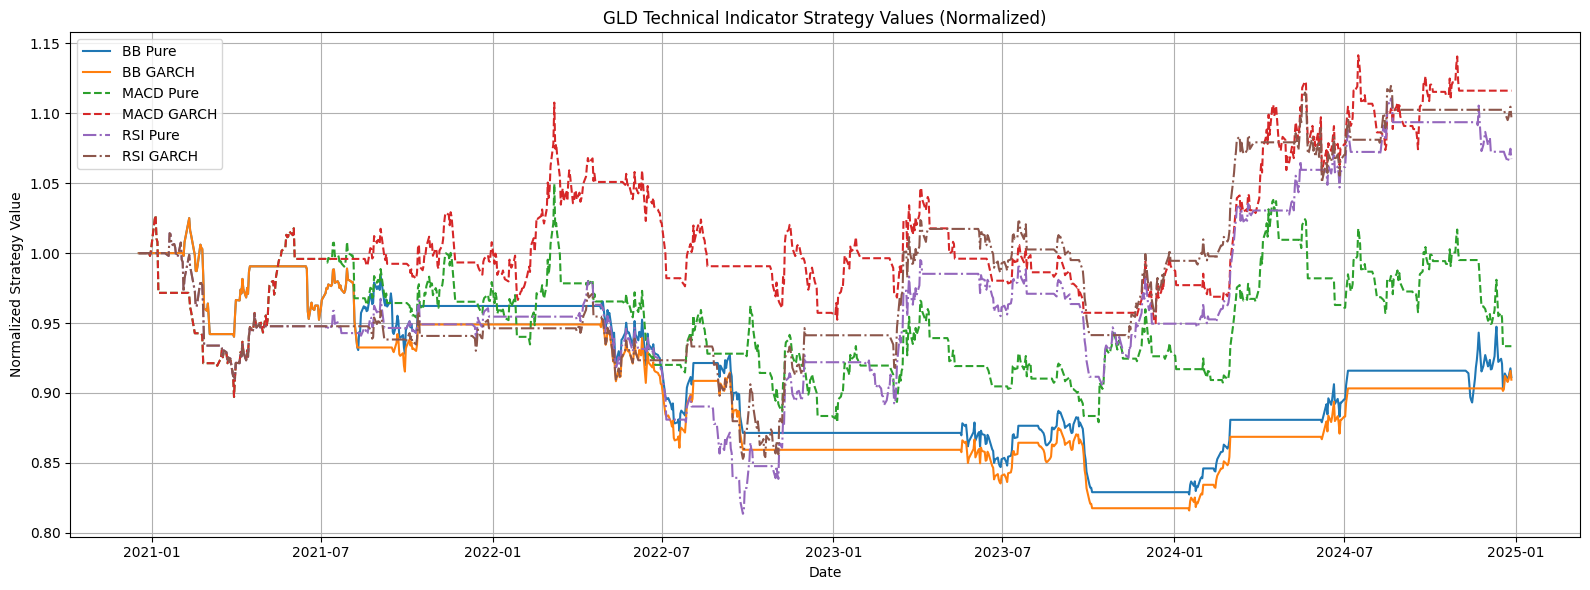

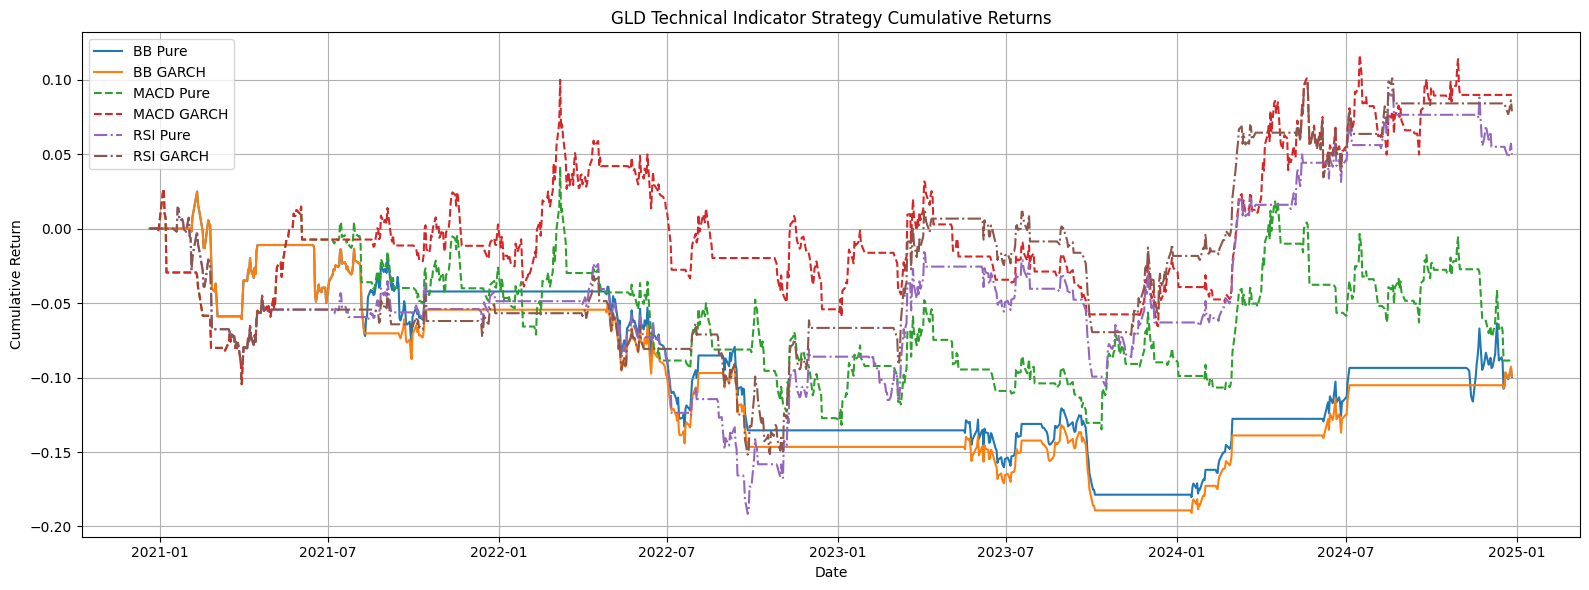

In [95]:
def plot_technical_strategies_combined_both(
    bb_bt_list, bb_labels,
    macd_bt_list, macd_labels,
    rsi_bt_list, rsi_labels,
    stock_code='Stock',
    figsize=(16, 6)
):
    # === Plot 1: Normalized Strategy Values ===
    plt.figure(figsize=figsize)

    def plot_strategy_values(df_list, labels, style):
        for df, label in zip(df_list, labels):
            val_col = [col for col in df.columns if 'strategy_value' in col][0]
            normalized = df[val_col] / df[val_col].iloc[0]
            plt.plot(df.index, normalized, style, label=label)

    plot_strategy_values(bb_bt_list, bb_labels, style='-')
    plot_strategy_values(macd_bt_list, macd_labels, style='--')
    plot_strategy_values(rsi_bt_list, rsi_labels, style='-.')

    plt.title(f'{stock_code} Technical Indicator Strategy Values (Normalized)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot 2: Cumulative Returns ===
    plt.figure(figsize=figsize)

    def plot_cumulative_returns(df_list, labels, style):
        for df, label in zip(df_list, labels):
            ret_col = [col for col in df.columns if 'strategy_return' in col][0]
            cumret = (1 + df[ret_col]).cumprod() - 1
            plt.plot(df.index, cumret, style, label=label)

    plot_cumulative_returns(bb_bt_list, bb_labels, style='-')
    plot_cumulative_returns(macd_bt_list, macd_labels, style='--')
    plot_cumulative_returns(rsi_bt_list, rsi_labels, style='-.')

    plt.title(f'{stock_code} Technical Indicator Strategy Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_technical_strategies_combined_both(
    bb_bt_list=[bb_pure_bt, bb_garch_bt],
    bb_labels=['BB Pure', 'BB GARCH'],
    macd_bt_list=[macd_pure_bt, macd_garch_bt],
    macd_labels=['MACD Pure', 'MACD GARCH'],
    rsi_bt_list=[rsi_pure_bt, rsi_garch_bt],
    rsi_labels=['RSI Pure', 'RSI GARCH'],
    stock_code=stock_code
)



In [ ]:
def plot_rf_compare_strategies(test_df, *rf_backtests, labels=None, figsize=(16,10)):

    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(rf_backtests))]
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot normalized strategy values
    for df, label in zip(rf_backtests, labels):
        norm_value = df.iloc[:, df.columns.get_loc([col for col in df.columns if 'strategy_value' in col][0])]
        norm_value = norm_value / norm_value.iloc[0]
        axes[0].plot(df.index, norm_value, label=label)
    axes[0].set_title(f'Normalized Strategy Values Comparison (RF) for {stock_code}')
    axes[0].set_ylabel('Normalized Value')
    axes[0].legend()
    axes[0].grid(True)

    # Plot positions
    for df, label in zip(rf_backtests, labels):
        pos_col = [col for col in df.columns if 'position' in col][0]
        axes[1].step(df.index, df[pos_col], label=label, where='post')
    axes[1].set_title('Position Sizes Over Time')
    axes[1].set_ylabel('Position (Shares)')
    axes[1].set_xlabel('Date')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_rf_compare_strategies(
    test_data,
    rf_nofs_bt,
    rf_bt,
    rf_sig_bt,
    rf_sig_fs_bt,
    labels=['RF', 'RF + FS', 'RF + Sig', 'RF + Sig + FS']
)


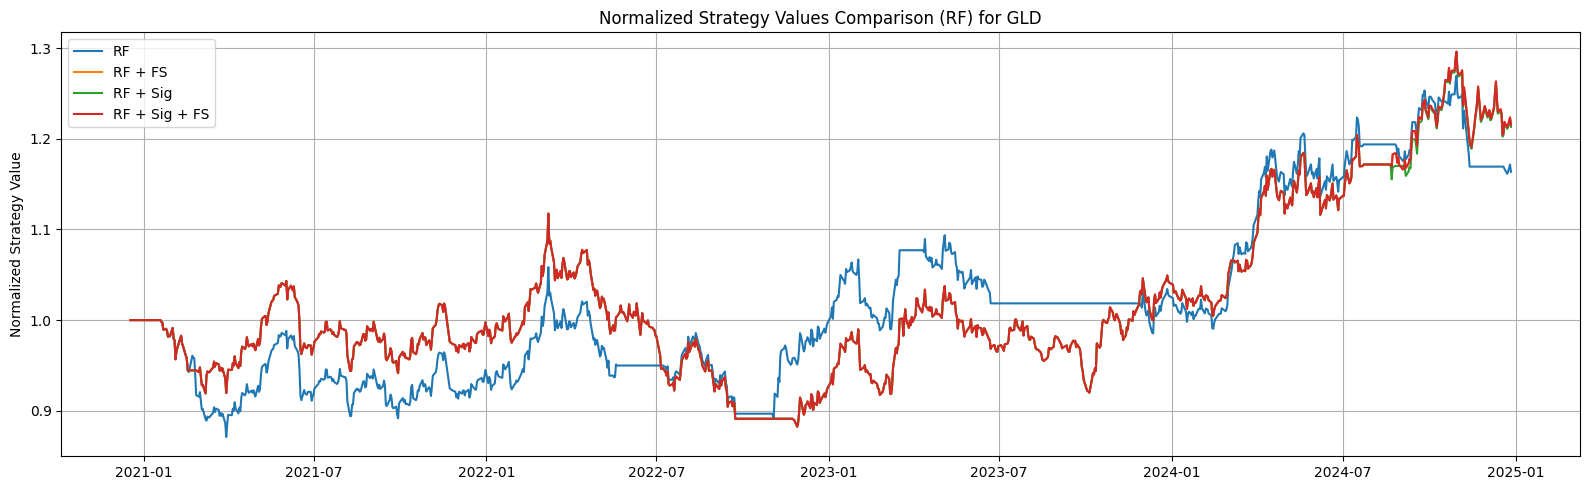

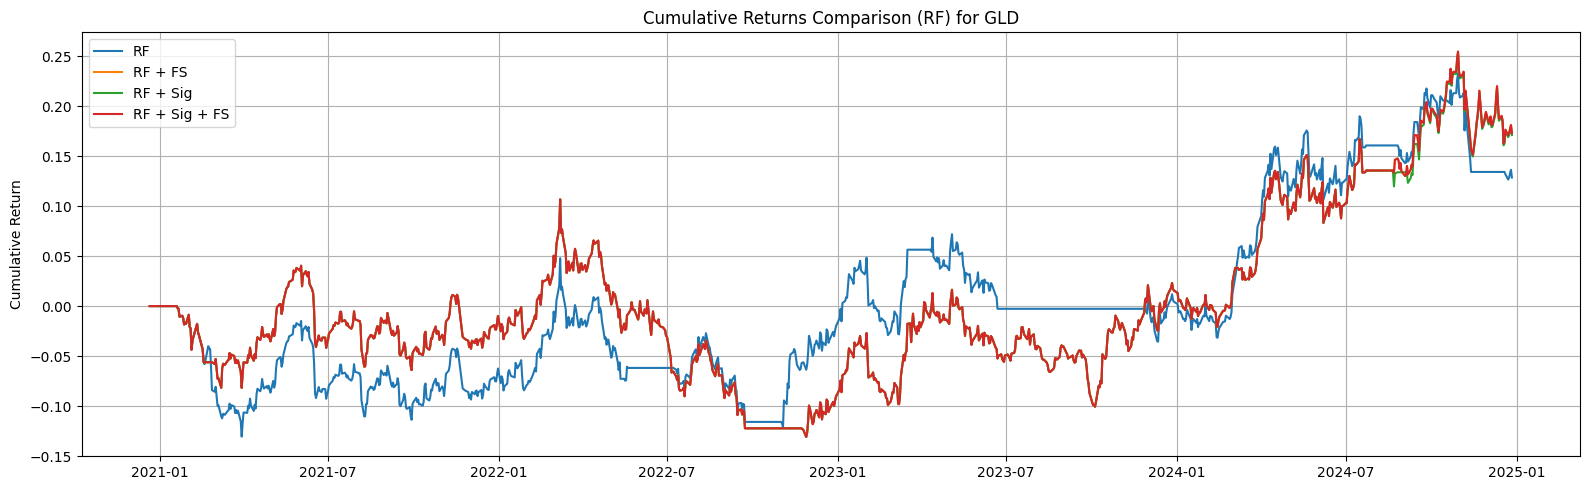

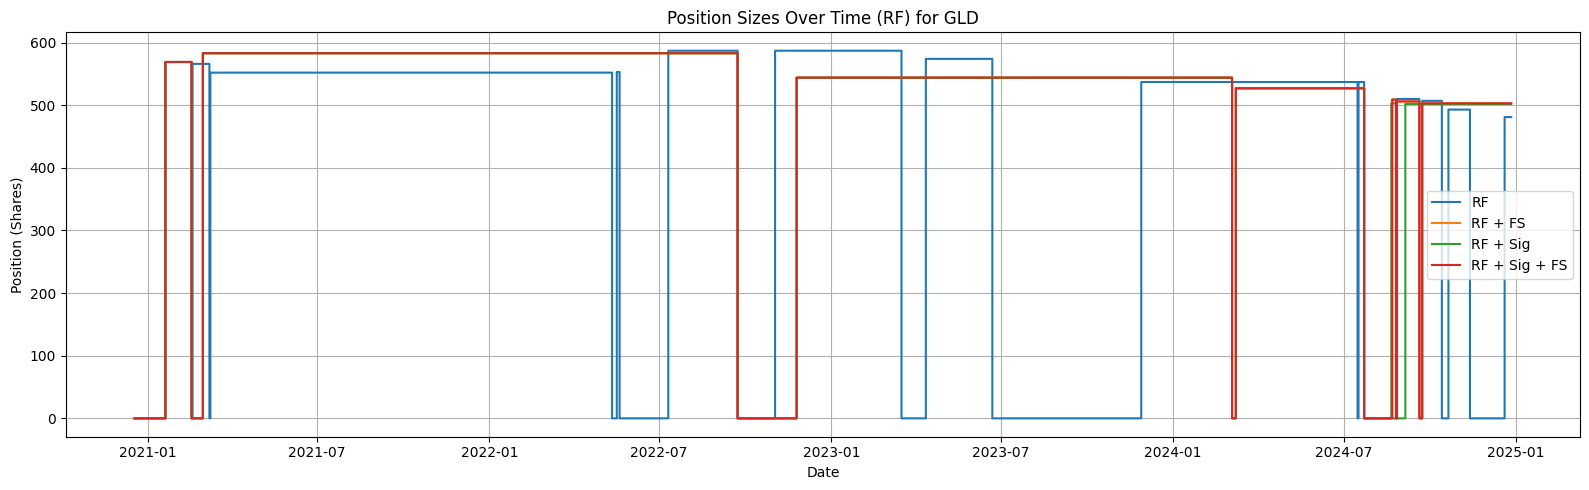

In [97]:
import matplotlib.pyplot as plt

def plot_rf_compare_strategies(test_df, *rf_backtests, labels=None, stock_code='Stock', figsize=(16,5)):

    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(rf_backtests))]

    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for df, label in zip(rf_backtests, labels):
        val_col = [col for col in df.columns if 'strategy_value' in col][0]
        normalized = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, normalized, label=label)
    plt.title(f'Normalized Strategy Values Comparison (RF) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for df, label in zip(rf_backtests, labels):
        ret_col = [col for col in df.columns if 'strategy_return' in col][0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=label)
    plt.title(f'Cumulative Returns Comparison (RF) for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Position Sizes ---
    plt.figure(figsize=figsize)
    for df, label in zip(rf_backtests, labels):
        pos_col = [col for col in df.columns if 'position' in col][0]
        plt.step(df.index, df[pos_col], label=label, where='post')
    plt.title(f'Position Sizes Over Time (RF) for {stock_code}')
    plt.ylabel('Position (Shares)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_rf_compare_strategies(
    test_data,
    rf_nofs_bt,
    rf_bt,
    rf_sig_bt,
    rf_sig_fs_bt,
    labels=['RF', 'RF + FS', 'RF + Sig', 'RF + Sig + FS'],
    stock_code=stock_code
)


In [ ]:
import matplotlib.pyplot as plt

def plot_rf_compare_strategies(test_df, *rf_backtests, labels=None, stock_code='Stock', figsize=(16,5)):
    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(rf_backtests))]

    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for df, label in zip(rf_backtests, labels):
        val_cols = [col for col in df.columns if 'strategy_value' in col]
        if not val_cols:
            raise ValueError(f"No 'strategy_value' column found in dataframe for {label}")
        val_col = val_cols[0]
        normalized = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, normalized, label=label)
    plt.title(f'Normalized Strategy Values Comparison (RF) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for df, label in zip(rf_backtests, labels):
        ret_cols = [col for col in df.columns if 'strategy_return' in col]
        if not ret_cols:
            raise ValueError(f"No 'return' column found in dataframe for {label}")
        ret_col = ret_cols[0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=label)
    plt.title(f'Cumulative Returns Comparison (RF) for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Position Sizes ---
    plt.figure(figsize=figsize)
    for df, label in zip(rf_backtests, labels):
        pos_cols = [col for col in df.columns if 'position' in col]
        if not pos_cols:
            raise ValueError(f"No 'position' column found in dataframe for {label}")
        pos_col = pos_cols[0]
        plt.step(df.index, df[pos_col], label=label, where='post')
    plt.title(f'Position Sizes Over Time (RF) for {stock_code}')
    plt.ylabel('Position Size')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example
plot_rf_compare_strategies(
    test_data,
    rf_nofs_bt,
    rf_bt,
    rf_sig_bt,
    rf_sig_fs_bt,
    labels=['RF No FS', 'RF', 'RF + Sig', 'RF + Sig + FS'],
    stock_code=stock_code
)


In [ ]:
def plot_rf_compare_strategies(test_df, rf_nofs_nogarch_bt, rf_nofs_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = rf_nofs_nogarch_bt['rf_nofs_nogarch_5_20_strategy_value'] / rf_nofs_nogarch_bt['rf_nofs_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = rf_nofs_bt['rf_nofs_5_20_strategy_value'] / rf_nofs_bt['rf_nofs_5_20_strategy_value'].iloc[0]
    plt.plot(rf_nofs_nogarch_bt.index, norm_pure, label='Pure RF Strategy', color='orange')
    plt.plot(rf_nofs_bt.index, norm_garch, label='RF GARCH Filtered Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + rf_nofs_nogarch_bt['rf_nofs_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + rf_nofs_bt['rf_nofs_5_20_strategy_return']).cumprod() - 1
    plt.plot(rf_nofs_nogarch_bt.index, cumret_pure, label='RF Pure Cumulative Return', color='orange')
    plt.plot(rf_nofs_bt.index, cumret_garch, label='BB GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(rf_nofs_nogarch_bt.index, rf_nofs_nogarch_bt['rf_nofs_nogarch_5_20_position'], label='RF Pure Position', where='post')
    plt.step(rf_nofs_bt.index, rf_nofs_bt['rf_nofs_5_20_position'], label='RF GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Usage:
plot_rf_compare_strategies(test_data, rf_nofs_nogarch_bt, rf_nofs_bt, stock_code=f'{stock_code}')


In [ ]:
def plot_rf_sig_compare_strategies(test_df, rf_sig_nogarch_bt, rf_sig_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = rf_sig_nogarch_bt['rf_sig_nogarch_5_20_strategy_value'] / rf_sig_nogarch_bt['rf_sig_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = rf_sig_bt['rf_sig_5_20_strategy_value'] / rf_sig_bt['rf_sig_5_20_strategy_value'].iloc[0]
    plt.plot(rf_sig_nogarch_bt.index, norm_pure, label='RF+Signal Strategy (No GARCH)', color='orange')
    plt.plot(rf_sig_bt.index, norm_garch, label='RF+Signal+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + rf_sig_nogarch_bt['rf_sig_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + rf_sig_bt['rf_sig_5_20_strategy_return']).cumprod() - 1
    plt.plot(rf_sig_nogarch_bt.index, cumret_pure, label='RF+Signal Cumulative Return (No GARCH)', color='orange')
    plt.plot(rf_sig_bt.index, cumret_garch, label='RF+Signal+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(rf_sig_nogarch_bt.index, rf_sig_nogarch_bt['rf_sig_nogarch_5_20_position'], label='RF+Signal Position (No GARCH)', where='post')
    plt.step(rf_sig_bt.index, rf_sig_bt['rf_sig_5_20_position'], label='RF+Signal+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_rf_sig_compare_strategies(test_data, rf_sig_nogarch_bt, rf_sig_bt, stock_code=f'{stock_code}')


In [ ]:
def plot_rf_fs_compare_strategies(test_df, rf_nogarch_bt, rf_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = rf_nogarch_bt['rf_nogarch_5_20_strategy_value'] / rf_nogarch_bt['rf_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = rf_bt['rf_5_20_strategy_value'] / rf_bt['rf_5_20_strategy_value'].iloc[0]
    plt.plot(rf_nogarch_bt.index, norm_pure, label='RF Strategy (No GARCH)', color='orange')
    plt.plot(rf_bt.index, norm_garch, label='RF+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + rf_nogarch_bt['rf_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + rf_bt['rf_5_20_strategy_return']).cumprod() - 1
    plt.plot(rf_nogarch_bt.index, cumret_pure, label='RF Cumulative Return (No GARCH)', color='orange')
    plt.plot(rf_bt.index, cumret_garch, label='RF+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(rf_nogarch_bt.index, rf_nogarch_bt['rf_nogarch_5_20_position'], label='RF Position (No GARCH)', where='post')
    plt.step(rf_bt.index, rf_bt['rf_5_20_position'], label='RF+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_rf_fs_compare_strategies(test_data, rf_nogarch_bt, rf_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_rf_sig_fs_compare_strategies(test_df, rf_sig_fs_nogarch_bt, rf_sig_fs_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = rf_sig_fs_nogarch_bt['rf_sig_fs_nogarch_5_20_strategy_value'] / rf_sig_fs_nogarch_bt['rf_sig_fs_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = rf_sig_fs_bt['rf_sig_fs_5_20_strategy_value'] / rf_sig_fs_bt['rf_sig_fs_5_20_strategy_value'].iloc[0]
    plt.plot(rf_sig_fs_nogarch_bt.index, norm_pure, label='RF+Signal+FS Strategy (No GARCH)', color='orange')
    plt.plot(rf_sig_fs_bt.index, norm_garch, label='RF+Signal+FS+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + rf_sig_fs_nogarch_bt['rf_sig_fs_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + rf_sig_fs_bt['rf_sig_fs_5_20_strategy_return']).cumprod() - 1
    plt.plot(rf_sig_fs_nogarch_bt.index, cumret_pure, label='RF+Signal+FS Cumulative Return (No GARCH)', color='orange')
    plt.plot(rf_sig_fs_bt.index, cumret_garch, label='RF+Signal+FS+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(rf_sig_fs_nogarch_bt.index, rf_sig_fs_nogarch_bt['rf_sig_fs_nogarch_5_20_position'], label='RF+Signal+FS Position (No GARCH)', where='post')
    plt.step(rf_sig_fs_bt.index, rf_sig_fs_bt['rf_sig_fs_5_20_position'], label='RF+Signal+FS+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_rf_sig_fs_compare_strategies(test_data, rf_sig_fs_nogarch_bt, rf_sig_fs_bt, stock_code=f'{stock_code}')


In [ ]:
def plot_xgb_compare_strategies(test_df, *xgb_backtests, labels=None, figsize=(16, 10)):
    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(xgb_backtests))]

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot normalized strategy values
    for df, label in zip(xgb_backtests, labels):

        val_col = [col for col in df.columns if 'strategy_value' in col][0]
        norm_value = df[val_col] / df[val_col].iloc[0]
        axes[0].plot(df.index, norm_value, label=label)
    axes[0].set_title(f'Normalized Strategy Values Comparison (XGBoost) for {stock_code}')
    axes[0].set_ylabel('Normalized Value')
    axes[0].legend()
    axes[0].grid(True)

    # Plot positions
    for df, label in zip(xgb_backtests, labels):
        pos_col = [col for col in df.columns if 'position' in col][0]
        axes[1].step(df.index, df[pos_col], label=label, where='post')
    axes[1].set_title('Position Sizes Over Time')
    axes[1].set_ylabel('Position (Shares)')
    axes[1].set_xlabel('Date')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_xgb_compare_strategies(
    test_data,
    xgb_nofs_bt,
    xgb_bt,
    xgb_sig_bt,
    xgb_sig_fs_bt,
    labels=['XGB', 'XGB + FS', 'XGB + Sig', 'XGB + Sig + FS']
)


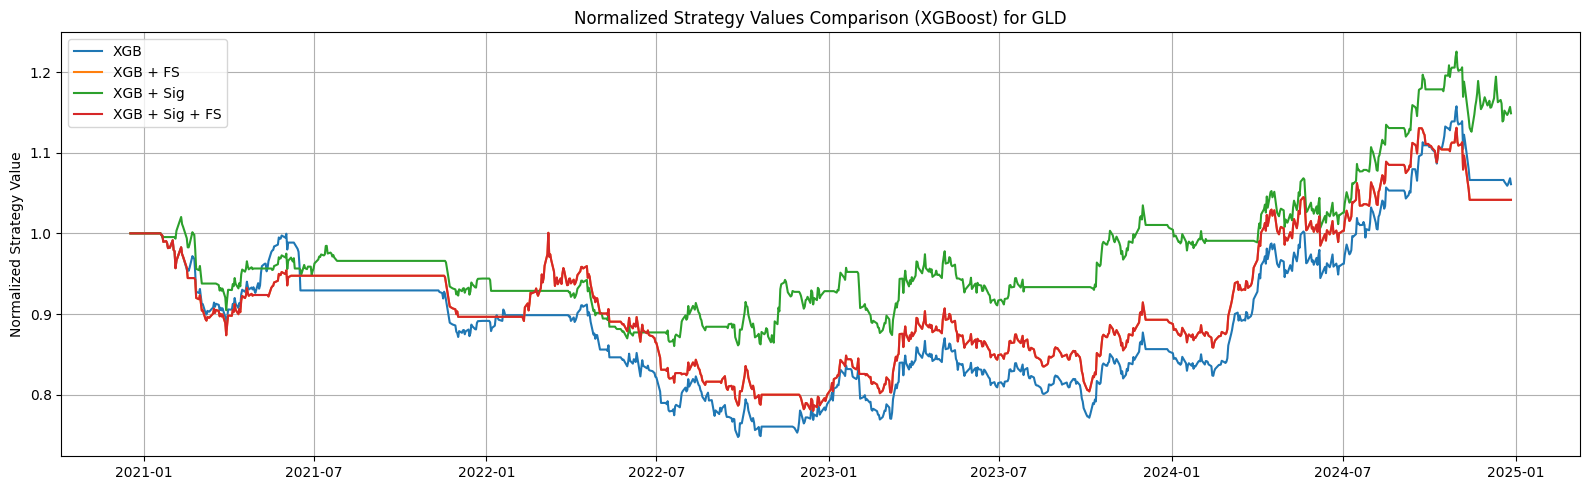

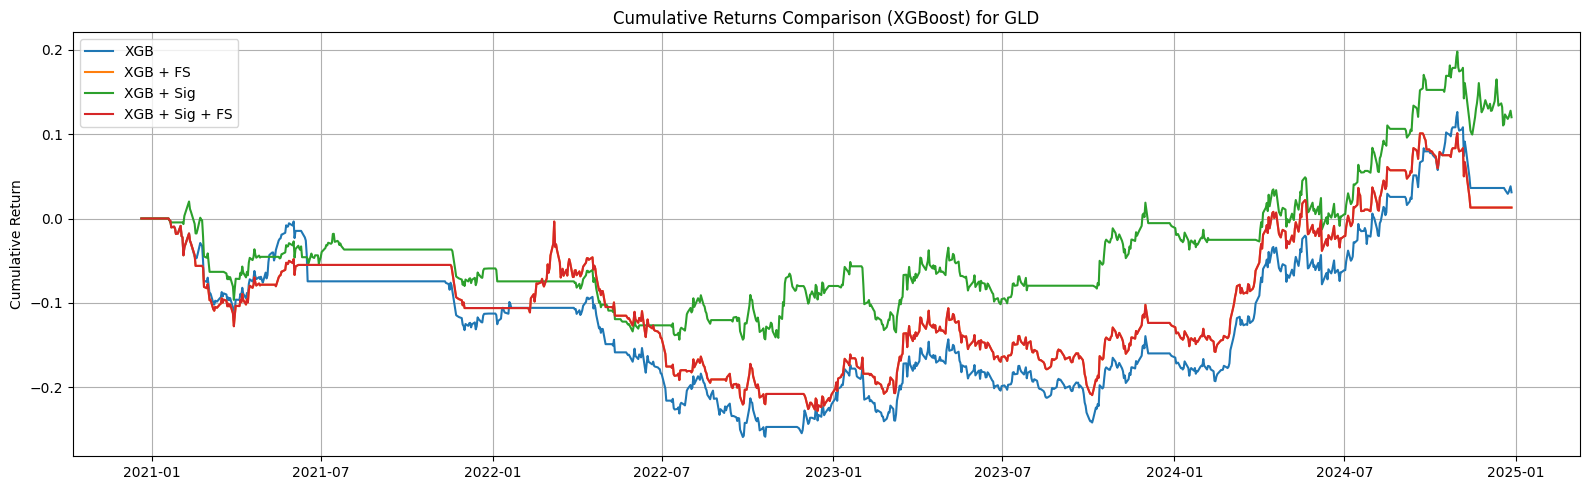

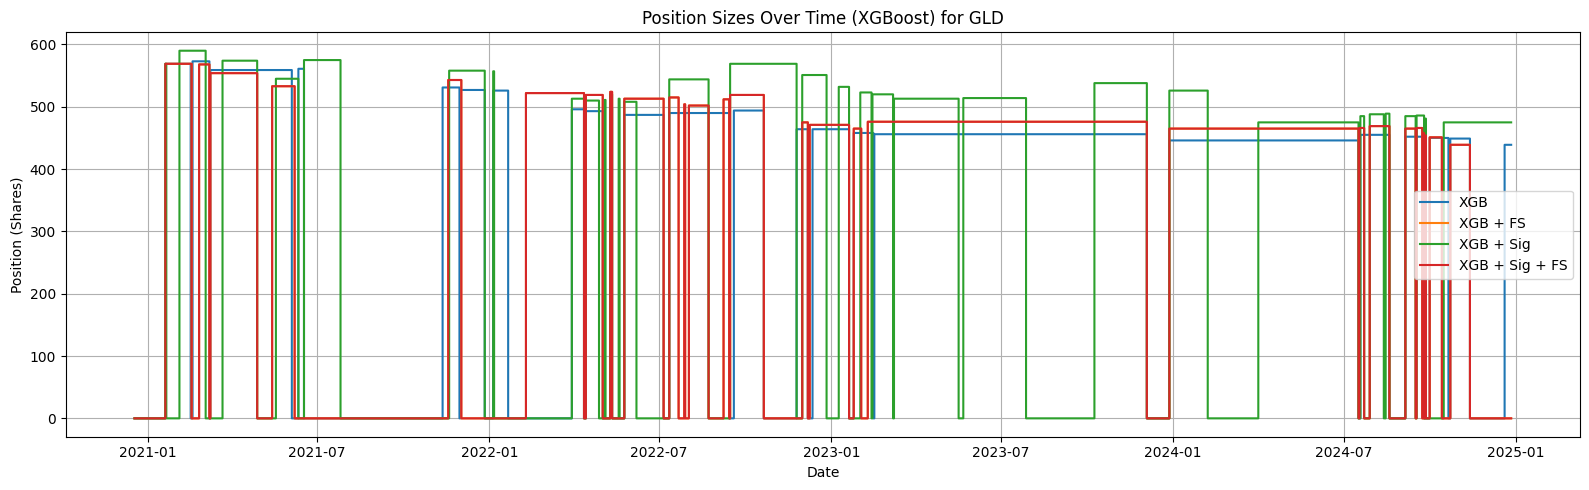

In [104]:
def plot_xgb_compare_strategies(test_df, *xgb_backtests, labels=None, stock_code='Stock', figsize=(16,5)):
    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(xgb_backtests))]

    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for df, label in zip(xgb_backtests, labels):
        val_col = [col for col in df.columns if 'strategy_value' in col][0]
        normalized = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, normalized, label=label)
    plt.title(f'Normalized Strategy Values Comparison (XGBoost) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for df, label in zip(xgb_backtests, labels):
        ret_col = [col for col in df.columns if 'strategy_return' in col][0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=label)
    plt.title(f'Cumulative Returns Comparison (XGBoost) for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Position Sizes ---
    plt.figure(figsize=figsize)
    for df, label in zip(xgb_backtests, labels):
        pos_col = [col for col in df.columns if 'position' in col][0]
        plt.step(df.index, df[pos_col], label=label, where='post')
    plt.title(f'Position Sizes Over Time (XGBoost) for {stock_code}')
    plt.ylabel('Position (Shares)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xgb_compare_strategies(
    test_data,
    xgb_nofs_bt,
    xgb_bt,
    xgb_sig_bt,
    xgb_sig_fs_bt,
    labels=['XGB', 'XGB + FS', 'XGB + Sig', 'XGB + Sig + FS'],
    stock_code=stock_code
)


In [ ]:
def plot_xgb_nofs_compare_strategies(test_df, xgb_nofs_nogarch_bt, xgb_nofs_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = xgb_nofs_nogarch_bt['xgb_nofs_nogarch_5_20_strategy_value'] / xgb_nofs_nogarch_bt['xgb_nofs_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = xgb_nofs_bt['xgb_nofs_5_20_strategy_value'] / xgb_nofs_bt['xgb_nofs_5_20_strategy_value'].iloc[0]
    plt.plot(xgb_nofs_nogarch_bt.index, norm_pure, label='XGB Strategy (No GARCH)', color='orange')
    plt.plot(xgb_nofs_bt.index, norm_garch, label='XGB+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return Plot ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + xgb_nofs_nogarch_bt['xgb_nofs_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + xgb_nofs_bt['xgb_nofs_5_20_strategy_return']).cumprod() - 1
    plt.plot(xgb_nofs_nogarch_bt.index, cumret_pure, label='XGB Cumulative Return (No GARCH)', color='orange')
    plt.plot(xgb_nofs_bt.index, cumret_garch, label='XGB+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position Sizes ===
    plt.figure(figsize=(16, 5))
    plt.step(xgb_nofs_nogarch_bt.index, xgb_nofs_nogarch_bt['xgb_nofs_nogarch_5_20_position'], label='XGB Position (No GARCH)', where='post')
    plt.step(xgb_nofs_bt.index, xgb_nofs_bt['xgb_nofs_5_20_position'], label='XGB+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xgb_nofs_compare_strategies(test_data, xgb_nofs_nogarch_bt, xgb_nofs_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_xgb_compare_strategies(test_df, xgb_nogarch_bt, xgb_bt, stock_code='Stock'):
    plt.figure(figsize=(16, 5))
    norm_pure = xgb_nogarch_bt['xgb_nogarch_5_20_strategy_value'] / xgb_nogarch_bt['xgb_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = xgb_bt['xgb_5_20_strategy_value'] / xgb_bt['xgb_5_20_strategy_value'].iloc[0]
    plt.plot(xgb_nogarch_bt.index, norm_pure, label='XGB Strategy (No GARCH)', color='orange')
    plt.plot(xgb_bt.index, norm_garch, label='XGB+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + xgb_nogarch_bt['xgb_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + xgb_bt['xgb_5_20_strategy_return']).cumprod() - 1
    plt.plot(xgb_nogarch_bt.index, cumret_pure, label='XGB Cumulative Return (No GARCH)', color='orange')
    plt.plot(xgb_bt.index, cumret_garch, label='XGB+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.step(xgb_nogarch_bt.index, xgb_nogarch_bt['xgb_nogarch_5_20_position'], label='XGB Position (No GARCH)', where='post')
    plt.step(xgb_bt.index, xgb_bt['xgb_5_20_position'], label='XGB+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xgb_compare_strategies(test_data, xgb_nogarch_bt, xgb_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_xgb_sig_compare_strategies(test_df, xgb_sig_nogarch_bt, xgb_sig_bt, stock_code='Stock'):
    plt.figure(figsize=(16, 5))
    norm_pure = xgb_sig_nogarch_bt['xgb_sig_nogarch_5_20_strategy_value'] / xgb_sig_nogarch_bt['xgb_sig_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = xgb_sig_bt['xgb_sig_5_20_strategy_value'] / xgb_sig_bt['xgb_sig_5_20_strategy_value'].iloc[0]
    plt.plot(xgb_sig_nogarch_bt.index, norm_pure, label='XGB+Signal Strategy (No GARCH)', color='orange')
    plt.plot(xgb_sig_bt.index, norm_garch, label='XGB+Signal+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + xgb_sig_nogarch_bt['xgb_sig_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + xgb_sig_bt['xgb_sig_5_20_strategy_return']).cumprod() - 1
    plt.plot(xgb_sig_nogarch_bt.index, cumret_pure, label='XGB+Signal Cumulative Return (No GARCH)', color='orange')
    plt.plot(xgb_sig_bt.index, cumret_garch, label='XGB+Signal+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.step(xgb_sig_nogarch_bt.index, xgb_sig_nogarch_bt['xgb_sig_nogarch_5_20_position'], label='XGB+Signal Position (No GARCH)', where='post')
    plt.step(xgb_sig_bt.index, xgb_sig_bt['xgb_sig_5_20_position'], label='XGB+Signal+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xgb_sig_compare_strategies(test_data, xgb_sig_nogarch_bt, xgb_sig_bt, stock_code=f'{stock_code}')


In [ ]:
def plot_xgb_sig_fs_compare_strategies(test_df, xgb_sig_fs_nogarch_bt, xgb_sig_fs_bt, stock_code='Stock'):
    plt.figure(figsize=(16, 5))
    norm_pure = xgb_sig_fs_nogarch_bt['xgb_sig_fs_nogarch_5_20_strategy_value'] / xgb_sig_fs_nogarch_bt['xgb_sig_fs_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = xgb_sig_fs_bt['xgb_sig_fs_5_20_strategy_value'] / xgb_sig_fs_bt['xgb_sig_fs_5_20_strategy_value'].iloc[0]
    plt.plot(xgb_sig_fs_nogarch_bt.index, norm_pure, label='XGB+Signal+FS Strategy (No GARCH)', color='orange')
    plt.plot(xgb_sig_fs_bt.index, norm_garch, label='XGB+Signal+FS+GARCH Strategy', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + xgb_sig_fs_nogarch_bt['xgb_sig_fs_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + xgb_sig_fs_bt['xgb_sig_fs_5_20_strategy_return']).cumprod() - 1
    plt.plot(xgb_sig_fs_nogarch_bt.index, cumret_pure, label='XGB+Signal+FS Cumulative Return (No GARCH)', color='orange')
    plt.plot(xgb_sig_fs_bt.index, cumret_garch, label='XGB+Signal+FS+GARCH Cumulative Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.step(xgb_sig_fs_nogarch_bt.index, xgb_sig_fs_nogarch_bt['xgb_sig_fs_nogarch_5_20_position'], label='XGB+Signal+FS Position (No GARCH)', where='post')
    plt.step(xgb_sig_fs_bt.index, xgb_sig_fs_bt['xgb_sig_fs_5_20_position'], label='XGB+Signal+FS+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xgb_sig_fs_compare_strategies(test_data, xgb_sig_fs_nogarch_bt, xgb_sig_fs_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_mlp_compare_strategies(test_df, *mlp_backtests, labels=None, figsize=(16, 10)):
    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(mlp_backtests))]

    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot normalized strategy values
    for df, label in zip(mlp_backtests, labels):
        val_col = [col for col in df.columns if 'strategy_value' in col][0]
        norm_value = df[val_col] / df[val_col].iloc[0]
        axes[0].plot(df.index, norm_value, label=label)
    axes[0].set_title(f'Normalized Strategy Values Comparison (MLP) for {stock_code}')
    axes[0].set_ylabel('Normalized Value')
    axes[0].legend()
    axes[0].grid(True)

    # Plot positions
    for df, label in zip(mlp_backtests, labels):
        pos_col = [col for col in df.columns if 'position' in col][0]
        axes[1].step(df.index, df[pos_col], label=label, where='post')
    axes[1].set_title('Position Sizes Over Time')
    axes[1].set_ylabel('Position (Shares)')
    axes[1].set_xlabel('Date')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_mlp_compare_strategies(
    test_data,
    mlp_pca_bt,
    mlp_pca_sig_bt,
    mlp_bt,
    mlp_sig_bt,
    labels=['MLP PCA', 'MLP PCA + Sig', 'MLP', 'MLP + Sig']
)


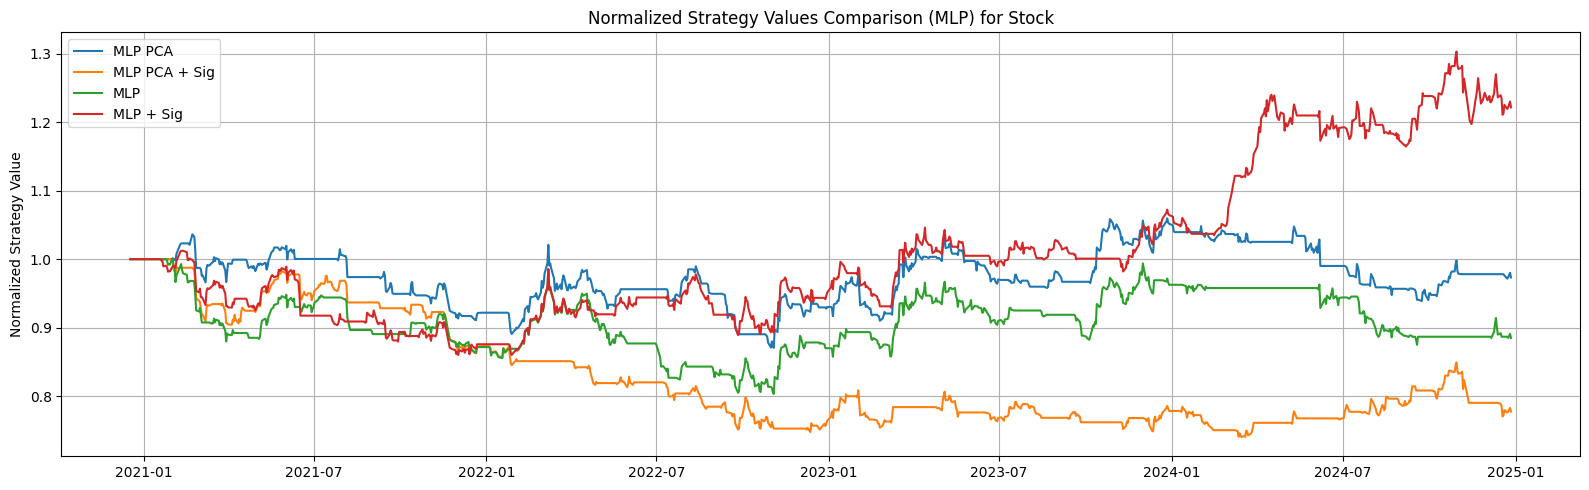

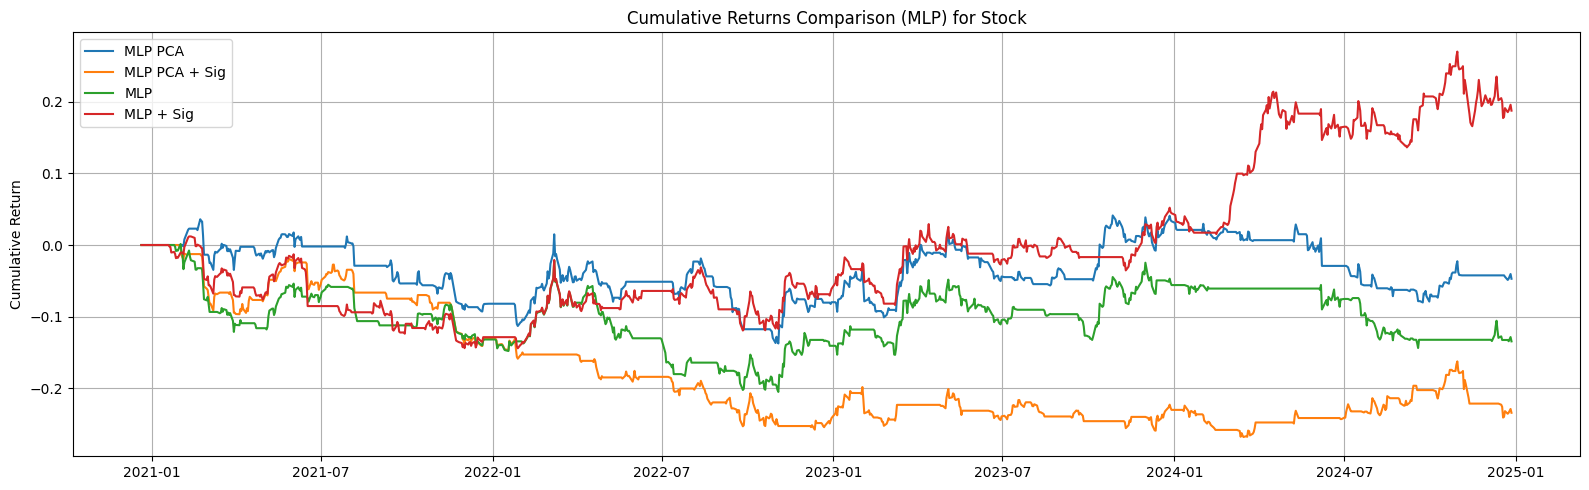

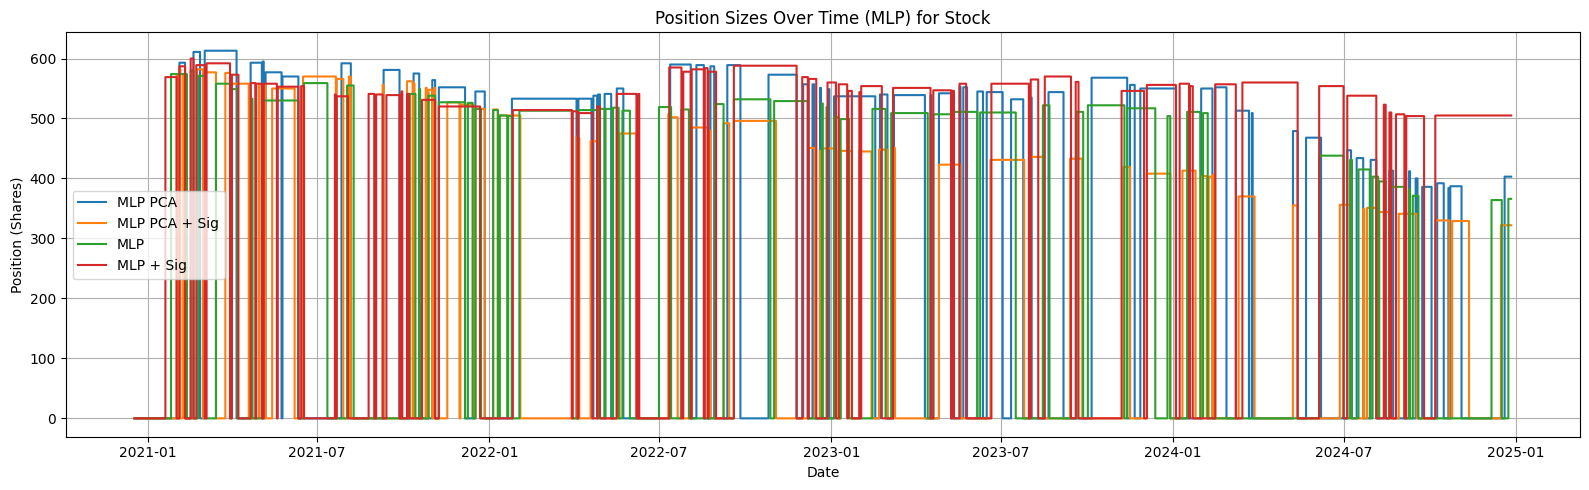

In [110]:
def plot_mlp_compare_strategies(test_df, *mlp_backtests, labels=None, stock_code='Stock', figsize=(16, 5)):
    if labels is None:
        labels = [f'Strategy {i+1}' for i in range(len(mlp_backtests))]

    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for df, label in zip(mlp_backtests, labels):
        val_col = [col for col in df.columns if 'strategy_value' in col][0]
        normalized = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, normalized, label=label)
    plt.title(f'Normalized Strategy Values Comparison (MLP) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for df, label in zip(mlp_backtests, labels):
        ret_col = [col for col in df.columns if 'strategy_return' in col][0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=label)
    plt.title(f'Cumulative Returns Comparison (MLP) for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Position Sizes ---
    plt.figure(figsize=figsize)
    for df, label in zip(mlp_backtests, labels):
        pos_col = [col for col in df.columns if 'position' in col][0]
        plt.step(df.index, df[pos_col], label=label, where='post')
    plt.title(f'Position Sizes Over Time (MLP) for {stock_code}')
    plt.ylabel('Position (Shares)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_mlp_compare_strategies(
    test_data,
    mlp_pca_bt,
    mlp_pca_sig_bt,
    mlp_bt,
    mlp_sig_bt,
    labels=['MLP PCA', 'MLP PCA + Sig', 'MLP', 'MLP + Sig']
)


In [ ]:
def plot_mlp_pca_compare_strategies(test_df, mlp_pca_nogarch_bt, mlp_pca_bt, stock_code='Stock'):
    # === 1. Strategy Value Comparison (Normalized) ===
    plt.figure(figsize=(16, 5))
    norm_pure = mlp_pca_nogarch_bt['mlp_pca_nogarch_5_20_strategy_value'] / mlp_pca_nogarch_bt['mlp_pca_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = mlp_pca_bt['mlp_pca_5_20_strategy_value'] / mlp_pca_bt['mlp_pca_5_20_strategy_value'].iloc[0]
    plt.plot(mlp_pca_nogarch_bt.index, norm_pure, label='MLP+PCA (No GARCH)', color='orange')
    plt.plot(mlp_pca_bt.index, norm_garch, label='MLP+PCA+GARCH', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 2. Cumulative Return ===
    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + mlp_pca_nogarch_bt['mlp_pca_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + mlp_pca_bt['mlp_pca_5_20_strategy_return']).cumprod() - 1
    plt.plot(mlp_pca_nogarch_bt.index, cumret_pure, label='MLP+PCA Return (No GARCH)', color='orange')
    plt.plot(mlp_pca_bt.index, cumret_garch, label='MLP+PCA+GARCH Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === 3. Position ===
    plt.figure(figsize=(16, 5))
    plt.step(mlp_pca_nogarch_bt.index, mlp_pca_nogarch_bt['mlp_pca_nogarch_5_20_position'], label='MLP+PCA Position (No GARCH)', where='post')
    plt.step(mlp_pca_bt.index, mlp_pca_bt['mlp_pca_5_20_position'], label='MLP+PCA+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mlp_pca_compare_strategies(test_data, mlp_pca_nogarch_bt, mlp_pca_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_mlp_pca_sig_compare_strategies(test_df, mlp_pca_sig_nogarch_bt, mlp_pca_sig_bt, stock_code='Stock'):
    plt.figure(figsize=(16, 5))
    norm_pure = mlp_pca_sig_nogarch_bt['mlp_pca_sig_nogarch_5_20_strategy_value'] / mlp_pca_sig_nogarch_bt['mlp_pca_sig_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = mlp_pca_sig_bt['mlp_pca_sig_5_20_strategy_value'] / mlp_pca_sig_bt['mlp_pca_sig_5_20_strategy_value'].iloc[0]
    plt.plot(mlp_pca_sig_nogarch_bt.index, norm_pure, label='MLP+PCA+Signal (No GARCH)', color='orange')
    plt.plot(mlp_pca_sig_bt.index, norm_garch, label='MLP+PCA+Signal+GARCH', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + mlp_pca_sig_nogarch_bt['mlp_pca_sig_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + mlp_pca_sig_bt['mlp_pca_sig_5_20_strategy_return']).cumprod() - 1
    plt.plot(mlp_pca_sig_nogarch_bt.index, cumret_pure, label='MLP+PCA+Signal Return (No GARCH)', color='orange')
    plt.plot(mlp_pca_sig_bt.index, cumret_garch, label='MLP+PCA+Signal+GARCH Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.step(mlp_pca_sig_nogarch_bt.index, mlp_pca_sig_nogarch_bt['mlp_pca_sig_nogarch_5_20_position'], label='MLP+PCA+Signal Position (No GARCH)', where='post')
    plt.step(mlp_pca_sig_bt.index, mlp_pca_sig_bt['mlp_pca_sig_5_20_position'], label='MLP+PCA+Signal+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mlp_pca_sig_compare_strategies(test_data, mlp_pca_sig_nogarch_bt, mlp_pca_sig_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_mlp_compare_strategies(test_df, mlp_nogarch_bt, mlp_bt, stock_code='Stock'):
    plt.figure(figsize=(16, 5))
    norm_pure = mlp_nogarch_bt['mlp_nogarch_5_20_strategy_value'] / mlp_nogarch_bt['mlp_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = mlp_bt['mlp_5_20_strategy_value'] / mlp_bt['mlp_5_20_strategy_value'].iloc[0]
    plt.plot(mlp_nogarch_bt.index, norm_pure, label='MLP (No GARCH)', color='orange')
    plt.plot(mlp_bt.index, norm_garch, label='MLP+GARCH', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + mlp_nogarch_bt['mlp_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + mlp_bt['mlp_5_20_strategy_return']).cumprod() - 1
    plt.plot(mlp_nogarch_bt.index, cumret_pure, label='MLP Return (No GARCH)', color='orange')
    plt.plot(mlp_bt.index, cumret_garch, label='MLP+GARCH Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.step(mlp_nogarch_bt.index, mlp_nogarch_bt['mlp_nogarch_5_20_position'], label='MLP Position (No GARCH)', where='post')
    plt.step(mlp_bt.index, mlp_bt['mlp_5_20_position'], label='MLP+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mlp_compare_strategies(test_data, mlp_nogarch_bt, mlp_bt, stock_code=f'{stock_code}')



In [ ]:
def plot_mlp_sig_compare_strategies(test_df, mlp_sig_nogarch_bt, mlp_sig_bt, stock_code='Stock'):
    plt.figure(figsize=(16, 5))
    norm_pure = mlp_sig_nogarch_bt['mlp_sig_nogarch_5_20_strategy_value'] / mlp_sig_nogarch_bt['mlp_sig_nogarch_5_20_strategy_value'].iloc[0]
    norm_garch = mlp_sig_bt['mlp_sig_5_20_strategy_value'] / mlp_sig_bt['mlp_sig_5_20_strategy_value'].iloc[0]
    plt.plot(mlp_sig_nogarch_bt.index, norm_pure, label='MLP+Signal (No GARCH)', color='orange')
    plt.plot(mlp_sig_bt.index, norm_garch, label='MLP+Signal+GARCH', color='green')
    plt.title(f'Strategy Values Comparison (Normalized) for {stock_code}')
    plt.ylabel('Normalized Strategy Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    cumret_pure = (1 + mlp_sig_nogarch_bt['mlp_sig_nogarch_5_20_strategy_return']).cumprod() - 1
    cumret_garch = (1 + mlp_sig_bt['mlp_sig_5_20_strategy_return']).cumprod() - 1
    plt.plot(mlp_sig_nogarch_bt.index, cumret_pure, label='MLP+Signal Return (No GARCH)', color='orange')
    plt.plot(mlp_sig_bt.index, cumret_garch, label='MLP+Signal+GARCH Return', color='green')
    plt.title(f'Cumulative Returns for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 5))
    plt.step(mlp_sig_nogarch_bt.index, mlp_sig_nogarch_bt['mlp_sig_nogarch_5_20_position'], label='MLP+Signal Position (No GARCH)', where='post')
    plt.step(mlp_sig_bt.index, mlp_sig_bt['mlp_sig_5_20_position'], label='MLP+Signal+GARCH Position', where='post')
    plt.title(f'Position Size Over Time for {stock_code}')
    plt.ylabel('Position')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_mlp_sig_compare_strategies(test_data, mlp_sig_nogarch_bt, mlp_sig_bt, stock_code=f'{stock_code}')


In [ ]:
# --- Get top 6 strategies ---
top6_strategies = performance_table_clean.head(6).index.tolist()
print("Top 6 strategies:", top6_strategies)

# --- Map strategy names to backtest DataFrames ---
backtest_dict = {
    'BB Pure': bb_pure_bt,
    'BB GARCH': bb_garch_bt,
    'MACD Pure': macd_pure_bt,
    'MACD GARCH': macd_garch_bt,
    'RSI Pure': rsi_pure_bt,
    'RSI GARCH': rsi_garch_bt,
    'RF': rf_nofs_bt,
    'RF-FS': rf_bt,
    'XGB': xgb_nofs_bt,
    'XGB-FS': xgb_bt,
    'MLP + PCA': mlp_pca_bt,
    'RF with signal': rf_sig_bt,
    'XGB with signal': xgb_sig_bt,
    'MLP + PCA with signal': mlp_pca_sig_bt,
    'RF with signal and fs': rf_sig_fs_bt,
    'XGB with signal and fs': xgb_sig_fs_bt,
    'MLP': mlp_bt,
    'MLP with signal': mlp_sig_bt,
}

# Machine Learning strategies
ml_strategies = [
    'RF', 'RF-FS', 'XGB', 'XGB-FS',
    'MLP + PCA', 'RF with signal', 'XGB with signal', 'MLP + PCA with signal',
    'RF with signal and fs', 'XGB with signal and fs',
    'MLP', 'MLP with signal'
]

# Technical Indicator-based strategies
indicator_strategies = [
    'BB Pure', 'BB GARCH',
    'MACD Pure', 'MACD GARCH',
    'RSI Pure', 'RSI GARCH'
]


# --- Plot function ---
def plot_top6_strategies_single_plot(backtest_dict, top6_strategies, value_col_keyword='strategy_value', figsize=(14,7)):
    plt.figure(figsize=figsize)

    for strategy_name in top6_strategies:
        df = backtest_dict[strategy_name]
        val_col = [col for col in df.columns if value_col_keyword in col][0]
        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)

    plt.title(f'Normalized Strategy Values Comparison (Top 6 Strategies) for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Call the plot function ---
plot_top6_strategies_single_plot(backtest_dict, top6_strategies)


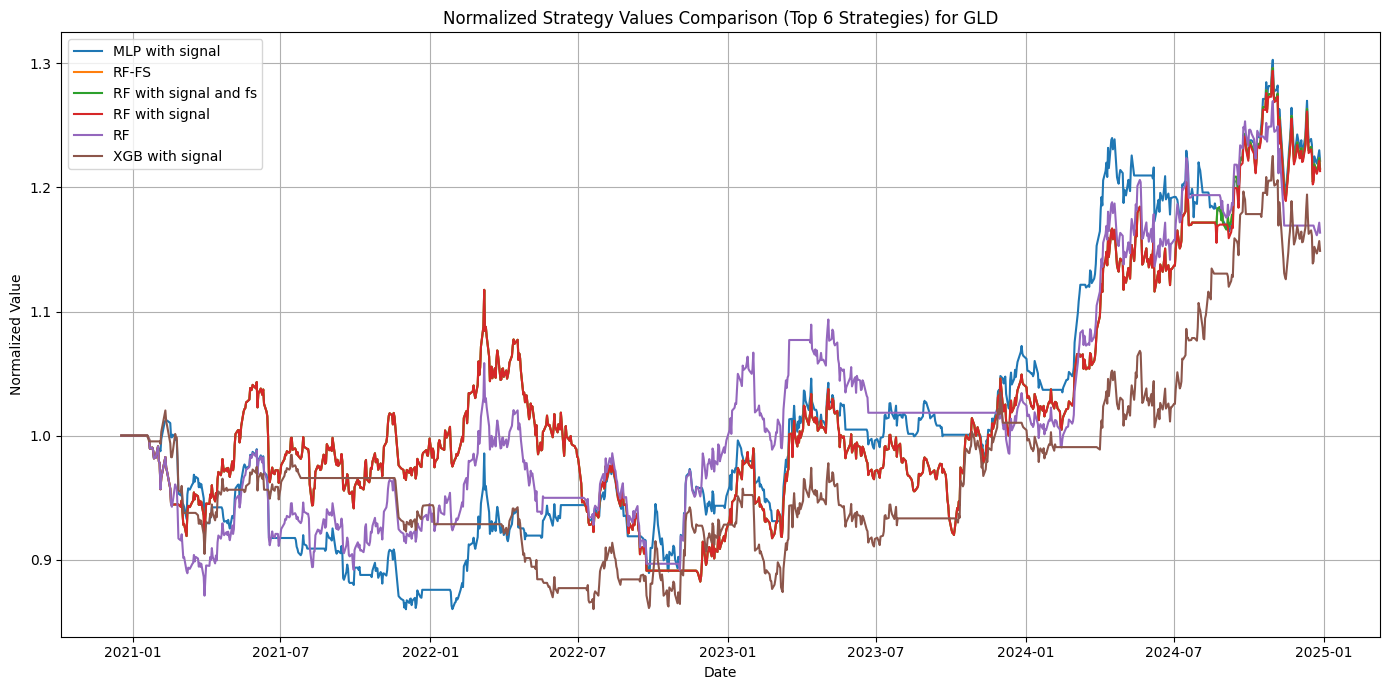

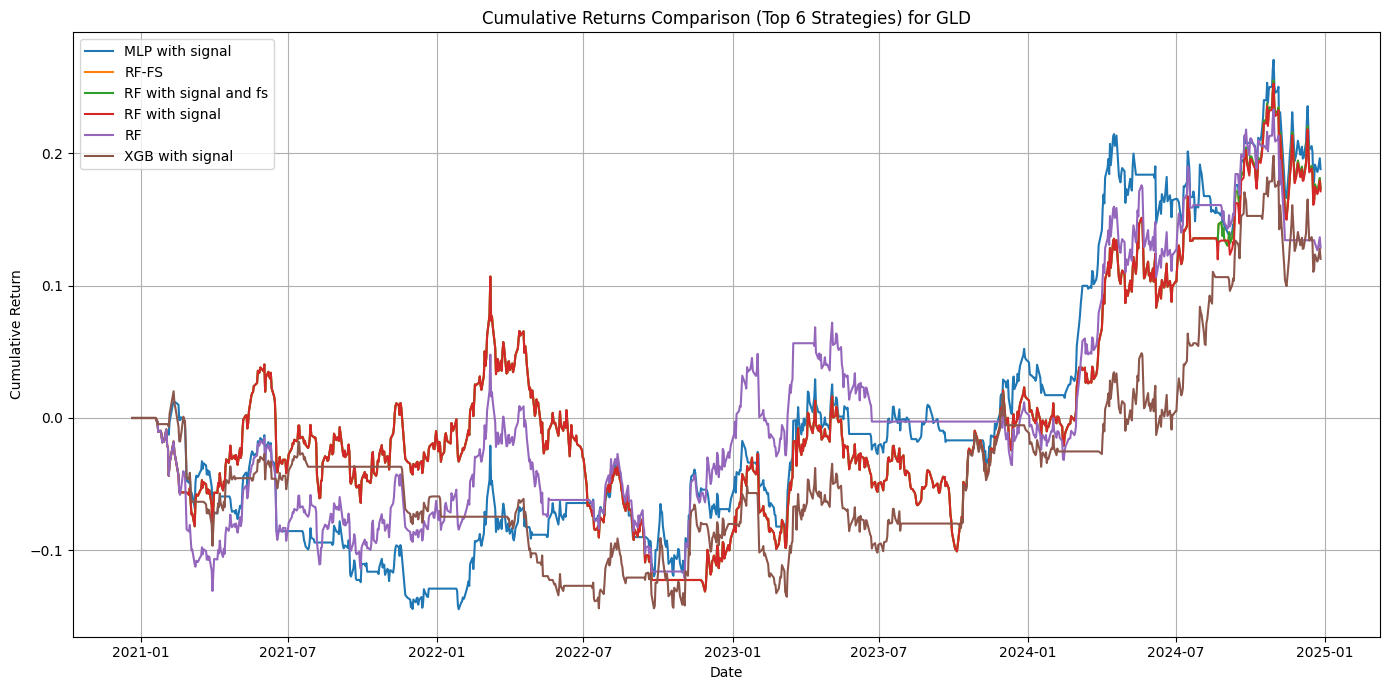

In [116]:
def plot_top6_strategies(backtest_dict, top6_strategies, stock_code='Stock', figsize=(14, 7)):
    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for strategy_name in top6_strategies:
        df = backtest_dict[strategy_name]
        val_col = [col for col in df.columns if 'strategy_value' in col][0]
        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)
    plt.title(f'Normalized Strategy Values Comparison (Top 6 Strategies) for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for strategy_name in top6_strategies:
        df = backtest_dict[strategy_name]
        ret_col = [col for col in df.columns if 'strategy_return' in col][0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=strategy_name)
    plt.title(f'Cumulative Returns Comparison (Top 6 Strategies) for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example call
plot_top6_strategies(backtest_dict, top6_strategies, stock_code=stock_code)


In [ ]:
def plot_top6_strategies(backtest_dict, top6_strategies, stock_code='Stock', figsize=(14, 7)):
    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for strategy_name in top6_strategies:
        if strategy_name not in backtest_dict:
            raise ValueError(f"Strategy '{strategy_name}' not found in backtest_dict.")
        df = backtest_dict[strategy_name]

        val_cols = [col for col in df.columns if 'strategy_value' in col]
        if not val_cols:
            raise ValueError(f"No 'strategy_value' column found in '{strategy_name}' dataframe.")
        val_col = val_cols[0]

        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)

    plt.title(f'Normalized Strategy Values Comparison (Top 6 Strategies) for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for strategy_name in top6_strategies:
        df = backtest_dict[strategy_name]

        ret_cols = [col for col in df.columns if 'strategy_return' in col]
        if not ret_cols:
            raise ValueError(f"No 'return' column found in '{strategy_name}' dataframe.")
        ret_col = ret_cols[0]

        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=strategy_name)

    plt.title(f'Cumulative Returns Comparison (Top 6 Strategies) for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_top6_strategies(backtest_dict, top6_strategies, stock_code=stock_code)


In [ ]:
def plot_ml_ti_strategies_top3each(backtest_dict, strategies_to_plot, value_col_keyword='strategy_value', stock_code='STOCK', figsize=(14,7)):
    plt.figure(figsize=figsize)

    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            print(f"Warning: '{strategy_name}' not found in backtest_dict keys.")
            continue
        df = backtest_dict[strategy_name]
        val_cols = [col for col in df.columns if value_col_keyword in col]
        if not val_cols:
            print(f"Warning: No column containing '{value_col_keyword}' in '{strategy_name}' DataFrame.")
            continue
        val_col = val_cols[0]
        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)

    plt.title(f'Normalized Strategy Values Comparison for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Select top 3 for each group
top3_ml = performance_table_clean.loc[performance_table_clean.index.isin(ml_strategies)].sort_values('annualized_return', ascending=False).head(3).index.tolist()
top3_ind = performance_table_clean.loc[performance_table_clean.index.isin(indicator_strategies)].sort_values('annualized_return', ascending=False).head(3).index.tolist()

# Combine
strategies_to_plot = top3_ml + top3_ind

# Plot
plot_ml_ti_strategies_top3each(backtest_dict, strategies_to_plot, stock_code=stock_code)


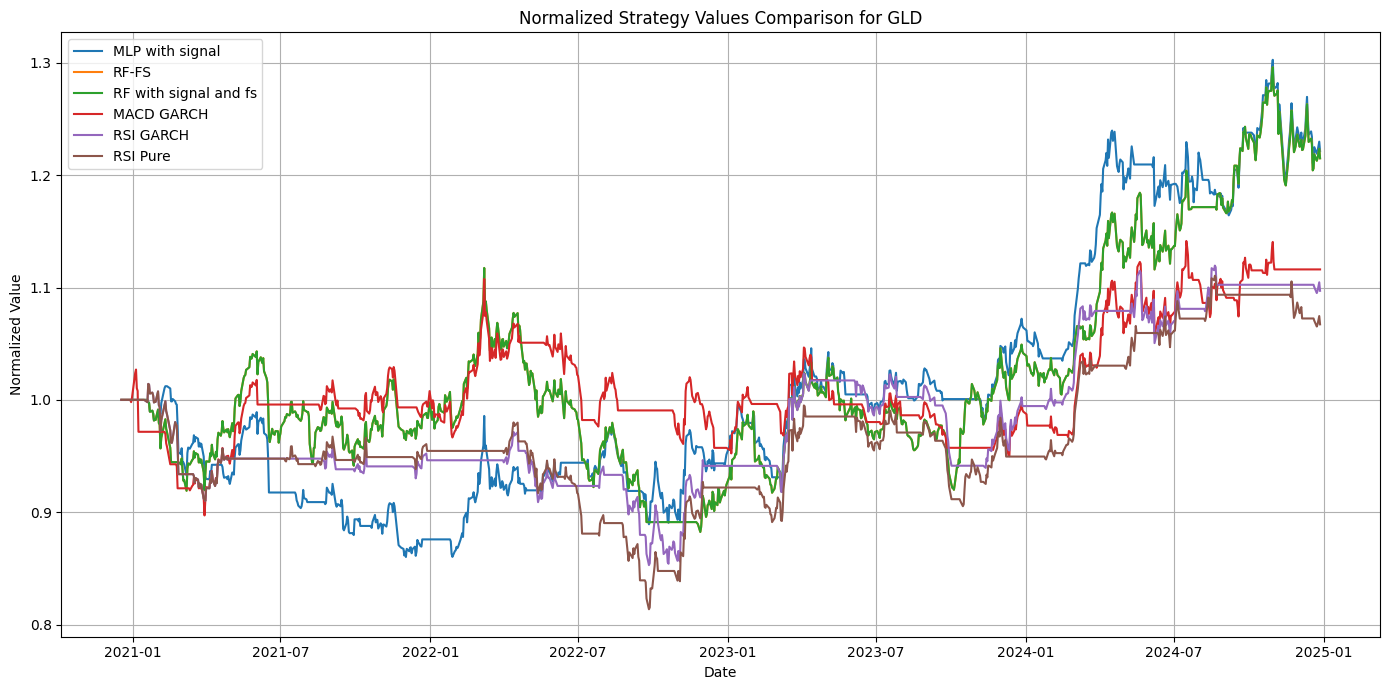

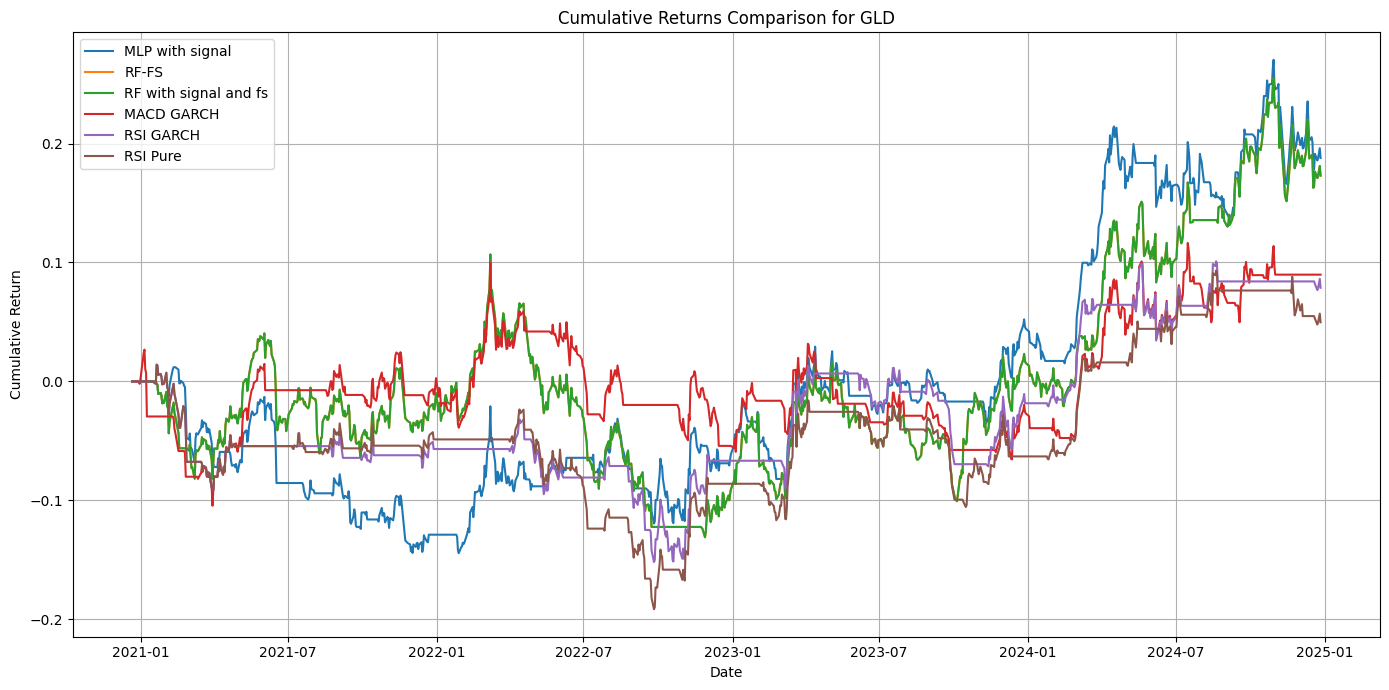

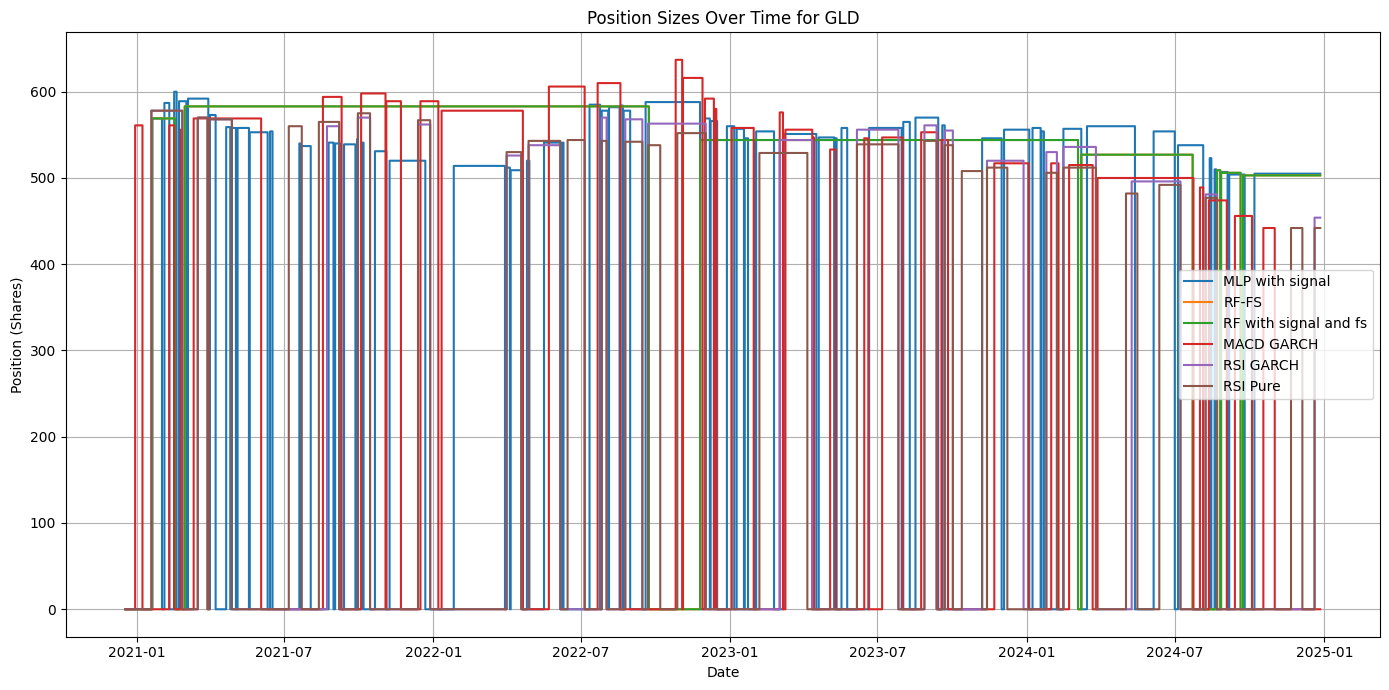

In [119]:
def plot_ml_ti_strategies_top3each_separate(
    backtest_dict, strategies_to_plot,
    value_col_keyword='strategy_value',
    stock_code='STOCK', figsize=(14,7)
):
    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            print(f"Warning: '{strategy_name}' not found in backtest_dict keys.")
            continue
        df = backtest_dict[strategy_name]
        val_cols = [col for col in df.columns if value_col_keyword in col]
        if not val_cols:
            print(f"Warning: No column containing '{value_col_keyword}' in '{strategy_name}' DataFrame.")
            continue
        val_col = val_cols[0]
        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)
    plt.title(f'Normalized Strategy Values Comparison for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            continue
        df = backtest_dict[strategy_name]
        ret_cols = [col for col in df.columns if 'strategy_return' in col]
        if not ret_cols:
            print(f"Warning: No return column found in '{strategy_name}' DataFrame.")
            continue
        ret_col = ret_cols[0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=strategy_name)
    plt.title(f'Cumulative Returns Comparison for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Position Sizes ---
    plt.figure(figsize=figsize)
    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            continue
        df = backtest_dict[strategy_name]
        pos_cols = [col for col in df.columns if 'position' in col]
        if not pos_cols:
            print(f"Warning: No position column found in '{strategy_name}' DataFrame.")
            continue
        pos_col = pos_cols[0]
        plt.step(df.index, df[pos_col], label=strategy_name, where='post')
    plt.title(f'Position Sizes Over Time for {stock_code}')
    plt.ylabel('Position (Shares)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Select top 3 for each group
top3_ml = performance_table_clean.loc[performance_table_clean.index.isin(ml_strategies)].sort_values('annualized_return', ascending=False).head(3).index.tolist()
top3_ind = performance_table_clean.loc[performance_table_clean.index.isin(indicator_strategies)].sort_values('annualized_return', ascending=False).head(3).index.tolist()

# top3_ml and top3_ind are lists of top 3 ML and technical indicator strategies (as before)
strategies_to_plot = top3_ml + top3_ind

plot_ml_ti_strategies_top3each_separate(backtest_dict, strategies_to_plot, stock_code=stock_code)


In [ ]:
def plot_ml_ti_strategies_top3each_separate(
    backtest_dict, strategies_to_plot,
    value_col_keyword='strategy_value',
    stock_code='STOCK', figsize=(14,7)
):
    # --- Plot 1: Normalized Strategy Values ---
    plt.figure(figsize=figsize)
    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            print(f"Warning: '{strategy_name}' not found in backtest_dict keys.")
            continue
        df = backtest_dict[strategy_name]
        val_cols = [col for col in df.columns if value_col_keyword in col]
        if not val_cols:
            print(f"Warning: No column containing '{value_col_keyword}' in '{strategy_name}' DataFrame.")
            continue
        val_col = val_cols[0]
        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)
    plt.title(f'Normalized Strategy Values Comparison for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Cumulative Returns ---
    plt.figure(figsize=figsize)
    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            continue
        df = backtest_dict[strategy_name]
        ret_cols = [col for col in df.columns if 'strategy_return' in col]
        if not ret_cols:
            print(f"Warning: No return column found in '{strategy_name}' DataFrame.")
            continue
        ret_col = ret_cols[0]
        cumret = (1 + df[ret_col]).cumprod() - 1
        plt.plot(df.index, cumret, label=strategy_name)
    plt.title(f'Cumulative Returns Comparison for {stock_code}')
    plt.ylabel('Cumulative Return')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Position Sizes ---
    plt.figure(figsize=figsize)
    for strategy_name in strategies_to_plot:
        if strategy_name not in backtest_dict:
            continue
        df = backtest_dict[strategy_name]
        pos_cols = [col for col in df.columns if 'position' in col]
        if not pos_cols:
            print(f"Warning: No position column found in '{strategy_name}' DataFrame.")
            continue
        pos_col = pos_cols[0]
        plt.step(df.index, df[pos_col], label=strategy_name, where='post')
    plt.title(f'Position Sizes Over Time for {stock_code}')
    plt.ylabel('Position (Shares)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example: select top 3 ML and top 3 indicator strategies by annualized return
top3_ml = performance_table_clean.loc[
    performance_table_clean.index.isin(ml_strategies)
].sort_values('annualized_return', ascending=False).head(3).index.tolist()

top3_ind = performance_table_clean.loc[
    performance_table_clean.index.isin(indicator_strategies)
].sort_values('annualized_return', ascending=False).head(3).index.tolist()

strategies_to_plot = top3_ml + top3_ind

plot_ml_ti_strategies_top3each_separate(backtest_dict, strategies_to_plot, stock_code=stock_code)


Top 6 strategies: ['Pure MLP with signal', 'Pure RF with signal and fs', 'Pure RF-FS', 'Pure XGB with signal', 'MLP with signal', 'RF-FS']


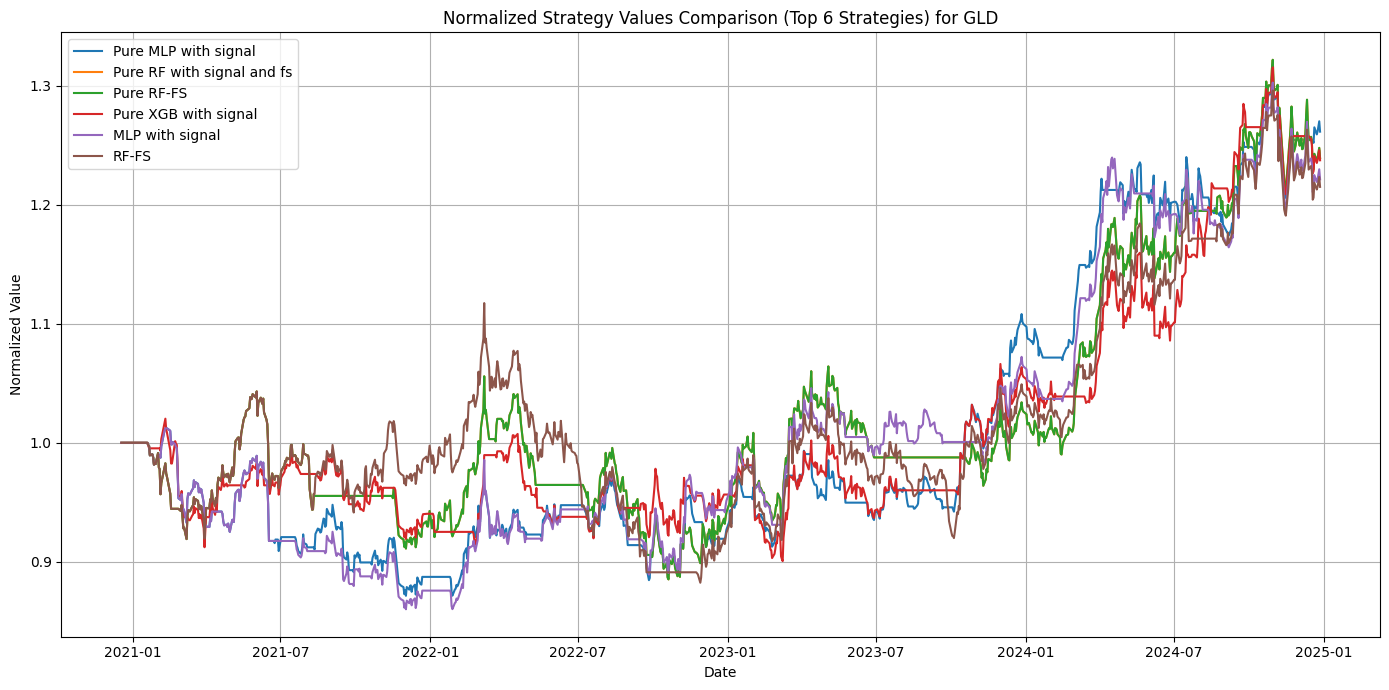

In [121]:
# --- Get top 6 strategies ---
top6_strategies = full_performance_table.head(6).index.tolist()
print("Top 6 strategies:", top6_strategies)

# --- Map strategy names to backtest DataFrames ---
backtest_dict = {
    'BB Pure': bb_pure_bt,
    'BB GARCH': bb_garch_bt,
    'MACD Pure': macd_pure_bt,
    'MACD GARCH': macd_garch_bt,
    'RSI Pure': rsi_pure_bt,
    'RSI GARCH': rsi_garch_bt,
    'RF': rf_nofs_bt,
    'RF-FS': rf_bt,
    'Pure RF': rf_nofs_nogarch_bt,
    'Pure RF-FS': rf_nogarch_bt,
    'XGB': xgb_nofs_bt,
    'XGB-FS': xgb_bt,
    'MLP + PCA': mlp_pca_bt,
    'RF with signal': rf_sig_bt,
    'XGB with signal': xgb_sig_bt,
    'MLP + PCA with signal': mlp_pca_sig_bt,
    'RF with signal and fs': rf_sig_fs_bt,
    'XGB with signal and fs': xgb_sig_fs_bt,
    'MLP': mlp_bt,
    'MLP with signal': mlp_sig_bt,
    'Pure XGB': xgb_nofs_nogarch_bt,
    'Pure XGB-FS': xgb_nogarch_bt,
    'Pure MLP + PCA': mlp_pca_nogarch_bt,
    'Pure RF with signal': rf_sig_nogarch_bt,
    'Pure XGB with signal': xgb_sig_nogarch_bt,
    'Pure MLP + PCA with signal': mlp_pca_sig_nogarch_bt,
    'Pure RF with signal and fs': rf_sig_fs_nogarch_bt,
    'Pure XGB with signal and fs': xgb_sig_fs_nogarch_bt,
    'Pure MLP': mlp_nogarch_bt,
    'Pure MLP with signal': mlp_sig_nogarch_bt,
}

# Machine Learning strategies
ml_strategies = [
    'RF', 'RF-FS', 'XGB', 'XGB-FS',
    'MLP + PCA', 'RF with signal', 'XGB with signal', 'MLP + PCA with signal',
    'RF with signal and fs', 'XGB with signal and fs',
    'MLP', 'MLP with signal'
]

# Technical Indicator-based strategies
indicator_strategies = [
    'BB Pure', 'BB GARCH',
    'MACD Pure', 'MACD GARCH',
    'RSI Pure', 'RSI GARCH'
]


# --- Plot function ---
def plot_top6_strategies_single_plot(backtest_dict, top6_strategies, value_col_keyword='strategy_value', figsize=(14,7)):
    plt.figure(figsize=figsize)

    for strategy_name in top6_strategies:
        df = backtest_dict[strategy_name]
        val_col = [col for col in df.columns if value_col_keyword in col][0]
        norm_values = df[val_col] / df[val_col].iloc[0]
        plt.plot(df.index, norm_values, label=strategy_name)

    plt.title(f'Normalized Strategy Values Comparison (Top 6 Strategies) for {stock_code}')
    plt.ylabel('Normalized Value')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Call the plot function ---
plot_top6_strategies_single_plot(backtest_dict, top6_strategies)


# Heatmap

In [ ]:
# Step 1 — Combine all SL/TP DataFrames into one big DataFrame
all_perf_df = []
for sl_tp_key, df in performance_tables_by_sl_tp.items():
    sl_match = re.search(r"SL(\d+)", sl_tp_key)
    tp_match = re.search(r"TP(\d+)", sl_tp_key)
    if sl_match and tp_match:
        sl_val = int(sl_match.group(1))
        tp_val = int(tp_match.group(1))
        temp_df = df.copy()
        temp_df["SL"] = sl_val
        temp_df["TP"] = tp_val
        all_perf_df.append(temp_df)

all_perf_df = pd.concat(all_perf_df, ignore_index=True)

# Step 2 — Extract model and risk percentile from Strategy name
def parse_strategy(s):
    # Example: bb_garch_50, rf_nofs_75, rf_nofs_nogarch_pure
    parts = s.split("_")
    rp = None
    model = None
    if parts[-1].isdigit():  # e.g., 50, 75, 90
        rp = int(parts[-1])
        model = "_".join(parts[:-1])
    else:
        model = s
    return model, rp

all_perf_df[["Model", "RiskPercentile"]] = all_perf_df["Strategy"].apply(
    lambda x: pd.Series(parse_strategy(x))
)

# Step 3 — Choose the metric to visualize (e.g., Sharpe ratio)
metric = "sharpe_ratio"

# Step 4 — Create heatmaps per Model & Risk Percentile
unique_models = all_perf_df["Model"].unique()
n_models = len(unique_models)
ncols = 3
nrows = -(-n_models // ncols)  # ceiling division

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for idx, model in enumerate(unique_models):
    ax = axes[idx]
    model_df = all_perf_df[all_perf_df["Model"] == model]

    # If you want separate heatmaps per RP:
    # loop over sorted(model_df["RiskPercentile"].dropna().unique()) and create subplots
    # For now we take all risk percentiles average
    pivot_df = model_df.pivot_table(index="SL", columns="TP", values=metric, aggfunc="mean")

    sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax)
    ax.set_title(model)
    ax.set_ylabel("SL")
    ax.set_xlabel("TP")

# Remove empty subplots
for ax in axes[len(unique_models):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [ ]:
# Step 1 — Combine all SL/TP DataFrames into one big DataFrame
all_perf_df = []
for sl_tp_key, df in performance_tables_by_sl_tp.items():
    sl_match = re.search(r"SL(\d+)", sl_tp_key)
    tp_match = re.search(r"TP(\d+)", sl_tp_key)
    if sl_match and tp_match:
        sl_val = int(sl_match.group(1))
        tp_val = int(tp_match.group(1))
        temp_df = df.copy()
        temp_df["SL"] = sl_val
        temp_df["TP"] = tp_val
        all_perf_df.append(temp_df)

all_perf_df = pd.concat(all_perf_df, ignore_index=True)

# Step 2 — Extract model and RP from Strategy name
def parse_strategy(s):
    parts = s.split("_")
    if parts[-1].isdigit():  # ends with RP number
        rp = int(parts[-1])
        model = "_".join(parts[:-1])
    else:
        rp = None
        model = s
    return model, rp

all_perf_df[["Model", "RiskPercentile"]] = all_perf_df["Strategy"].apply(
    lambda x: pd.Series(parse_strategy(x))
)

# Step 3 — Filter only rows with RP defined
all_perf_df = all_perf_df.dropna(subset=["RiskPercentile"])

# Step 4 — Choose the metric to visualize
metric = "sharpe_ratio"  # change to total_return, annualized_return, etc.

# Step 5 — Get unique models and risk percentiles
models = sorted(all_perf_df["Model"].unique())
risk_percentiles = sorted(all_perf_df["RiskPercentile"].unique())

# Step 6 — Create subplot grid
fig, axes = plt.subplots(len(models), len(risk_percentiles),
                         figsize=(4 * len(risk_percentiles), 4 * len(models)),
                         sharex=True, sharey=True)

# If only one row or col, convert axes to 2D array
if len(models) == 1:
    axes = [axes]
if len(risk_percentiles) == 1:
    axes = [[ax] for ax in axes]

# Step 7 — Fill heatmaps
for i, model in enumerate(models):
    for j, rp in enumerate(risk_percentiles):
        ax = axes[i][j]
        sub_df = all_perf_df[(all_perf_df["Model"] == model) &
                             (all_perf_df["RiskPercentile"] == rp)]
        if sub_df.empty:
            ax.axis("off")
            continue

        pivot_df = sub_df.pivot_table(index="SL", columns="TP", values=metric, aggfunc="mean")
        sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax,
                    cbar=(i == 0 and j == len(risk_percentiles) - 1))  # show cbar only in top-right

        if i == 0:
            ax.set_title(f"RP {rp}", fontsize=12)
        if j == 0:
            ax.set_ylabel(model, fontsize=10)
        else:
            ax.set_ylabel("")

        ax.set_xlabel("TP")

plt.tight_layout()
plt.show()


In [ ]:
# === STEP 1 — Combine all SL/TP DataFrames into one master DataFrame ===
all_perf_df = []
for sl_tp_key, df in performance_tables_by_sl_tp.items():
    sl_match = re.search(r"SL(\d+)", sl_tp_key)
    tp_match = re.search(r"TP(\d+)", sl_tp_key)
    if sl_match and tp_match:
        sl_val = int(sl_match.group(1))
        tp_val = int(tp_match.group(1))
        temp_df = df.copy()
        temp_df["SL"] = sl_val
        temp_df["TP"] = tp_val
        all_perf_df.append(temp_df)

all_perf_df = pd.concat(all_perf_df, ignore_index=True)

# === STEP 2 — Extract model name & RP (or "No GARCH") from Strategy ===
def parse_strategy(s):
    parts = s.split("_")
    if parts[-1].isdigit():  # ends with RP number
        rp = int(parts[-1])
        model = "_".join(parts[:-1])
    elif s.endswith("_pure") or "_nogarch" in s:  # no GARCH case
        rp = "No GARCH"
        model = s
    else:
        rp = None
        model = s
    return model, rp

all_perf_df[["Model", "RiskPercentile"]] = all_perf_df["Strategy"].apply(
    lambda x: pd.Series(parse_strategy(x))
)

# === STEP 3 — Keep only rows with a defined RP (numeric or "No GARCH") ===
all_perf_df = all_perf_df.dropna(subset=["RiskPercentile"])

# === STEP 4 — Set metric to visualize ===
metric = "sharpe_ratio"  # options: total_return, annualized_return, etc.

# === STEP 5 — Sort models & RP order (custom order so "No GARCH" comes first) ===
models = sorted(all_perf_df["Model"].unique())
rp_order = ["No GARCH"] + sorted([rp for rp in all_perf_df["RiskPercentile"].unique() if rp != "No GARCH"])

# === STEP 6 — Loop through models & create one row per model ===
for model in models:
    fig, axes = plt.subplots(1, len(rp_order), figsize=(4 * len(rp_order), 4), sharey=True)

    if len(rp_order) == 1:
        axes = [axes]

    for j, rp in enumerate(rp_order):
        ax = axes[j]
        sub_df = all_perf_df[(all_perf_df["Model"] == model) &
                             (all_perf_df["RiskPercentile"] == rp)]
        if sub_df.empty:
            ax.axis("off")
            continue

        pivot_df = sub_df.pivot_table(index="SL", columns="TP", values=metric, aggfunc="mean")
        sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax,
                    cbar=(j == len(rp_order)-1))  # show cbar only on rightmost RP

        ax.set_title(f"RP {rp}" if rp != "No GARCH" else "No GARCH")
        ax.set_xlabel("TP")
        if j == 0:
            ax.set_ylabel(model)
        else:
            ax.set_ylabel("")

    plt.tight_layout()
    plt.savefig(f"heatmap_{model}_{stock_code}.png", dpi=300)
    plt.show()


# Bar plot

In [ ]:
# === STEP 1 — Keep only necessary columns ===
plot_df = all_perf_df[["Model", "RiskPercentile", "SL", "TP", "sharpe_ratio"]].copy()

# Ensure RP is string for plotting
plot_df["RiskPercentile"] = plot_df["RiskPercentile"].astype(str)

# === STEP 2 — Loop through unique SL, TP, RP combinations ===
sl_values = sorted(plot_df["SL"].unique())
tp_values = sorted(plot_df["TP"].unique())
rp_values = sorted([rp for rp in plot_df["RiskPercentile"].unique() if rp != "No GARCH"])
rp_values = ["No GARCH"] + rp_values  # put No GARCH first

for sl in sl_values:
    for tp in tp_values:
        for rp in rp_values:
            # Select rows matching this SL, TP, RP or No GARCH
            sub_df = plot_df[
                ((plot_df["SL"] == sl) & (plot_df["TP"] == tp) & (plot_df["RiskPercentile"] == rp)) |
                ((plot_df["SL"] == sl) & (plot_df["TP"] == tp) & (plot_df["RiskPercentile"] == "No GARCH"))
            ]
            if sub_df.empty:
                continue

            plt.figure(figsize=(8, 5))
            sns.barplot(x="Model", y="sharpe_ratio", data=sub_df, palette="viridis")
            plt.xticks(rotation=45, ha="right")
            plt.title(f"SL={sl} TP={tp} RP={rp}")
            plt.ylabel("Sharpe Ratio")
            plt.xlabel("Model")
            plt.tight_layout()
            # Save automatically
            plt.savefig(f"bar_SL{sl}_TP{tp}_RP{rp}.png", dpi=300)
            plt.show()


In [ ]:
# === STEP 1 — Keep only necessary columns ===
plot_df = all_perf_df[["Model", "RiskPercentile", "SL", "TP", "sharpe_ratio"]].copy()

# Ensure RP is string for plotting
plot_df["RiskPercentile"] = plot_df["RiskPercentile"].astype(str)

# === STEP 2 — Loop through unique SL, TP, RP combinations ===
sl_values = sorted(plot_df["SL"].unique())
tp_values = sorted(plot_df["TP"].unique())
rp_values = sorted([rp for rp in plot_df["RiskPercentile"].unique() if rp != "No GARCH"])
rp_values = ["No GARCH"] + rp_values  # put No GARCH first

for sl in sl_values:
    for tp in tp_values:
        for rp in rp_values:
            # Select rows matching this SL, TP, RP or No GARCH
            sub_df = plot_df[
                ((plot_df["SL"] == sl) & (plot_df["TP"] == tp) & (plot_df["RiskPercentile"] == rp)) |
                ((plot_df["SL"] == sl) & (plot_df["TP"] == tp) & (plot_df["RiskPercentile"] == "No GARCH"))
            ]
            if sub_df.empty:
                continue

            # Sort models by Sharpe ratio (high to low)
            model_order = sub_df.sort_values("sharpe_ratio", ascending=False)["Model"]

            plt.figure(figsize=(8, 5))
            sns.barplot(
                x="Model",
                y="sharpe_ratio",
                data=sub_df,
                palette="viridis",
                order=model_order  # <-- sort here
            )
            plt.xticks(rotation=45, ha="right")
            plt.title(f"SL={sl} TP={tp} RP={rp}")
            plt.ylabel("Sharpe Ratio")
            plt.xlabel("Model")
            plt.tight_layout()
            # Save automatically
            plt.savefig(f"SP_bar_SL{sl}_TP{tp}_RP{rp}.png", dpi=300)
            plt.show()


In [ ]:
# === STEP 1 — Keep only necessary columns ===
plot_df = all_perf_df[["Model", "RiskPercentile", "SL", "TP", "total_return"]].copy()

# Ensure RP is string for plotting
plot_df["RiskPercentile"] = plot_df["RiskPercentile"].astype(str)

# === STEP 2 — Loop through unique SL, TP, RP combinations ===
sl_values = sorted(plot_df["SL"].unique())
tp_values = sorted(plot_df["TP"].unique())
rp_values = sorted([rp for rp in plot_df["RiskPercentile"].unique() if rp != "No GARCH"])
rp_values = ["No GARCH"] + rp_values  # put No GARCH first

for sl in sl_values:
    for tp in tp_values:
        for rp in rp_values:
            # Select rows matching this SL, TP, RP or No GARCH
            sub_df = plot_df[
                ((plot_df["SL"] == sl) & (plot_df["TP"] == tp) & (plot_df["RiskPercentile"] == rp)) |
                ((plot_df["SL"] == sl) & (plot_df["TP"] == tp) & (plot_df["RiskPercentile"] == "No GARCH"))
            ]
            if sub_df.empty:
                continue

            # Sort models by total_return (high to low)
            model_order = sub_df.sort_values("total_return", ascending=False)["Model"]

            plt.figure(figsize=(8, 5))
            sns.barplot(
                x="Model",
                y="total_return",
                data=sub_df,
                palette="viridis",
                order=model_order  # <-- sort here
            )
            plt.xticks(rotation=45, ha="right")
            plt.title(f"SL={sl} TP={tp} RP={rp}")
            plt.ylabel("Total Return")
            plt.xlabel("Model")
            plt.tight_layout()
            # Save automatically
            plt.savefig(f"TR_bar_SL{sl}_TP{tp}_RP{rp}.png", dpi=300)
            plt.show()


# Performance Table (Key Metric)

In [128]:
# Keep relevant columns
perf_table = all_perf_df[[
    "Model", "RiskPercentile", "SL", "TP", "total_return",
    "annualized_return","annualized_volatility","sharpe_ratio","max_drawdown",
    "alpha_annualized_market_benchmark","alpha_annualized_asset_benchmark"
]].copy()

# Ensure RiskPercentile is string
perf_table["RiskPercentile"] = perf_table["RiskPercentile"].astype(str)

# Replace Inf/-Inf with NaN and fill NaNs to avoid Excel issues
perf_table = perf_table.replace([np.inf, -np.inf], np.nan).fillna("")

# Unique SL, TP, RP values
sl_values = sorted(perf_table["SL"].unique())
tp_values = sorted(perf_table["TP"].unique())
rp_values = sorted([rp for rp in perf_table["RiskPercentile"].unique() if rp != "No GARCH"])
rp_values = ["No GARCH"] + rp_values  # include No GARCH first

# Function to clean Excel sheet names
def clean_sheet_name(name):
    name = re.sub(r'[\[\]\*\/\\\?\:]', '_', name)  # remove invalid chars
    return name[:31]  # Excel sheet name limit

# Create Excel writer using context manager
with pd.ExcelWriter(f'Grouped_Performance_Tables_{stock_code}.xlsx', engine="openpyxl") as excel_writer:
    for sl in sl_values:
        for tp in tp_values:
            for rp in rp_values:
                # Select rows with this SL, TP, RP or No GARCH
                sub_df = perf_table[
                    ((perf_table["SL"] == sl) & (perf_table["TP"] == tp) & (perf_table["RiskPercentile"] == rp)) |
                    ((perf_table["SL"] == sl) & (perf_table["TP"] == tp) & (perf_table["RiskPercentile"] == "No GARCH"))
                ]
                if sub_df.empty:
                    continue

                # Sort by total_return descending
                sub_df = sub_df.sort_values("total_return", ascending=False).reset_index(drop=True)

                # Add ranking column
                sub_df["Rank"] = sub_df["total_return"].rank(method="min", ascending=False).astype(int)

                # Print table to console
                print(f"\n=== Performance Table: SL={sl}, TP={tp}, RP={rp} ===\n")
                print(sub_df)

                # Write to Excel
                sheet_name = clean_sheet_name(f"SL{sl}_TP{tp}_RP{rp}")
                sub_df.to_excel(excel_writer, sheet_name=sheet_name, index=False)

print(f'\nAll grouped performance tables saved to Grouped_Performance_Tables_{stock_code}.xlsx')


Streaming output truncated to the last 5000 lines.
20           0.007310               0.088574     -0.256882     -0.220285   
21           0.007111               0.098904     -0.232016     -0.201358   
22           0.004882               0.106394     -0.236548     -0.231517   
23           0.003659               0.106517     -0.247508     -0.126442   
24          -0.027191               0.096129     -0.599290     -0.234250   
25          -0.039494               0.098330     -0.715377     -0.225237   
26          -0.051977               0.106983     -0.779753     -0.274018   
27          -0.070100               0.082515     -1.245749     -0.304878   
28          -0.079082               0.097256     -1.156059     -0.296440   
29          -0.081874               0.089792     -1.286255     -0.328811   

    alpha_annualized_market_benchmark  alpha_annualized_asset_benchmark  Rank  
0                            0.003498                          0.002688     1  
1                           